# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


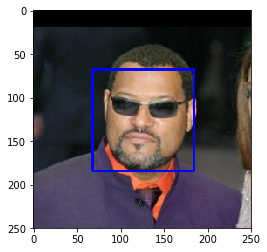

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_detected = [h for h in human_files_short if face_detector(h)]
h_pc = len(human_detected) * 1.
print("Human percentage: {}%".format(h_pc))
dog_detected = [d for d in dog_files_short if face_detector(d)]
d_pc = len(dog_detected) * 1.
print("Dog percentage: {}%".format(d_pc))

Human percentage: 99.0%
Dog percentage: 12.0%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

def load_resized(img_path):
    print("Img: {}".format(img_path))
    img = cv2.imread(img_path)
    return cv2.resize(img, (224, 224))

humans_X = [load_resized(i) for i in human_files]
dogs_X = [load_resized(i) for i in train_files]

Img: lfw\Muhammad_Ali\Muhammad_Ali_0001.jpg
Img: lfw\Yoko_Ono\Yoko_Ono_0001.jpg
Img: lfw\Svetlana_Koroleva\Svetlana_Koroleva_0002.jpg
Img: lfw\Laurence_Fishburne\Laurence_Fishburne_0001.jpg
Img: lfw\Jennifer_Capriati\Jennifer_Capriati_0007.jpg
Img: lfw\George_W_Bush\George_W_Bush_0399.jpg
Img: lfw\Tom_Ridge\Tom_Ridge_0001.jpg
Img: lfw\Catherine_Woodard\Catherine_Woodard_0001.jpg
Img: lfw\Fabricio_Oberto\Fabricio_Oberto_0001.jpg
Img: lfw\Pete_Sampras\Pete_Sampras_0011.jpg
Img: lfw\Alejandro_Toledo\Alejandro_Toledo_0003.jpg
Img: lfw\Elin_Nordegren\Elin_Nordegren_0002.jpg
Img: lfw\Darcy_Regier\Darcy_Regier_0001.jpg
Img: lfw\Ataollah_Mohajerani\Ataollah_Mohajerani_0001.jpg
Img: lfw\Mahathir_Mohamad\Mahathir_Mohamad_0009.jpg
Img: lfw\Hans_Blix\Hans_Blix_0027.jpg
Img: lfw\Paul_McCartney\Paul_McCartney_0003.jpg
Img: lfw\Jason_Kidd\Jason_Kidd_0007.jpg
Img: lfw\Hugo_Chavez\Hugo_Chavez_0007.jpg
Img: lfw\Ian_Thorpe\Ian_Thorpe_0005.jpg
Img: lfw\Colin_Cowie\Colin_Cowie_0001.jpg
Img: lfw\John_Howard

Img: lfw\Emmy_Rossum\Emmy_Rossum_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0065.jpg
Img: lfw\Iva_Majoli\Iva_Majoli_0001.jpg
Img: lfw\Jean_Chretien\Jean_Chretien_0029.jpg
Img: lfw\Nicole_Kidman\Nicole_Kidman_0014.jpg
Img: lfw\Klaus_Schwab\Klaus_Schwab_0001.jpg
Img: lfw\Nathan_Doudney\Nathan_Doudney_0001.jpg
Img: lfw\Shaul_Mofaz\Shaul_Mofaz_0001.jpg
Img: lfw\Jeffrey_Archer\Jeffrey_Archer_0002.jpg
Img: lfw\Igor_Ivanov\Igor_Ivanov_0012.jpg
Img: lfw\Brian_StPierre\Brian_StPierre_0001.jpg
Img: lfw\Harbhajan_Singh\Harbhajan_Singh_0001.jpg
Img: lfw\Troy_Polamalu\Troy_Polamalu_0001.jpg
Img: lfw\Lee_Nam-shin\Lee_Nam-shin_0001.jpg
Img: lfw\David_Nalbandian\David_Nalbandian_0014.jpg
Img: lfw\Lynne_Cheney\Lynne_Cheney_0003.jpg
Img: lfw\William_Perry\William_Perry_0001.jpg
Img: lfw\Albert_Costa\Albert_Costa_0005.jpg
Img: lfw\George_W_Bush\George_W_Bush_0351.jpg
Img: lfw\Billy_Donovan\Billy_Donovan_0001.jpg
Img: lfw\Amanda_Marsh\Amanda_Marsh_0001.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_006

Img: lfw\Lord_Hutton\Lord_Hutton_0002.jpg
Img: lfw\Paul_Byrd\Paul_Byrd_0001.jpg
Img: lfw\Larry_Lucchino\Larry_Lucchino_0001.jpg
Img: lfw\Frank_Solich\Frank_Solich_0003.jpg
Img: lfw\Bill_Nelson\Bill_Nelson_0002.jpg
Img: lfw\Michelle_Kwan\Michelle_Kwan_0008.jpg
Img: lfw\Michael_Ballack\Michael_Ballack_0002.jpg
Img: lfw\Hushiar_Zebari\Hushiar_Zebari_0001.jpg
Img: lfw\Mitchell_Daniels\Mitchell_Daniels_0003.jpg
Img: lfw\Denzel_Washington\Denzel_Washington_0005.jpg
Img: lfw\George_W_Bush\George_W_Bush_0016.jpg
Img: lfw\Mikhail_Youzhny\Mikhail_Youzhny_0002.jpg
Img: lfw\Tommy_Haas\Tommy_Haas_0004.jpg
Img: lfw\Aidan_Quinn\Aidan_Quinn_0001.jpg
Img: lfw\Rachel_Kempson\Rachel_Kempson_0001.jpg
Img: lfw\Jennifer_Lopez\Jennifer_Lopez_0020.jpg
Img: lfw\Megawati_Sukarnoputri\Megawati_Sukarnoputri_0008.jpg
Img: lfw\Sebastian_Saja\Sebastian_Saja_0001.jpg
Img: lfw\Daniel_Scioli\Daniel_Scioli_0001.jpg
Img: lfw\Sharon_Davis\Sharon_Davis_0002.jpg
Img: lfw\Dagmar_Dunlevy\Dagmar_Dunlevy_0001.jpg
Img: lfw\Georg

Img: lfw\Pete_Sampras\Pete_Sampras_0022.jpg
Img: lfw\Lyle_Lovett\Lyle_Lovett_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0062.jpg
Img: lfw\John_Lynch\John_Lynch_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0171.jpg
Img: lfw\Lleyton_Hewitt\Lleyton_Hewitt_0010.jpg
Img: lfw\Colin_Powell\Colin_Powell_0157.jpg
Img: lfw\Jon_Constance\Jon_Constance_0001.jpg
Img: lfw\Ciro_Gomes\Ciro_Gomes_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0382.jpg
Img: lfw\Judi_Patton\Judi_Patton_0001.jpg
Img: lfw\Bud_Selig\Bud_Selig_0001.jpg
Img: lfw\David_McCullough\David_McCullough_0001.jpg
Img: lfw\Norman_Jewison\Norman_Jewison_0002.jpg
Img: lfw\Maggie_Cheung\Maggie_Cheung_0001.jpg
Img: lfw\Tang_Jiaxuan\Tang_Jiaxuan_0006.jpg
Img: lfw\Lynn_Abraham\Lynn_Abraham_0002.jpg
Img: lfw\Jose_Jose\Jose_Jose_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0119.jpg
Img: lfw\Paul_William_Hurley\Paul_William_Hurley_0002.jpg
Img: lfw\Paul_Tagliabue\Paul_Tagliabue_0001.jpg
Img: lfw\Tommy_Thompson\Tommy_Thompson_0009.jpg
Img: lfw\Jos

Img: lfw\El_Hadji_Diouf\El_Hadji_Diouf_0001.jpg
Img: lfw\Hunter_Kemper\Hunter_Kemper_0001.jpg
Img: lfw\Jim_Parque\Jim_Parque_0001.jpg
Img: lfw\Bill_McBride\Bill_McBride_0001.jpg
Img: lfw\Winona_Ryder\Winona_Ryder_0001.jpg
Img: lfw\Princess_Maxima\Princess_Maxima_0001.jpg
Img: lfw\Colin_Jackson\Colin_Jackson_0002.jpg
Img: lfw\Spike_Lee\Spike_Lee_0001.jpg
Img: lfw\Yannos_Papantoniou\Yannos_Papantoniou_0001.jpg
Img: lfw\Pham_Sy_Chien\Pham_Sy_Chien_0001.jpg
Img: lfw\Gloria_Macapagal_Arroyo\Gloria_Macapagal_Arroyo_0034.jpg
Img: lfw\Jackie_Sherrill\Jackie_Sherrill_0001.jpg
Img: lfw\Hamid_Karzai\Hamid_Karzai_0014.jpg
Img: lfw\Dominique_de_Villepin\Dominique_de_Villepin_0005.jpg
Img: lfw\Jeremy_Wotherspoon\Jeremy_Wotherspoon_0001.jpg
Img: lfw\Bill_Callahan\Bill_Callahan_0002.jpg
Img: lfw\Paul_Murphy\Paul_Murphy_0001.jpg
Img: lfw\Jerry_Sexton\Jerry_Sexton_0001.jpg
Img: lfw\Malcolm_Glazer\Malcolm_Glazer_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0304.jpg
Img: lfw\David_Beckham\David_Beckham_0

Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0070.jpg
Img: lfw\Bill_Clinton\Bill_Clinton_0011.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0031.jpg
Img: lfw\Scott_Rolen\Scott_Rolen_0001.jpg
Img: lfw\Jake_Gyllenhaal\Jake_Gyllenhaal_0003.jpg
Img: lfw\Greg_Rusedski\Greg_Rusedski_0003.jpg
Img: lfw\Carson_Palmer\Carson_Palmer_0002.jpg
Img: lfw\Kathleen_Abernathy\Kathleen_Abernathy_0001.jpg
Img: lfw\Oxana_Fedorova\Oxana_Fedorova_0001.jpg
Img: lfw\Yoko_Ono\Yoko_Ono_0003.jpg
Img: lfw\Mark_Gangloff\Mark_Gangloff_0001.jpg
Img: lfw\Kyra_Sedgwick\Kyra_Sedgwick_0001.jpg
Img: lfw\Amanda_Plumer\Amanda_Plumer_0001.jpg
Img: lfw\Carlos_Moya\Carlos_Moya_0015.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0076.jpg
Img: lfw\John_Fenn\John_Fenn_0001.jpg
Img: lfw\Sara_Silverman\Sara_Silverman_0001.jpg
Img: lfw\John_Negroponte\John_Negroponte_0017.jpg
Img: lfw\Andrew_Bunner\Andrew_Bunner_0002.jpg
Img: lfw\Mahathir_Mohamad\Mahathir_Mohamad_0008.jpg
Img: lfw\Sarah_Jessica_Parker\Sarah_Jessica_Parker_0004.jpg
Img:

Img: lfw\Renee_Zellweger\Renee_Zellweger_0004.jpg
Img: lfw\Hugo_Chavez\Hugo_Chavez_0049.jpg
Img: lfw\Liu_Ye\Liu_Ye_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0147.jpg
Img: lfw\Bobby_Robson\Bobby_Robson_0002.jpg
Img: lfw\Amber_Tamblyn\Amber_Tamblyn_0001.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0044.jpg
Img: lfw\Claire_Leger\Claire_Leger_0002.jpg
Img: lfw\Britney_Spears\Britney_Spears_0002.jpg
Img: lfw\Len_Jenoff\Len_Jenoff_0002.jpg
Img: lfw\Armando_Calderon_Sol\Armando_Calderon_Sol_0001.jpg
Img: lfw\Abdel_Madi_Shabneh\Abdel_Madi_Shabneh_0001.jpg
Img: lfw\Michelle_Branch\Michelle_Branch_0002.jpg
Img: lfw\Andrei_Mikhnevich\Andrei_Mikhnevich_0002.jpg
Img: lfw\Graeme_Smith\Graeme_Smith_0001.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0087.jpg
Img: lfw\Carla_Sullivan\Carla_Sullivan_0001.jpg
Img: lfw\Amer_al-Saadi\Amer_al-Saadi_0003.jpg
Img: lfw\Julianna_Margulies\Julianna_Margulies_0001.jpg
Img: lfw\James_Collinson\James_Collinson_0001.jpg
Img: lfw\Laurence_Tribe\Laurence_Tribe_0001.jp

Img: lfw\Tony_Blair\Tony_Blair_0113.jpg
Img: lfw\Nestor_Kirchner\Nestor_Kirchner_0021.jpg
Img: lfw\Joseph_Estrada\Joseph_Estrada_0003.jpg
Img: lfw\George_W_Bush\George_W_Bush_0185.jpg
Img: lfw\Geoff_Hoon\Geoff_Hoon_0004.jpg
Img: lfw\Tony_Blair\Tony_Blair_0019.jpg
Img: lfw\Conrad_Black\Conrad_Black_0001.jpg
Img: lfw\Ted_Maher\Ted_Maher_0001.jpg
Img: lfw\Chris_Cooper\Chris_Cooper_0001.jpg
Img: lfw\Roy_Romanow\Roy_Romanow_0001.jpg
Img: lfw\Russell_Crowe\Russell_Crowe_0002.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0018.jpg
Img: lfw\Alex_Wallau\Alex_Wallau_0001.jpg
Img: lfw\Kit_Bond\Kit_Bond_0001.jpg
Img: lfw\Rick_Romley\Rick_Romley_0002.jpg
Img: lfw\Tom_Ridge\Tom_Ridge_0027.jpg
Img: lfw\Davey_Johnson\Davey_Johnson_0001.jpg
Img: lfw\Hans_Blix\Hans_Blix_0035.jpg
Img: lfw\Michael_Jordan\Michael_Jordan_0002.jpg
Img: lfw\Luiz_Inacio_Lula_da_Silva\Luiz_Inacio_Lula_da_Silva_0040.jpg
Img: lfw\Tommy_Thompson\Tommy_Thompson_0007.jpg
Img: lfw\Bill_Readdy\Bill_Readdy_0001.jpg
Img: lfw\Stepan_Demirchian\Stepa

Img: lfw\Christian_Longo\Christian_Longo_0003.jpg
Img: lfw\Paulo_Cesar_Pinheiro\Paulo_Cesar_Pinheiro_0001.jpg
Img: lfw\Khin_Nyunt\Khin_Nyunt_0001.jpg
Img: lfw\John_Brady\John_Brady_0002.jpg
Img: lfw\Bob_Huggins\Bob_Huggins_0001.jpg
Img: lfw\Martin_McCauley\Martin_McCauley_0002.jpg
Img: lfw\Don_Nickles\Don_Nickles_0001.jpg
Img: lfw\Val_Ackerman\Val_Ackerman_0001.jpg
Img: lfw\Evgeni_Plushenko\Evgeni_Plushenko_0001.jpg
Img: lfw\Victor_Hanescu\Victor_Hanescu_0001.jpg
Img: lfw\Eric_Rosser\Eric_Rosser_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0025.jpg
Img: lfw\Queen_Latifah\Queen_Latifah_0003.jpg
Img: lfw\Theresa_May\Theresa_May_0001.jpg
Img: lfw\Christopher_Patten\Christopher_Patten_0001.jpg
Img: lfw\Ari_Fleischer\Ari_Fleischer_0008.jpg
Img: lfw\Ghassan_Elashi\Ghassan_Elashi_0001.jpg
Img: lfw\Sue_Wicks\Sue_Wicks_0001.jpg
Img: lfw\Joy_Lee_Sadler\Joy_Lee_Sadler_0001.jpg
Img: lfw\John_Paul_II\John_Paul_II_0011.jpg
Img: lfw\Kim_Clijsters\Kim_Clijsters_0011.jpg
Img: lfw\Andrew_Weissmann\Andr

Img: lfw\Rob_Niedermayer\Rob_Niedermayer_0001.jpg
Img: lfw\Nicole_Kidman\Nicole_Kidman_0003.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0007.jpg
Img: lfw\Rubens_Barrichello\Rubens_Barrichello_0004.jpg
Img: lfw\Andrew_Shutley\Andrew_Shutley_0001.jpg
Img: lfw\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0039.jpg
Img: lfw\Ben_Cohen\Ben_Cohen_0001.jpg
Img: lfw\Mike_Martz\Mike_Martz_0006.jpg
Img: lfw\Jose_Serra\Jose_Serra_0002.jpg
Img: lfw\Winona_Ryder\Winona_Ryder_0003.jpg
Img: lfw\Azra_Akin\Azra_Akin_0004.jpg
Img: lfw\Peter_Chan\Peter_Chan_0001.jpg
Img: lfw\Franck_Cerutti\Franck_Cerutti_0001.jpg
Img: lfw\Luiz_Inacio_Lula_da_Silva\Luiz_Inacio_Lula_da_Silva_0034.jpg
Img: lfw\Columba_Bush\Columba_Bush_0001.jpg
Img: lfw\Julianna_Margulies\Julianna_Margulies_0002.jpg
Img: lfw\Dick_Latessa\Dick_Latessa_0001.jpg
Img: lfw\Aicha_El_Ouafi\Aicha_El_Ouafi_0003.jpg
Img: lfw\Allison_Searing\Allison_Searing_0001.jpg
Img: lfw\Charles_Cope\Charles_Cope_0001.jpg
Img: lfw\Cliff_Ellis\Cliff_Ellis_0001.jp

Img: lfw\George_W_Bush\George_W_Bush_0364.jpg
Img: lfw\Hamid_Karzai\Hamid_Karzai_0008.jpg
Img: lfw\JP_Suarez\JP_Suarez_0001.jpg
Img: lfw\Rainer_Gut\Rainer_Gut_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0278.jpg
Img: lfw\Bob_Krueger\Bob_Krueger_0001.jpg
Img: lfw\Mohammed_Al-Douri\Mohammed_Al-Douri_0014.jpg
Img: lfw\Hugh_Grant\Hugh_Grant_0004.jpg
Img: lfw\Colin_Powell\Colin_Powell_0144.jpg
Img: lfw\Rob_Marshall\Rob_Marshall_0005.jpg
Img: lfw\Karin_Viard\Karin_Viard_0001.jpg
Img: lfw\Zhang_Ziyi\Zhang_Ziyi_0002.jpg
Img: lfw\Robby_Ginepri\Robby_Ginepri_0001.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0006.jpg
Img: lfw\Silvio_Berlusconi\Silvio_Berlusconi_0033.jpg
Img: lfw\Henry_Hilow\Henry_Hilow_0001.jpg
Img: lfw\Martin_Scorsese\Martin_Scorsese_0003.jpg
Img: lfw\Alvaro_Uribe\Alvaro_Uribe_0022.jpg
Img: lfw\Maria_Soledad_Alvear_Valenzuela\Maria_Soledad_Alvear_Valenzuela_0002.jpg
Img: lfw\Tangra_Riggle\Tangra_Riggle_0001.jpg
Img: lfw\Tom_Hanks\Tom_Hanks_0010.jpg
Img: lfw\Hisashi_Owada\Hisashi

Img: lfw\Tori_Amos\Tori_Amos_0001.jpg
Img: lfw\Randall_Tobias\Randall_Tobias_0001.jpg
Img: lfw\Laszlo_Kovacs\Laszlo_Kovacs_0001.jpg
Img: lfw\Newton_Carlton_Slawson\Newton_Carlton_Slawson_0001.jpg
Img: lfw\Vanessa_Redgrave\Vanessa_Redgrave_0003.jpg
Img: lfw\Billy_Rork\Billy_Rork_0001.jpg
Img: lfw\Alvaro_Noboa\Alvaro_Noboa_0003.jpg
Img: lfw\Jennifer_Garner\Jennifer_Garner_0008.jpg
Img: lfw\Juan_Carlos_Ferrero\Juan_Carlos_Ferrero_0006.jpg
Img: lfw\Jennifer_Aniston\Jennifer_Aniston_0015.jpg
Img: lfw\Selma_Phoenix\Selma_Phoenix_0001.jpg
Img: lfw\Dave_Barr\Dave_Barr_0001.jpg
Img: lfw\Tony_Blair\Tony_Blair_0130.jpg
Img: lfw\Jeremy_Shockey\Jeremy_Shockey_0001.jpg
Img: lfw\Jamie_Villafane\Jamie_Villafane_0002.jpg
Img: lfw\Jennifer_Capriati\Jennifer_Capriati_0019.jpg
Img: lfw\Trent_Lott\Trent_Lott_0016.jpg
Img: lfw\Paul_Bremer\Paul_Bremer_0009.jpg
Img: lfw\Jean-Claude_Braquet\Jean-Claude_Braquet_0002.jpg
Img: lfw\Paul_Tracy\Paul_Tracy_0001.jpg
Img: lfw\Paul_McCartney\Paul_McCartney_0002.jpg
Img:

Img: lfw\James_Blake\James_Blake_0012.jpg
Img: lfw\Maurice_Strong\Maurice_Strong_0001.jpg
Img: lfw\Laura_Linney\Laura_Linney_0002.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0058.jpg
Img: lfw\Gloria_Macapagal_Arroyo\Gloria_Macapagal_Arroyo_0035.jpg
Img: lfw\Tommy_Lewis\Tommy_Lewis_0001.jpg
Img: lfw\Abdullah_Gul\Abdullah_Gul_0015.jpg
Img: lfw\Jiri_Novak\Jiri_Novak_0010.jpg
Img: lfw\George_W_Bush\George_W_Bush_0336.jpg
Img: lfw\Nancy_Sinatra\Nancy_Sinatra_0001.jpg
Img: lfw\Katrin_Susi\Katrin_Susi_0001.jpg
Img: lfw\Cindy_Crawford\Cindy_Crawford_0001.jpg
Img: lfw\Gene_Keady\Gene_Keady_0001.jpg
Img: lfw\Vincent_Spadea\Vincent_Spadea_0001.jpg
Img: lfw\Bill_Simon\Bill_Simon_0015.jpg
Img: lfw\Julianne_Moore\Julianne_Moore_0004.jpg
Img: lfw\Dominic_Monaghan\Dominic_Monaghan_0001.jpg
Img: lfw\Jake_Gyllenhaal\Jake_Gyllenhaal_0002.jpg
Img: lfw\Xanana_Gusmao\Xanana_Gusmao_0001.jpg
Img: lfw\Anders_Fogh_Rasmussen\Anders_Fogh_Rasmussen_0003.jpg
Img: lfw\David_Gest\David_Gest_0001.jpg
Img: lfw\Arnoldo_Alema

Img: lfw\Lucio_Gutierrez\Lucio_Gutierrez_0013.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0041.jpg
Img: lfw\Tony_Blair\Tony_Blair_0071.jpg
Img: lfw\Dick_Clark\Dick_Clark_0003.jpg
Img: lfw\Jennifer_Rodriguez\Jennifer_Rodriguez_0002.jpg
Img: lfw\Leland_Chapman\Leland_Chapman_0001.jpg
Img: lfw\Rick_Santorum\Rick_Santorum_0002.jpg
Img: lfw\Kim_Dae-jung\Kim_Dae-jung_0004.jpg
Img: lfw\Jerry_Springer\Jerry_Springer_0001.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0029.jpg
Img: lfw\Roy_Jones_Jr\Roy_Jones_Jr_0001.jpg
Img: lfw\Rachel_Hunter\Rachel_Hunter_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0184.jpg
Img: lfw\Colin_Powell\Colin_Powell_0116.jpg
Img: lfw\Louis_Van_Gaal\Louis_Van_Gaal_0001.jpg
Img: lfw\Carlos_Salinas\Carlos_Salinas_0001.jpg
Img: lfw\Mariangel_Ruiz_Torrealba\Mariangel_Ruiz_Torrealba_0003.jpg
Img: lfw\Junichiro_Koizumi\Junichiro_Koizumi_0039.jpg
Img: lfw\George_W_Bush\George_W_Bush_0176.jpg
Img: lfw\Queen_Rania\Queen_Rania_0004.jpg
Img: lfw\Jon_Stewart\Jon_Stewart_0001.jpg


Img: lfw\Eva_Amurri\Eva_Amurri_0001.jpg
Img: lfw\Julianne_Moore\Julianne_Moore_0017.jpg
Img: lfw\Brenda_van_Dam\Brenda_van_Dam_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0071.jpg
Img: lfw\Leni_Bjorklund\Leni_Bjorklund_0001.jpg
Img: lfw\Reese_Witherspoon\Reese_Witherspoon_0004.jpg
Img: lfw\Elsa_Zylberstein\Elsa_Zylberstein_0002.jpg
Img: lfw\Jose_Maria_Aznar\Jose_Maria_Aznar_0003.jpg
Img: lfw\Michael_Schumacher\Michael_Schumacher_0011.jpg
Img: lfw\Carlos_Moya\Carlos_Moya_0009.jpg
Img: lfw\George_W_Bush\George_W_Bush_0265.jpg
Img: lfw\Porter_Goss\Porter_Goss_0001.jpg
Img: lfw\Rob_Ramsay\Rob_Ramsay_0001.jpg
Img: lfw\Jeremy_Greenstock\Jeremy_Greenstock_0019.jpg
Img: lfw\Elton_John\Elton_John_0004.jpg
Img: lfw\Dan_Dickau\Dan_Dickau_0001.jpg
Img: lfw\John_Travolta\John_Travolta_0005.jpg
Img: lfw\Tonga\Tonga_0001.jpg
Img: lfw\Mireya_Moscoso\Mireya_Moscoso_0002.jpg
Img: lfw\Jesse_Harris\Jesse_Harris_0002.jpg
Img: lfw\Sadam_Hassan\Sadam_Hassan_0001.jpg
Img: lfw\Halle_Berry\Halle_Berry_0006.jp

Img: lfw\Jeremy_Greenstock\Jeremy_Greenstock_0006.jpg
Img: lfw\Pierce_Brosnan\Pierce_Brosnan_0007.jpg
Img: lfw\Shamai_Leibowitz\Shamai_Leibowitz_0001.jpg
Img: lfw\AnFernce_Negron\AnFernce_Negron_0001.jpg
Img: lfw\Recep_Tayyip_Erdogan\Recep_Tayyip_Erdogan_0017.jpg
Img: lfw\Ali_Abdullah_Saleh\Ali_Abdullah_Saleh_0001.jpg
Img: lfw\Minnie_Driver\Minnie_Driver_0002.jpg
Img: lfw\Strom_Thurmond\Strom_Thurmond_0002.jpg
Img: lfw\Bill_Clinton\Bill_Clinton_0012.jpg
Img: lfw\George_W_Bush\George_W_Bush_0166.jpg
Img: lfw\Guenter_Verheugen\Guenter_Verheugen_0001.jpg
Img: lfw\Zhu_Rongji\Zhu_Rongji_0009.jpg
Img: lfw\Norm_Coleman\Norm_Coleman_0003.jpg
Img: lfw\Tom_Crean\Tom_Crean_0004.jpg
Img: lfw\Roh_Moo-hyun\Roh_Moo-hyun_0012.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0005.jpg
Img: lfw\Silvio_Berlusconi\Silvio_Berlusconi_0027.jpg
Img: lfw\Maha_Habib\Maha_Habib_0001.jpg
Img: lfw\Paradorn_Srichaphan\Paradorn_Srichaphan_0001.jpg
Img: lfw\Martin_Verkerk\Martin_Verkerk_0001.jpg
Img: lfw\John_Snow\John_Snow

Img: lfw\Michael_Phelps\Michael_Phelps_0003.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0046.jpg
Img: lfw\Richard_Gere\Richard_Gere_0002.jpg
Img: lfw\Renee_Zellweger\Renee_Zellweger_0017.jpg
Img: lfw\Lyle_Vanclief\Lyle_Vanclief_0001.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0009.jpg
Img: lfw\Gianna_Angelopoulos-Daskalaki\Gianna_Angelopoulos-Daskalaki_0003.jpg
Img: lfw\John_Manley\John_Manley_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0259.jpg
Img: lfw\Norman_Mailer\Norman_Mailer_0001.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0042.jpg
Img: lfw\Wen_Jiabao\Wen_Jiabao_0005.jpg
Img: lfw\Clint_Eastwood\Clint_Eastwood_0006.jpg
Img: lfw\Martin_McGuinness\Martin_McGuinness_0003.jpg
Img: lfw\George_W_Bush\George_W_Bush_0279.jpg
Img: lfw\Abdullah_al-Attiyah\Abdullah_al-Attiyah_0001.jpg
Img: lfw\Tim_Conway\Tim_Conway_0002.jpg
Img: lfw\Rod_Thorn\Rod_Thorn_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0420.jpg
Img: lfw\Carla_Myers\Carla_Myers_0002.jpg
Img: lfw\Pedro_Malan\Pedro_Malan_0005.jpg
Img: lfw\Serena_

Img: lfw\Gro_Harlem_Brundtland\Gro_Harlem_Brundtland_0002.jpg
Img: lfw\Andrzej_Tyszkiewicz\Andrzej_Tyszkiewicz_0001.jpg
Img: lfw\Jim_Hahn\Jim_Hahn_0002.jpg
Img: lfw\Joseph_Estrada\Joseph_Estrada_0004.jpg
Img: lfw\Takuma_Sato\Takuma_Sato_0001.jpg
Img: lfw\Ray_Romano\Ray_Romano_0007.jpg
Img: lfw\Richard_Gephardt\Richard_Gephardt_0004.jpg
Img: lfw\Thomas_Weston\Thomas_Weston_0001.jpg
Img: lfw\Jean_Chretien\Jean_Chretien_0024.jpg
Img: lfw\Tom_Glavine\Tom_Glavine_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0522.jpg
Img: lfw\Michael_Bloomberg\Michael_Bloomberg_0002.jpg
Img: lfw\Elizabeth_Berkeley\Elizabeth_Berkeley_0001.jpg
Img: lfw\Bill_Byrne\Bill_Byrne_0001.jpg
Img: lfw\Sally_Field\Sally_Field_0003.jpg
Img: lfw\Juan_Carlos_Ferrero\Juan_Carlos_Ferrero_0019.jpg
Img: lfw\Hun_Sen\Hun_Sen_0004.jpg
Img: lfw\Jay_Garner\Jay_Garner_0004.jpg
Img: lfw\Rod_Stewart\Rod_Stewart_0002.jpg
Img: lfw\Jean_Charest\Jean_Charest_0010.jpg
Img: lfw\Kim_Yong-il\Kim_Yong-il_0001.jpg
Img: lfw\Cathy_Freeman\Cathy_F

Img: lfw\Jackie_Chan\Jackie_Chan_0002.jpg
Img: lfw\Lance_Armstrong\Lance_Armstrong_0010.jpg
Img: lfw\Mohammaed_Ahmad_Al_Jarallah\Mohammaed_Ahmad_Al_Jarallah_0001.jpg
Img: lfw\Lawrence_Foley\Lawrence_Foley_0001.jpg
Img: lfw\Miguel_Estrada\Miguel_Estrada_0002.jpg
Img: lfw\John_Madden\John_Madden_0001.jpg
Img: lfw\John_Negroponte\John_Negroponte_0008.jpg
Img: lfw\Jeong_Se-hyun\Jeong_Se-hyun_0006.jpg
Img: lfw\Thaksin_Shinawatra\Thaksin_Shinawatra_0003.jpg
Img: lfw\Colin_Powell\Colin_Powell_0181.jpg
Img: lfw\Julianne_Moore\Julianne_Moore_0011.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0029.jpg
Img: lfw\Kate_Winslet\Kate_Winslet_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0157.jpg
Img: lfw\Sven_Goran_Eriksson\Sven_Goran_Eriksson_0001.jpg
Img: lfw\David_Carradine\David_Carradine_0001.jpg
Img: lfw\Mohammed_Al-Douri\Mohammed_Al-Douri_0004.jpg
Img: lfw\Paul_Schrader\Paul_Schrader_0001.jpg
Img: lfw\Robert_Bonner\Robert_Bonner_0002.jpg
Img: lfw\Stan_Kroenke\Stan_Kroenke_0001.jpg
Img: lfw\Jennifer_

Img: lfw\Filip_De_Winter\Filip_De_Winter_0001.jpg
Img: lfw\Peter_Holmberg\Peter_Holmberg_0001.jpg
Img: lfw\Mariah_Carey\Mariah_Carey_0006.jpg
Img: lfw\Emile_Lahoud\Emile_Lahoud_0001.jpg
Img: lfw\Pervez_Musharraf\Pervez_Musharraf_0006.jpg
Img: lfw\Julianne_Moore\Julianne_Moore_0015.jpg
Img: lfw\Javier_Weber\Javier_Weber_0001.jpg
Img: lfw\Dave_Ragone\Dave_Ragone_0001.jpg
Img: lfw\Jesse_Jackson\Jesse_Jackson_0006.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0090.jpg
Img: lfw\Jackie_Chan\Jackie_Chan_0005.jpg
Img: lfw\Serena_Williams\Serena_Williams_0020.jpg
Img: lfw\Bill_Graham\Bill_Graham_0007.jpg
Img: lfw\Paul_McCartney\Paul_McCartney_0004.jpg
Img: lfw\James_Butts\James_Butts_0002.jpg
Img: lfw\Jonathan_Edwards\Jonathan_Edwards_0003.jpg
Img: lfw\Michael_Broad\Michael_Broad_0001.jpg
Img: lfw\David_Beckham\David_Beckham_0006.jpg
Img: lfw\Roh_Moo-hyun\Roh_Moo-hyun_0004.jpg
Img: lfw\Eric_Shinseki\Eric_Shinseki_0001.jpg
Img: lfw\Madeleine_Albright\Madeleine_Albright_0001.jpg
Img: lfw\Jorge_Cas

Img: lfw\Prince_Charles\Prince_Charles_0005.jpg
Img: lfw\George_W_Bush\George_W_Bush_0093.jpg
Img: lfw\Vitali_Klitschko\Vitali_Klitschko_0003.jpg
Img: lfw\Vanessa_Incontrada\Vanessa_Incontrada_0002.jpg
Img: lfw\Tomoko_Hagiwara\Tomoko_Hagiwara_0002.jpg
Img: lfw\Kaoru_Hasuike\Kaoru_Hasuike_0001.jpg
Img: lfw\Peter_Mackay\Peter_Mackay_0001.jpg
Img: lfw\Alfred_Sant\Alfred_Sant_0001.jpg
Img: lfw\Ian_Smith\Ian_Smith_0001.jpg
Img: lfw\Tony_Blair\Tony_Blair_0103.jpg
Img: lfw\Colin_Powell\Colin_Powell_0064.jpg
Img: lfw\Serena_Williams\Serena_Williams_0010.jpg
Img: lfw\Tim_Henman\Tim_Henman_0004.jpg
Img: lfw\George_Lopez\George_Lopez_0002.jpg
Img: lfw\Gordon_Cooper\Gordon_Cooper_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0316.jpg
Img: lfw\Kurt_Warner\Kurt_Warner_0003.jpg
Img: lfw\Eileen_Coparropa\Eileen_Coparropa_0001.jpg
Img: lfw\Michelle_Kwan\Michelle_Kwan_0006.jpg
Img: lfw\Franz_Muentefering\Franz_Muentefering_0004.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0021.jpg
Img: lfw\Freddy_Garcia\F

Img: lfw\Kathy_Bates\Kathy_Bates_0001.jpg
Img: lfw\Julia_Glass\Julia_Glass_0001.jpg
Img: lfw\Winona_Ryder\Winona_Ryder_0012.jpg
Img: lfw\Jason_Kidd\Jason_Kidd_0010.jpg
Img: lfw\Claire_Hentzen\Claire_Hentzen_0002.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0029.jpg
Img: lfw\Carla_Del_Ponte\Carla_Del_Ponte_0002.jpg
Img: lfw\Russell_Simmons\Russell_Simmons_0004.jpg
Img: lfw\Helmut_Panke\Helmut_Panke_0001.jpg
Img: lfw\Antonio_Trillanes\Antonio_Trillanes_0001.jpg
Img: lfw\David_Chase\David_Chase_0001.jpg
Img: lfw\Chris_Crocker\Chris_Crocker_0001.jpg
Img: lfw\Nestor_Kirchner\Nestor_Kirchner_0017.jpg
Img: lfw\Kalpana_Chawla\Kalpana_Chawla_0003.jpg
Img: lfw\Pete_Sampras\Pete_Sampras_0009.jpg
Img: lfw\Juan_Roman_Carrasco\Juan_Roman_Carrasco_0001.jpg
Img: lfw\Heidi_Fleiss\Heidi_Fleiss_0004.jpg
Img: lfw\Mahathir_Mohamad\Mahathir_Mohamad_0013.jpg
Img: lfw\Kim_Jin-sun\Kim_Jin-sun_0001.jpg
Img: lfw\Andrew_Jarecki\Andrew_Jarecki_0001.jpg
Img: lfw\Renee_Zellweger\Renee_Zellweger_0006.jpg
Img: lfw\Jean-Patrick_

Img: lfw\Julianne_Moore\Julianne_Moore_0018.jpg
Img: lfw\Tatiana_Gratcheva\Tatiana_Gratcheva_0001.jpg
Img: lfw\Bill_Herrion\Bill_Herrion_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0211.jpg
Img: lfw\Diane_Ladd\Diane_Ladd_0001.jpg
Img: lfw\Jalen_Rose\Jalen_Rose_0001.jpg
Img: lfw\Khader_Rashid_Rahim\Khader_Rashid_Rahim_0001.jpg
Img: lfw\David_Spade\David_Spade_0001.jpg
Img: lfw\Serena_Williams\Serena_Williams_0026.jpg
Img: lfw\Gary_Carter\Gary_Carter_0002.jpg
Img: lfw\Stephen_Daldry\Stephen_Daldry_0001.jpg
Img: lfw\Sharon_Frey\Sharon_Frey_0002.jpg
Img: lfw\Alvaro_Uribe\Alvaro_Uribe_0017.jpg
Img: lfw\Richard_Armitage\Richard_Armitage_0008.jpg
Img: lfw\Steve_Lavin\Steve_Lavin_0002.jpg
Img: lfw\Peter_Albertsen\Peter_Albertsen_0001.jpg
Img: lfw\Meryl_Streep\Meryl_Streep_0007.jpg
Img: lfw\John_Negroponte\John_Negroponte_0012.jpg
Img: lfw\Natalie_Coughlin\Natalie_Coughlin_0006.jpg
Img: lfw\Madge_Overhouse\Madge_Overhouse_0001.jpg
Img: lfw\Keiko_Sofia_Fujimori\Keiko_Sofia_Fujimori_0001.jpg
Im

Img: lfw\Jose_Manuel_Durao_Barroso\Jose_Manuel_Durao_Barroso_0006.jpg
Img: lfw\Jim_Freudenberg\Jim_Freudenberg_0001.jpg
Img: lfw\Muhammad_Ali\Muhammad_Ali_0002.jpg
Img: lfw\Jennifer_Garner\Jennifer_Garner_0009.jpg
Img: lfw\Jean_Charest\Jean_Charest_0009.jpg
Img: lfw\Vicente_Fox\Vicente_Fox_0032.jpg
Img: lfw\Vojislav_Kostunica\Vojislav_Kostunica_0001.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0044.jpg
Img: lfw\Valentino_Rossi\Valentino_Rossi_0006.jpg
Img: lfw\Antonio_Bernardo\Antonio_Bernardo_0001.jpg
Img: lfw\Gary_Forsee\Gary_Forsee_0002.jpg
Img: lfw\Frank_Griswold\Frank_Griswold_0002.jpg
Img: lfw\Rick_Santorum\Rick_Santorum_0001.jpg
Img: lfw\Zafarullah_Khan_Jamali\Zafarullah_Khan_Jamali_0002.jpg
Img: lfw\Rudy_Tomjanovich\Rudy_Tomjanovich_0001.jpg
Img: lfw\John_Wolf\John_Wolf_0001.jpg
Img: lfw\Peter_Struck\Peter_Struck_0002.jpg
Img: lfw\Paul_Martin\Paul_Martin_0002.jpg
Img: lfw\Sylvester_Stallone\Sylvester_Stallone_0001.jpg
Img: lfw\Britney_Spears\Britney_Spears_0009.jpg
Img: lfw\Jason_Kid

Img: lfw\Budd_Schulberg\Budd_Schulberg_0001.jpg
Img: lfw\Betsy_Smith\Betsy_Smith_0002.jpg
Img: lfw\Lewis_Booth\Lewis_Booth_0001.jpg
Img: lfw\Warren_Buffett\Warren_Buffett_0001.jpg
Img: lfw\Dennis_Hastert\Dennis_Hastert_0005.jpg
Img: lfw\Jerry_Springer\Jerry_Springer_0003.jpg
Img: lfw\Tony_Blair\Tony_Blair_0085.jpg
Img: lfw\Tiger_Woods\Tiger_Woods_0007.jpg
Img: lfw\Oleg_Romantsev\Oleg_Romantsev_0001.jpg
Img: lfw\Martin_Kristof\Martin_Kristof_0001.jpg
Img: lfw\Willis_Roberts\Willis_Roberts_0001.jpg
Img: lfw\Chuck_Woolery\Chuck_Woolery_0001.jpg
Img: lfw\Kevin_Spacey\Kevin_Spacey_0005.jpg
Img: lfw\Ricardo_Sanchez\Ricardo_Sanchez_0005.jpg
Img: lfw\Jean_Chretien\Jean_Chretien_0021.jpg
Img: lfw\Lela_Rochon\Lela_Rochon_0001.jpg
Img: lfw\Ellen_Saracini\Ellen_Saracini_0001.jpg
Img: lfw\Rick_Perry\Rick_Perry_0004.jpg
Img: lfw\David_Beckham\David_Beckham_0003.jpg
Img: lfw\Roy_Moore\Roy_Moore_0004.jpg
Img: lfw\Gloria_Macapagal_Arroyo\Gloria_Macapagal_Arroyo_0016.jpg
Img: lfw\Viktor_Yushchenko\Vikto

Img: lfw\Craig_David\Craig_David_0001.jpg
Img: lfw\Dave_Potter\Dave_Potter_0001.jpg
Img: lfw\Alexandre_Despatie\Alexandre_Despatie_0001.jpg
Img: lfw\Heidi_Fleiss\Heidi_Fleiss_0002.jpg
Img: lfw\Jon_Voight\Jon_Voight_0003.jpg
Img: lfw\John_Edwards\John_Edwards_0008.jpg
Img: lfw\Lynne_Thigpen\Lynne_Thigpen_0001.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0033.jpg
Img: lfw\Jean_Chretien\Jean_Chretien_0010.jpg
Img: lfw\Dick_Latessa\Dick_Latessa_0002.jpg
Img: lfw\Felicity_Huffman\Felicity_Huffman_0001.jpg
Img: lfw\Elvis_Presley\Elvis_Presley_0001.jpg
Img: lfw\Mike_Fisher\Mike_Fisher_0001.jpg
Img: lfw\Jules_Asner\Jules_Asner_0001.jpg
Img: lfw\Walter_Mondale\Walter_Mondale_0010.jpg
Img: lfw\Alexander_Downer\Alexander_Downer_0001.jpg
Img: lfw\Adolfo_Aguilar_Zinser\Adolfo_Aguilar_Zinser_0002.jpg
Img: lfw\Robert_Evans\Robert_Evans_0003.jpg
Img: lfw\Jack_Nicholson\Jack_Nicholson_0002.jpg
Img: lfw\Tony_Blair\Tony_Blair_0010.jpg
Img: lfw\George_W_Bush\George_W_Bush_0159.jpg
Img: lfw\Pascal_Affi_Ngu

Img: lfw\Claire_Tomalin\Claire_Tomalin_0001.jpg
Img: lfw\Lindsay_Davenport\Lindsay_Davenport_0022.jpg
Img: lfw\Patty_Sheehan\Patty_Sheehan_0001.jpg
Img: lfw\Ciro_Gomes\Ciro_Gomes_0003.jpg
Img: lfw\Michael_Denzel\Michael_Denzel_0001.jpg
Img: lfw\Nuon_Chea\Nuon_Chea_0001.jpg
Img: lfw\Jason_Sorens\Jason_Sorens_0001.jpg
Img: lfw\Nestor_Kirchner\Nestor_Kirchner_0014.jpg
Img: lfw\Kate_Hudson\Kate_Hudson_0008.jpg
Img: lfw\Clifford_Etienne\Clifford_Etienne_0001.jpg
Img: lfw\Jennifer_Aniston\Jennifer_Aniston_0010.jpg
Img: lfw\Jennifer_Capriati\Jennifer_Capriati_0018.jpg
Img: lfw\James_Kopp\James_Kopp_0004.jpg
Img: lfw\Taha_Yassin_Ramadan\Taha_Yassin_Ramadan_0015.jpg
Img: lfw\Arnold_Palmer\Arnold_Palmer_0002.jpg
Img: lfw\Anwar_Ibrahim\Anwar_Ibrahim_0002.jpg
Img: lfw\Chakib_Khelil\Chakib_Khelil_0001.jpg
Img: lfw\Ricardo_Lagos\Ricardo_Lagos_0024.jpg
Img: lfw\Ken_Kutaragi\Ken_Kutaragi_0001.jpg
Img: lfw\Pharrell_Williams\Pharrell_Williams_0001.jpg
Img: lfw\Cassandra_Heise\Cassandra_Heise_0001.jpg
Im

Img: lfw\Sergio_Garcia\Sergio_Garcia_0001.jpg
Img: lfw\Sedigh_Barmak\Sedigh_Barmak_0001.jpg
Img: lfw\Glenn_Plummer\Glenn_Plummer_0001.jpg
Img: lfw\Alejandro_Toledo\Alejandro_Toledo_0035.jpg
Img: lfw\Brian_Heidik\Brian_Heidik_0002.jpg
Img: lfw\Surakait_Sathirathai\Surakait_Sathirathai_0001.jpg
Img: lfw\Tom_Ridge\Tom_Ridge_0004.jpg
Img: lfw\Rob_Morrow\Rob_Morrow_0001.jpg
Img: lfw\Guillermo_Ortiz\Guillermo_Ortiz_0002.jpg
Img: lfw\Ashanti\Ashanti_0001.jpg
Img: lfw\Hikmat_al-Azzawi\Hikmat_al-Azzawi_0001.jpg
Img: lfw\Carmen_Electra\Carmen_Electra_0004.jpg
Img: lfw\Peter_Fisher\Peter_Fisher_0001.jpg
Img: lfw\Justine_Pasek\Justine_Pasek_0002.jpg
Img: lfw\Baburam_Bhattari\Baburam_Bhattari_0001.jpg
Img: lfw\Rogerio_Romero\Rogerio_Romero_0001.jpg
Img: lfw\Cecilia_Cheung\Cecilia_Cheung_0001.jpg
Img: lfw\Vicente_Fox\Vicente_Fox_0026.jpg
Img: lfw\Miguel_Estrada\Miguel_Estrada_0001.jpg
Img: lfw\Anne_McLellan\Anne_McLellan_0001.jpg
Img: lfw\Abdullah_Nasseef\Abdullah_Nasseef_0001.jpg
Img: lfw\Monica_Be

Img: lfw\Roy_Williams\Roy_Williams_0002.jpg
Img: lfw\Austin_Kearns\Austin_Kearns_0001.jpg
Img: lfw\Roy_Moore\Roy_Moore_0006.jpg
Img: lfw\Sylvester_Stallone\Sylvester_Stallone_0006.jpg
Img: lfw\Roy_Blunt\Roy_Blunt_0001.jpg
Img: lfw\Michael_Winterbottom\Michael_Winterbottom_0002.jpg
Img: lfw\Eric_Ryan_Donnelly\Eric_Ryan_Donnelly_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0173.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0050.jpg
Img: lfw\Lisa_Gottsegen\Lisa_Gottsegen_0002.jpg
Img: lfw\Frank_Cassell\Frank_Cassell_0001.jpg
Img: lfw\Mary_Anne_Souza\Mary_Anne_Souza_0001.jpg
Img: lfw\Bill_McBride\Bill_McBride_0005.jpg
Img: lfw\Calvin_Harrison\Calvin_Harrison_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0060.jpg
Img: lfw\Jerry_Springer\Jerry_Springer_0002.jpg
Img: lfw\Roger_Toussaint\Roger_Toussaint_0001.jpg
Img: lfw\Vincent_Brooks\Vincent_Brooks_0001.jpg
Img: lfw\Penelope_Ann_Miller\Penelope_Ann_Miller_0001.jpg
Img: lfw\Jennifer_Capriati\Jennifer_Capriati_0012.jpg
Img: lfw\Lazaro_Castro\Lazar

Img: lfw\Peter_Mansbridge\Peter_Mansbridge_0001.jpg
Img: lfw\Ben_Curtis\Ben_Curtis_0002.jpg
Img: lfw\Mike_Bair\Mike_Bair_0001.jpg
Img: lfw\Dianne_Feinstein\Dianne_Feinstein_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0114.jpg
Img: lfw\Allyson_Felix\Allyson_Felix_0003.jpg
Img: lfw\Richard_Sambrook\Richard_Sambrook_0001.jpg
Img: lfw\Bruce_Springsteen\Bruce_Springsteen_0004.jpg
Img: lfw\Walter_Mondale\Walter_Mondale_0008.jpg
Img: lfw\Colin_Powell\Colin_Powell_0009.jpg
Img: lfw\Jacqueline_Edwards\Jacqueline_Edwards_0001.jpg
Img: lfw\Hugo_Chavez\Hugo_Chavez_0039.jpg
Img: lfw\Madeleine_Albright\Madeleine_Albright_0003.jpg
Img: lfw\Alexander_Downer\Alexander_Downer_0002.jpg
Img: lfw\Luiz_Inacio_Lula_da_Silva\Luiz_Inacio_Lula_da_Silva_0005.jpg
Img: lfw\Jerry_Falwell\Jerry_Falwell_0002.jpg
Img: lfw\Tony_Blair\Tony_Blair_0079.jpg
Img: lfw\Stefan_Tafrov\Stefan_Tafrov_0001.jpg
Img: lfw\Jalal_Talabani\Jalal_Talabani_0001.jpg
Img: lfw\John_Travolta\John_Travolta_0002.jpg
Img: lfw\Gerald_Ford\Geral

Img: lfw\Don_Siegelman\Don_Siegelman_0004.jpg
Img: lfw\George_W_Bush\George_W_Bush_0384.jpg
Img: lfw\Paul_Burrell\Paul_Burrell_0010.jpg
Img: lfw\Luiz_Inacio_Lula_da_Silva\Luiz_Inacio_Lula_da_Silva_0038.jpg
Img: lfw\Kim_Clijsters\Kim_Clijsters_0001.jpg
Img: lfw\Jerry_Pauley\Jerry_Pauley_0001.jpg
Img: lfw\Dwayne_Williams\Dwayne_Williams_0001.jpg
Img: lfw\Milo_Djukanovic\Milo_Djukanovic_0003.jpg
Img: lfw\George_W_Bush\George_W_Bush_0389.jpg
Img: lfw\Wang_Yingfan\Wang_Yingfan_0001.jpg
Img: lfw\Guillermo_Coria\Guillermo_Coria_0012.jpg
Img: lfw\Pervez_Musharraf\Pervez_Musharraf_0017.jpg
Img: lfw\Norm_Coleman\Norm_Coleman_0001.jpg
Img: lfw\Ramiro_Goben_Reducindo\Ramiro_Goben_Reducindo_0001.jpg
Img: lfw\George_Tenet\George_Tenet_0001.jpg
Img: lfw\Joe_Calzaghe\Joe_Calzaghe_0002.jpg
Img: lfw\Daniela_Hantuchova\Daniela_Hantuchova_0002.jpg
Img: lfw\Justin_Timberlake\Justin_Timberlake_0004.jpg
Img: lfw\Kate_Winslet\Kate_Winslet_0002.jpg
Img: lfw\Petria_Thomas\Petria_Thomas_0001.jpg
Img: lfw\AJ_Cook

Img: lfw\Bob_Menendez\Bob_Menendez_0001.jpg
Img: lfw\Lou_Piniella\Lou_Piniella_0002.jpg
Img: lfw\Hu_Jintao\Hu_Jintao_0012.jpg
Img: lfw\Rani_Mukherjee\Rani_Mukherjee_0001.jpg
Img: lfw\Melissa_Joan_Hart\Melissa_Joan_Hart_0001.jpg
Img: lfw\Hugo_Chavez\Hugo_Chavez_0071.jpg
Img: lfw\Ralf_Schumacher\Ralf_Schumacher_0003.jpg
Img: lfw\Will_Smith\Will_Smith_0002.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0005.jpg
Img: lfw\Carlos_Menem\Carlos_Menem_0013.jpg
Img: lfw\Glenn_Rivers\Glenn_Rivers_0001.jpg
Img: lfw\Charles_Moose\Charles_Moose_0008.jpg
Img: lfw\Clive_Woodward\Clive_Woodward_0001.jpg
Img: lfw\Taylyn_Solomon\Taylyn_Solomon_0001.jpg
Img: lfw\Juan_Carlos_Ferrero\Juan_Carlos_Ferrero_0009.jpg
Img: lfw\Paul_Wilson\Paul_Wilson_0001.jpg
Img: lfw\King_Gyanendra\King_Gyanendra_0001.jpg
Img: lfw\Andrew_Bunner\Andrew_Bunner_0001.jpg
Img: lfw\Guillermo_Ruiz_Polanco\Guillermo_Ruiz_Polanco_0001.jpg
Img: lfw\Gonzalo_Sanchez_de_Lozada\Gonzalo_Sanchez_de_Lozada_0003.jpg
Img: lfw\Eduard_Shevardnadze\Eduard_Shevar

Img: lfw\Matthew_Broderick\Matthew_Broderick_0003.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0061.jpg
Img: lfw\Hillary_Clinton\Hillary_Clinton_0011.jpg
Img: lfw\Tony_Blair\Tony_Blair_0132.jpg
Img: lfw\Tiago_Splitter\Tiago_Splitter_0001.jpg
Img: lfw\Lech_Walesa\Lech_Walesa_0001.jpg
Img: lfw\Darin_Erstad\Darin_Erstad_0001.jpg
Img: lfw\Justin_Timberlake\Justin_Timberlake_0001.jpg
Img: lfw\Isidro_Pastor\Isidro_Pastor_0001.jpg
Img: lfw\Rubens_Barrichello\Rubens_Barrichello_0002.jpg
Img: lfw\Craig_Fitzgibbon\Craig_Fitzgibbon_0001.jpg
Img: lfw\Mohammed_Al-Douri\Mohammed_Al-Douri_0013.jpg
Img: lfw\Patrick_Leahy\Patrick_Leahy_0002.jpg
Img: lfw\Josh_Childress\Josh_Childress_0001.jpg
Img: lfw\Amer_al-Saadi\Amer_al-Saadi_0001.jpg
Img: lfw\Tom_Brady\Tom_Brady_0001.jpg
Img: lfw\Uma_Thurman\Uma_Thurman_0002.jpg
Img: lfw\Princess_Caroline\Princess_Caroline_0002.jpg
Img: lfw\Sachiko_Yamada\Sachiko_Yamada_0003.jpg
Img: lfw\Lauren_Hutton\Lauren_Hutton_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0421.jpg
Im

Img: lfw\Jeremy_Greenstock\Jeremy_Greenstock_0013.jpg
Img: lfw\Whoopi_Goldberg\Whoopi_Goldberg_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0068.jpg
Img: lfw\Ronald_Post\Ronald_Post_0001.jpg
Img: lfw\Alvaro_Uribe\Alvaro_Uribe_0035.jpg
Img: lfw\George_W_Bush\George_W_Bush_0366.jpg
Img: lfw\Giuseppe_Gibilisco\Giuseppe_Gibilisco_0003.jpg
Img: lfw\Iran_Brown\Iran_Brown_0001.jpg
Img: lfw\Jorge_Castaneda\Jorge_Castaneda_0002.jpg
Img: lfw\Jennifer_Keller\Jennifer_Keller_0002.jpg
Img: lfw\Itamar_Franco\Itamar_Franco_0001.jpg
Img: lfw\Mike_Matheny\Mike_Matheny_0001.jpg
Img: lfw\Leonid_Kuchma\Leonid_Kuchma_0005.jpg
Img: lfw\Maria_Shriver\Maria_Shriver_0007.jpg
Img: lfw\Jose_Maria_Aznar\Jose_Maria_Aznar_0007.jpg
Img: lfw\Tung_Chee-hwa\Tung_Chee-hwa_0009.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0111.jpg
Img: lfw\Paige_Fitzgerald\Paige_Fitzgerald_0001.jpg
Img: lfw\James_McGreevey\James_McGreevey_0003.jpg
Img: lfw\Michael_Hagee\Michael_Hagee_0001.jpg
Img: lfw\Hal_Gehman\Hal_Gehman_0001.jpg
Img:

Img: lfw\Ariel_Sharon\Ariel_Sharon_0034.jpg
Img: lfw\Ricardo_Lagos\Ricardo_Lagos_0003.jpg
Img: lfw\Eddie_Sutton\Eddie_Sutton_0002.jpg
Img: lfw\Jeff_Dederian\Jeff_Dederian_0001.jpg
Img: lfw\James_Blake\James_Blake_0013.jpg
Img: lfw\Marlon_Devonish\Marlon_Devonish_0001.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0015.jpg
Img: lfw\Nancy_Pelosi\Nancy_Pelosi_0013.jpg
Img: lfw\Colin_Powell\Colin_Powell_0096.jpg
Img: lfw\Stephen_Webster\Stephen_Webster_0001.jpg
Img: lfw\Johnny_Tapia\Johnny_Tapia_0002.jpg
Img: lfw\Jennifer_Capriati\Jennifer_Capriati_0022.jpg
Img: lfw\Joseph_Lopez\Joseph_Lopez_0001.jpg
Img: lfw\Robert_Blake\Robert_Blake_0005.jpg
Img: lfw\Lleyton_Hewitt\Lleyton_Hewitt_0005.jpg
Img: lfw\Fernando_Sanz\Fernando_Sanz_0001.jpg
Img: lfw\Denise_van_Outen\Denise_van_Outen_0001.jpg
Img: lfw\John_Negroponte\John_Negroponte_0007.jpg
Img: lfw\Mary_Landrieu\Mary_Landrieu_0003.jpg
Img: lfw\Ricardo_Monasterio\Ricardo_Monasterio_0002.jpg
Img: lfw\Dick_Cheney\Dick_Cheney_0014.jpg
Img: lfw\Lindsay_Ben

Img: lfw\Don_Flanagan\Don_Flanagan_0001.jpg
Img: lfw\Jesse_Jackson\Jesse_Jackson_0005.jpg
Img: lfw\George_Galloway\George_Galloway_0002.jpg
Img: lfw\David_Wells\David_Wells_0002.jpg
Img: lfw\Tony_Blair\Tony_Blair_0109.jpg
Img: lfw\Bridgette_Wilson-Sampras\Bridgette_Wilson-Sampras_0001.jpg
Img: lfw\Roger_Federer\Roger_Federer_0008.jpg
Img: lfw\Stella_Keitel\Stella_Keitel_0001.jpg
Img: lfw\Marcos_Daniel_Jimenez\Marcos_Daniel_Jimenez_0001.jpg
Img: lfw\Meryl_Streep\Meryl_Streep_0002.jpg
Img: lfw\Angela_Bassett\Angela_Bassett_0004.jpg
Img: lfw\George_Robertson\George_Robertson_0022.jpg
Img: lfw\Gil_de_Ferran\Gil_de_Ferran_0001.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0014.jpg
Img: lfw\Rosa_Haywa_de_Condori\Rosa_Haywa_de_Condori_0001.jpg
Img: lfw\Nikki_Teasley\Nikki_Teasley_0001.jpg
Img: lfw\Mike_Tyson\Mike_Tyson_0003.jpg
Img: lfw\Lyle_Vanclief\Lyle_Vanclief_0002.jpg
Img: lfw\Richard_Gephardt\Richard_Gephardt_0011.jpg
Img: lfw\Alvaro_Uribe\Alvaro_Uribe_0032.jpg
Img: lfw\Paul_Luvera\Paul_Lu

Img: lfw\Evo_Morales\Evo_Morales_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0408.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0052.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0117.jpg
Img: lfw\Steve_Lavin\Steve_Lavin_0006.jpg
Img: lfw\George_W_Bush\George_W_Bush_0156.jpg
Img: lfw\Nadia_Petrova\Nadia_Petrova_0003.jpg
Img: lfw\Chok_Tong_Goh\Chok_Tong_Goh_0001.jpg
Img: lfw\Lynne_Cheney\Lynne_Cheney_0002.jpg
Img: lfw\Mark_Wahlberg\Mark_Wahlberg_0003.jpg
Img: lfw\Percy_Gibson\Percy_Gibson_0001.jpg
Img: lfw\Tony_Blair\Tony_Blair_0004.jpg
Img: lfw\Chris_Moore\Chris_Moore_0001.jpg
Img: lfw\Recep_Tayyip_Erdogan\Recep_Tayyip_Erdogan_0030.jpg
Img: lfw\John_Howard\John_Howard_0008.jpg
Img: lfw\Raja_Ramani\Raja_Ramani_0001.jpg
Img: lfw\Pete_Sampras\Pete_Sampras_0019.jpg
Img: lfw\Jennifer_Love_Hewitt\Jennifer_Love_Hewitt_0001.jpg
Img: lfw\Paul_McNulty\Paul_McNulty_0001.jpg
Img: lfw\Susan_Whelan\Susan_Whelan_0001.jpg
Img: lfw\Carol_Williams\Carol_Williams_0001.jpg
Img: lfw\Nathalie_Gagnon\Nathalie_Ga

Img: lfw\Tim_Henman\Tim_Henman_0010.jpg
Img: lfw\Ellen_Martin\Ellen_Martin_0001.jpg
Img: lfw\Princess_Masako\Princess_Masako_0002.jpg
Img: lfw\John_Cornyn\John_Cornyn_0001.jpg
Img: lfw\Tina_Fey\Tina_Fey_0001.jpg
Img: lfw\Andy_Roddick\Andy_Roddick_0009.jpg
Img: lfw\George_W_Bush\George_W_Bush_0150.jpg
Img: lfw\Jose_Lopez_Beltran\Jose_Lopez_Beltran_0001.jpg
Img: lfw\Michelle_Kwan\Michelle_Kwan_0007.jpg
Img: lfw\Strom_Thurmond\Strom_Thurmond_0003.jpg
Img: lfw\Jennifer_Garner\Jennifer_Garner_0002.jpg
Img: lfw\Elias_Attallah\Elias_Attallah_0001.jpg
Img: lfw\Cruz_Bustamante\Cruz_Bustamante_0004.jpg
Img: lfw\George_W_Bush\George_W_Bush_0053.jpg
Img: lfw\Harrison_Ford\Harrison_Ford_0003.jpg
Img: lfw\Raul_Gonzalez\Raul_Gonzalez_0001.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0037.jpg
Img: lfw\Pham_Thi_Mai_Phuong\Pham_Thi_Mai_Phuong_0001.jpg
Img: lfw\Marco_Archer_Cardoso_Moreira\Marco_Archer_Cardoso_Moreira_0001.jpg
Img: lfw\Jodie_Kidd\Jodie_Kidd_0001.jpg
Img: lfw\Recep_Tayyip_Erdogan\Recep_Tayyip

Img: lfw\Muammar_Gaddafi\Muammar_Gaddafi_0001.jpg
Img: lfw\David_Nalbandian\David_Nalbandian_0001.jpg
Img: lfw\Liu_Mingkang\Liu_Mingkang_0002.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0023.jpg
Img: lfw\Fred_Huff\Fred_Huff_0001.jpg
Img: lfw\Patrik_Kristiansson\Patrik_Kristiansson_0001.jpg
Img: lfw\Billy_Crystal\Billy_Crystal_0005.jpg
Img: lfw\Kim_Clijsters\Kim_Clijsters_0007.jpg
Img: lfw\Jay_Leno\Jay_Leno_0002.jpg
Img: lfw\Colin_Powell\Colin_Powell_0020.jpg
Img: lfw\Nasser_al-Kidwa\Nasser_al-Kidwa_0002.jpg
Img: lfw\Misty_Dawn_Clymer\Misty_Dawn_Clymer_0001.jpg
Img: lfw\Phil_Gramm\Phil_Gramm_0001.jpg
Img: lfw\David_Westerfield\David_Westerfield_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0253.jpg
Img: lfw\Tim_Henman\Tim_Henman_0008.jpg
Img: lfw\Angela_Bassett\Angela_Bassett_0002.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0047.jpg
Img: lfw\Howard_Dean\Howard_Dean_0008.jpg
Img: lfw\Carol_Niedermayer\Carol_Niedermayer_0001.jpg
Img: lfw\Derek_Parra\Derek_Parra_0001.jpg
Img: lfw\Saddam_Hu

Img: lfw\Fayssal_Mekdad\Fayssal_Mekdad_0002.jpg
Img: lfw\Katrin_Cartlidge\Katrin_Cartlidge_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0208.jpg
Img: lfw\Fidel_Castro\Fidel_Castro_0006.jpg
Img: lfw\Julianne_Moore\Julianne_Moore_0019.jpg
Img: lfw\Zorica_Radovic\Zorica_Radovic_0001.jpg
Img: lfw\Lleyton_Hewitt\Lleyton_Hewitt_0041.jpg
Img: lfw\Samuel_Waksal\Samuel_Waksal_0001.jpg
Img: lfw\Andy_Perez\Andy_Perez_0001.jpg
Img: lfw\Lance_Armstrong\Lance_Armstrong_0013.jpg
Img: lfw\Kevin_Costner\Kevin_Costner_0005.jpg
Img: lfw\Leandro_Garcia\Leandro_Garcia_0001.jpg
Img: lfw\Nicole_Kidman\Nicole_Kidman_0015.jpg
Img: lfw\Peter_Care\Peter_Care_0001.jpg
Img: lfw\Wendy_Kennedy\Wendy_Kennedy_0001.jpg
Img: lfw\Janice_Abreu\Janice_Abreu_0001.jpg
Img: lfw\Abdul_Rahman\Abdul_Rahman_0001.jpg
Img: lfw\Mohammad_Al-Sharief\Mohammad_Al-Sharief_0001.jpg
Img: lfw\Tim_Floyd\Tim_Floyd_0002.jpg
Img: lfw\Atal_Bihari_Vajpayee\Atal_Bihari_Vajpayee_0008.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0065.jpg
Img: lfw

Img: lfw\Hugh_Hefner\Hugh_Hefner_0001.jpg
Img: lfw\Jim_OBrien\Jim_OBrien_0003.jpg
Img: lfw\Cecilia_Bolocco\Cecilia_Bolocco_0003.jpg
Img: lfw\John_Baldacci\John_Baldacci_0001.jpg
Img: lfw\Zdravko_Mucic\Zdravko_Mucic_0001.jpg
Img: lfw\Laura_Bush\Laura_Bush_0016.jpg
Img: lfw\Colin_Powell\Colin_Powell_0090.jpg
Img: lfw\Brian_Wells\Brian_Wells_0001.jpg
Img: lfw\Christian_Wulff\Christian_Wulff_0002.jpg
Img: lfw\Jean_Chretien\Jean_Chretien_0030.jpg
Img: lfw\Geovani_Lapentti\Geovani_Lapentti_0001.jpg
Img: lfw\Jackie_Dennis\Jackie_Dennis_0001.jpg
Img: lfw\Sung_Hong_Choi\Sung_Hong_Choi_0001.jpg
Img: lfw\Alice_Fisher\Alice_Fisher_0002.jpg
Img: lfw\Pat_Summerall\Pat_Summerall_0001.jpg
Img: lfw\Jose_Serra\Jose_Serra_0009.jpg
Img: lfw\Gloria_Macapagal_Arroyo\Gloria_Macapagal_Arroyo_0029.jpg
Img: lfw\Carlos_Mesa\Carlos_Mesa_0001.jpg
Img: lfw\Jonathan_Edwards\Jonathan_Edwards_0007.jpg
Img: lfw\Bud_Selig\Bud_Selig_0004.jpg
Img: lfw\Tom_Harkin\Tom_Harkin_0002.jpg
Img: lfw\Alexandra_Spann\Alexandra_Spann

Img: lfw\George_W_Bush\George_W_Bush_0450.jpg
Img: lfw\Gloria_Macapagal_Arroyo\Gloria_Macapagal_Arroyo_0021.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0038.jpg
Img: lfw\Cyndi_Thompson\Cyndi_Thompson_0002.jpg
Img: lfw\Allen_Iverson\Allen_Iverson_0001.jpg
Img: lfw\Colin_Phillips\Colin_Phillips_0001.jpg
Img: lfw\David_Stern\David_Stern_0001.jpg
Img: lfw\Wang_Fei\Wang_Fei_0001.jpg
Img: lfw\Sharon_Stone\Sharon_Stone_0004.jpg
Img: lfw\Michael_Shane_Jolly\Michael_Shane_Jolly_0001.jpg
Img: lfw\Des_Brown\Des_Brown_0001.jpg
Img: lfw\Rachel_Griffiths\Rachel_Griffiths_0002.jpg
Img: lfw\Michele_Placido\Michele_Placido_0001.jpg
Img: lfw\Yasser_Arafat\Yasser_Arafat_0003.jpg
Img: lfw\Meg_Wakeman\Meg_Wakeman_0001.jpg
Img: lfw\Nick_Nolte\Nick_Nolte_0004.jpg
Img: lfw\Frank_Taylor\Frank_Taylor_0001.jpg
Img: lfw\Hans_Blix\Hans_Blix_0001.jpg
Img: lfw\Gonzalo_Sanchez_de_Lozada\Gonzalo_Sanchez_de_Lozada_0001.jpg
Img: lfw\Marissa_Jaret_Winokur\Marissa_Jaret_Winokur_0002.jpg
Img: lfw\Mike_Price\Mike_Price_0002.jp

Img: lfw\Thomas_OBrien\Thomas_OBrien_0009.jpg
Img: lfw\Quin_Snyder\Quin_Snyder_0001.jpg
Img: lfw\Wilson_Alvarez\Wilson_Alvarez_0001.jpg
Img: lfw\Alejandro_Avila\Alejandro_Avila_0002.jpg
Img: lfw\Helo_Pinheiro\Helo_Pinheiro_0001.jpg
Img: lfw\Augustin_Calleri\Augustin_Calleri_0004.jpg
Img: lfw\George_W_Bush\George_W_Bush_0057.jpg
Img: lfw\Sheryl_Crow\Sheryl_Crow_0004.jpg
Img: lfw\Terry_Bradshaw\Terry_Bradshaw_0001.jpg
Img: lfw\Brett_Hull\Brett_Hull_0001.jpg
Img: lfw\Cecilia_Bolocco\Cecilia_Bolocco_0002.jpg
Img: lfw\Kim_Jin-sun\Kim_Jin-sun_0002.jpg
Img: lfw\Prince_William\Prince_William_0001.jpg
Img: lfw\Carlos_Menem\Carlos_Menem_0007.jpg
Img: lfw\Paul_Wolfowitz\Paul_Wolfowitz_0003.jpg
Img: lfw\Ed_Book\Ed_Book_0001.jpg
Img: lfw\Andres_Manuel_Lopez_Obrador\Andres_Manuel_Lopez_Obrador_0001.jpg
Img: lfw\Benazir_Bhutto\Benazir_Bhutto_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0137.jpg
Img: lfw\Lee_Ann_Terlaji\Lee_Ann_Terlaji_0001.jpg
Img: lfw\Warren_Buffett\Warren_Buffett_0002.jpg
Img: lfw

Img: lfw\Laura_Marlow\Laura_Marlow_0001.jpg
Img: lfw\Jim_Hahn\Jim_Hahn_0004.jpg
Img: lfw\Tony_Blair\Tony_Blair_0065.jpg
Img: lfw\Ari_Fleischer\Ari_Fleischer_0012.jpg
Img: lfw\Jean_Charest\Jean_Charest_0005.jpg
Img: lfw\Lina_Krasnoroutskaya\Lina_Krasnoroutskaya_0002.jpg
Img: lfw\Herb_Sendek\Herb_Sendek_0004.jpg
Img: lfw\Christine_Todd_Whitman\Christine_Todd_Whitman_0003.jpg
Img: lfw\Hugh_Grant\Hugh_Grant_0003.jpg
Img: lfw\Lleyton_Hewitt\Lleyton_Hewitt_0012.jpg
Img: lfw\John_Howard\John_Howard_0009.jpg
Img: lfw\Steve_Blake\Steve_Blake_0001.jpg
Img: lfw\Isaiah_Washington\Isaiah_Washington_0002.jpg
Img: lfw\Jim_Taylor\Jim_Taylor_0001.jpg
Img: lfw\Jorge_Moreno\Jorge_Moreno_0001.jpg
Img: lfw\Hamid_Karzai\Hamid_Karzai_0022.jpg
Img: lfw\Ana_Guevara\Ana_Guevara_0001.jpg
Img: lfw\Naji_Sabri\Naji_Sabri_0004.jpg
Img: lfw\Jerry_Bruckheimer\Jerry_Bruckheimer_0001.jpg
Img: lfw\Recep_Tayyip_Erdogan\Recep_Tayyip_Erdogan_0014.jpg
Img: lfw\Raghad_Saddam_Hussein\Raghad_Saddam_Hussein_0002.jpg
Img: lfw\Dav

Img: lfw\Hans_Corell\Hans_Corell_0001.jpg
Img: lfw\Tim_Henman\Tim_Henman_0002.jpg
Img: lfw\Akhmed_Zakayev\Akhmed_Zakayev_0003.jpg
Img: lfw\Mark_Wahlberg\Mark_Wahlberg_0004.jpg
Img: lfw\Donald_Fehr\Donald_Fehr_0001.jpg
Img: lfw\Richard_Virenque\Richard_Virenque_0003.jpg
Img: lfw\Larry_Ellison\Larry_Ellison_0003.jpg
Img: lfw\Tim_Henman\Tim_Henman_0019.jpg
Img: lfw\Jakob_Kellenberger\Jakob_Kellenberger_0001.jpg
Img: lfw\Chita_Rivera\Chita_Rivera_0001.jpg
Img: lfw\Cabas\Cabas_0001.jpg
Img: lfw\Gene_Robinson\Gene_Robinson_0002.jpg
Img: lfw\Bill_Graham\Bill_Graham_0001.jpg
Img: lfw\Noel_Forgeard\Noel_Forgeard_0001.jpg
Img: lfw\Ricardo_Lagos\Ricardo_Lagos_0018.jpg
Img: lfw\Elton_John\Elton_John_0002.jpg
Img: lfw\Sally_Clark\Sally_Clark_0001.jpg
Img: lfw\Alma_Powell\Alma_Powell_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0387.jpg
Img: lfw\Mariano_Zabaleta\Mariano_Zabaleta_0001.jpg
Img: lfw\Amelia_Vega\Amelia_Vega_0003.jpg
Img: lfw\Adelina_Avila\Adelina_Avila_0001.jpg
Img: lfw\Russ_Ortiz\Russ

Img: lfw\Chris_Dodd\Chris_Dodd_0001.jpg
Img: lfw\Jeremy_Greenstock\Jeremy_Greenstock_0017.jpg
Img: lfw\Sharon_Osbourne\Sharon_Osbourne_0002.jpg
Img: lfw\Lisa_Raymond\Lisa_Raymond_0002.jpg
Img: lfw\Prince_Harry\Prince_Harry_0003.jpg
Img: lfw\Aleksander_Kwasniewski\Aleksander_Kwasniewski_0004.jpg
Img: lfw\Perry_Gibbs\Perry_Gibbs_0001.jpg
Img: lfw\Martin_Cauchon\Martin_Cauchon_0002.jpg
Img: lfw\Elizabeth_Hurley\Elizabeth_Hurley_0004.jpg
Img: lfw\Pervez_Musharraf\Pervez_Musharraf_0013.jpg
Img: lfw\Rupert_Grint\Rupert_Grint_0002.jpg
Img: lfw\Carlos_De_Abreu\Carlos_De_Abreu_0001.jpg
Img: lfw\Debbie_Allen\Debbie_Allen_0001.jpg
Img: lfw\Vladimiro_Montesinos\Vladimiro_Montesinos_0003.jpg
Img: lfw\Craig_Doblin\Craig_Doblin_0001.jpg
Img: lfw\Mark_Andrew\Mark_Andrew_0001.jpg
Img: lfw\Julianne_Moore\Julianne_Moore_0010.jpg
Img: lfw\Hector_Babenco\Hector_Babenco_0003.jpg
Img: lfw\Brad_Alexander_Smith\Brad_Alexander_Smith_0001.jpg
Img: lfw\Liam_Neeson\Liam_Neeson_0003.jpg
Img: lfw\Gerhard_Schroeder\G

Img: lfw\George_W_Bush\George_W_Bush_0008.jpg
Img: lfw\Rick_Bland\Rick_Bland_0001.jpg
Img: lfw\Roberto_Tovar\Roberto_Tovar_0001.jpg
Img: lfw\John_Snow\John_Snow_0017.jpg
Img: lfw\Megawati_Sukarnoputri\Megawati_Sukarnoputri_0031.jpg
Img: lfw\James_Parker\James_Parker_0002.jpg
Img: lfw\Tom_Ridge\Tom_Ridge_0023.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0060.jpg
Img: lfw\Princess_Elisabeth\Princess_Elisabeth_0002.jpg
Img: lfw\Sigourney_Weaver\Sigourney_Weaver_0001.jpg
Img: lfw\Adrien_Brody\Adrien_Brody_0012.jpg
Img: lfw\Cesar_Gaviria\Cesar_Gaviria_0002.jpg
Img: lfw\Bill_Paxton\Bill_Paxton_0001.jpg
Img: lfw\Erik_Morales\Erik_Morales_0002.jpg
Img: lfw\Luis_Horna\Luis_Horna_0004.jpg
Img: lfw\Harry_Belafonte\Harry_Belafonte_0002.jpg
Img: lfw\Paul_Greengrass\Paul_Greengrass_0001.jpg
Img: lfw\Lorraine_Fenton\Lorraine_Fenton_0001.jpg
Img: lfw\Paradorn_Srichaphan\Paradorn_Srichaphan_0002.jpg
Img: lfw\Robbie_Fowler\Robbie_Fowler_0002.jpg
Img: lfw\Hosni_Mubarak\Hosni_Mubarak_0008.jpg
Img: lfw\Robin_McG

Img: lfw\Helen_Clark\Helen_Clark_0002.jpg
Img: lfw\Lindsay_Davenport\Lindsay_Davenport_0006.jpg
Img: lfw\Peter_Bacanovic\Peter_Bacanovic_0002.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0012.jpg
Img: lfw\Matt_Doherty\Matt_Doherty_0003.jpg
Img: lfw\Adriana_Lima\Adriana_Lima_0001.jpg
Img: lfw\Mary_Tyler_Moore\Mary_Tyler_Moore_0001.jpg
Img: lfw\Hana_Sadiq\Hana_Sadiq_0001.jpg
Img: lfw\Jennifer_Lopez\Jennifer_Lopez_0003.jpg
Img: lfw\Aline_Chretien\Aline_Chretien_0001.jpg
Img: lfw\Kwame_Kilpatrick\Kwame_Kilpatrick_0001.jpg
Img: lfw\Serena_Karlan\Serena_Karlan_0001.jpg
Img: lfw\John_Howard\John_Howard_0006.jpg
Img: lfw\Taha_Yassin_Ramadan\Taha_Yassin_Ramadan_0005.jpg
Img: lfw\Tang_Jiaxuan\Tang_Jiaxuan_0001.jpg
Img: lfw\Keanu_Reeves\Keanu_Reeves_0009.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0054.jpg
Img: lfw\Albert_Montanes\Albert_Montanes_0001.jpg
Img: lfw\Kim_Clijsters\Kim_Clijsters_0014.jpg
Img: lfw\Thomas_Cloyd\Thomas_Cloyd_0001.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0024.jpg
Img: lfw\Billy_Sol

Img: lfw\Amelie_Mauresmo\Amelie_Mauresmo_0011.jpg
Img: lfw\Javier_Solana\Javier_Solana_0001.jpg
Img: lfw\Abner_Martinez\Abner_Martinez_0001.jpg
Img: lfw\Leszek_Miller\Leszek_Miller_0003.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0019.jpg
Img: lfw\Alex_Cejka\Alex_Cejka_0001.jpg
Img: lfw\Howard_Dean\Howard_Dean_0007.jpg
Img: lfw\Orlando_Bloom\Orlando_Bloom_0001.jpg
Img: lfw\Marlene_Weingartner\Marlene_Weingartner_0001.jpg
Img: lfw\Mahmoud_Al_Zhar\Mahmoud_Al_Zhar_0001.jpg
Img: lfw\Roland_Koch\Roland_Koch_0001.jpg
Img: lfw\Dalai_Lama\Dalai_Lama_0002.jpg
Img: lfw\Frank_Cassell\Frank_Cassell_0002.jpg
Img: lfw\John_Stockton\John_Stockton_0004.jpg
Img: lfw\Michael_Jackson\Michael_Jackson_0011.jpg
Img: lfw\Jacques_Rogge\Jacques_Rogge_0007.jpg
Img: lfw\Yu_Shyi-kun\Yu_Shyi-kun_0004.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0045.jpg
Img: lfw\Nia_Vardalos\Nia_Vardalos_0003.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0014.jpg
Img: lfw\Jesse_Ventura\Jesse_Ventura_0003.jpg
Img: lfw\Mike_Myers\Mike

Img: lfw\Mitchell_Daniels\Mitchell_Daniels_0001.jpg
Img: lfw\Mohammed_Al-Douri\Mohammed_Al-Douri_0002.jpg
Img: lfw\Roberta_Combs\Roberta_Combs_0001.jpg
Img: lfw\Gene_Sauers\Gene_Sauers_0001.jpg
Img: lfw\Hans_Blix\Hans_Blix_0025.jpg
Img: lfw\Mariah_Carey\Mariah_Carey_0001.jpg
Img: lfw\John_Brady\John_Brady_0001.jpg
Img: lfw\Larenz_Tate\Larenz_Tate_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0367.jpg
Img: lfw\Gonzalo_Sanchez_de_Lozada\Gonzalo_Sanchez_de_Lozada_0008.jpg
Img: lfw\Fernando_Vargas\Fernando_Vargas_0003.jpg
Img: lfw\Guillermo_Coria\Guillermo_Coria_0030.jpg
Img: lfw\Nikki_Reed\Nikki_Reed_0002.jpg
Img: lfw\Colin_Powell\Colin_Powell_0039.jpg
Img: lfw\Gabriel_Jorge_Ferreia\Gabriel_Jorge_Ferreia_0001.jpg
Img: lfw\Joan_Jett\Joan_Jett_0001.jpg
Img: lfw\Colin_Powell\Colin_Powell_0117.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0017.jpg
Img: lfw\Rob_Schneider\Rob_Schneider_0002.jpg
Img: lfw\Ralf_Schumacher\Ralf_Schumacher_0004.jpg
Img: lfw\Penelope_Cruz\Penelope_Cruz_0001.jpg
Img: lfw\Lennox_

Img: lfw\Jennifer_Capriati\Jennifer_Capriati_0030.jpg
Img: lfw\William_Burns\William_Burns_0002.jpg
Img: lfw\Michael_Ballack\Michael_Ballack_0003.jpg
Img: lfw\Gloria_Macapagal_Arroyo\Gloria_Macapagal_Arroyo_0044.jpg
Img: lfw\Agnes_Bruckner\Agnes_Bruckner_0001.jpg
Img: lfw\Joanne_Duquette\Joanne_Duquette_0001.jpg
Img: lfw\James_Dingemans\James_Dingemans_0001.jpg
Img: lfw\Stephen_Oake\Stephen_Oake_0001.jpg
Img: lfw\Roh_Moo-hyun\Roh_Moo-hyun_0017.jpg
Img: lfw\Abdullah_Gul\Abdullah_Gul_0005.jpg
Img: lfw\Carlos_Menem\Carlos_Menem_0009.jpg
Img: lfw\Tony_Blair\Tony_Blair_0020.jpg
Img: lfw\Peter_Arnett\Peter_Arnett_0003.jpg
Img: lfw\Vladimir_Voltchkov\Vladimir_Voltchkov_0002.jpg
Img: lfw\Colin_Powell\Colin_Powell_0077.jpg
Img: lfw\Serena_Williams\Serena_Williams_0033.jpg
Img: lfw\Lleyton_Hewitt\Lleyton_Hewitt_0019.jpg
Img: lfw\Tony_Blair\Tony_Blair_0031.jpg
Img: lfw\Chuck_Yeager\Chuck_Yeager_0002.jpg
Img: lfw\Rick_Barnes\Rick_Barnes_0002.jpg
Img: lfw\Stephen_Funk\Stephen_Funk_0001.jpg
Img: lfw

Img: lfw\Christine_Baumgartner\Christine_Baumgartner_0005.jpg
Img: lfw\Juan_Carlos_Ortega\Juan_Carlos_Ortega_0001.jpg
Img: lfw\Nelson_Mandela\Nelson_Mandela_0004.jpg
Img: lfw\Megawati_Sukarnoputri\Megawati_Sukarnoputri_0023.jpg
Img: lfw\Frank_Dunham_Jr\Frank_Dunham_Jr_0001.jpg
Img: lfw\Mark_Dacey\Mark_Dacey_0002.jpg
Img: lfw\Michalis_Chrisohoides\Michalis_Chrisohoides_0001.jpg
Img: lfw\Malak_Habbak\Malak_Habbak_0001.jpg
Img: lfw\Jennifer_Connelly\Jennifer_Connelly_0002.jpg
Img: lfw\Bill_McBride\Bill_McBride_0006.jpg
Img: lfw\Richard_Sambrook\Richard_Sambrook_0002.jpg
Img: lfw\Alberto_Gonzales\Alberto_Gonzales_0001.jpg
Img: lfw\Mark_Philippoussis\Mark_Philippoussis_0001.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0097.jpg
Img: lfw\Barbara_Brezigar\Barbara_Brezigar_0001.jpg
Img: lfw\Marcelo_Ebrard\Marcelo_Ebrard_0003.jpg
Img: lfw\Juan_Carlos_Ferrero\Juan_Carlos_Ferrero_0022.jpg
Img: lfw\Noah_Wyle\Noah_Wyle_0001.jpg
Img: lfw\Kaye_Young\Kaye_Young_0001.jpg
Img: lfw\Rainer_Schuettler\R

Img: lfw\Greg_Rusedski\Greg_Rusedski_0004.jpg
Img: lfw\Fernando_Velardez\Fernando_Velardez_0001.jpg
Img: lfw\William_Jackson\William_Jackson_0001.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0041.jpg
Img: lfw\Mariah_Carey\Mariah_Carey_0007.jpg
Img: lfw\Tommy_Franks\Tommy_Franks_0015.jpg
Img: lfw\Taha_Yassin_Ramadan\Taha_Yassin_Ramadan_0007.jpg
Img: lfw\Aretha_Franklin\Aretha_Franklin_0001.jpg
Img: lfw\Jane_Walker_Wood\Jane_Walker_Wood_0001.jpg
Img: lfw\Hillary_Clinton\Hillary_Clinton_0009.jpg
Img: lfw\Manfred_Stolpe\Manfred_Stolpe_0001.jpg
Img: lfw\Lloyd_Richards\Lloyd_Richards_0001.jpg
Img: lfw\Tony_Blair\Tony_Blair_0049.jpg
Img: lfw\Yusaku_Miyazato\Yusaku_Miyazato_0001.jpg
Img: lfw\Tom_Craddick\Tom_Craddick_0003.jpg
Img: lfw\Tom_Moss\Tom_Moss_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0454.jpg
Img: lfw\David_Nalbandian\David_Nalbandian_0002.jpg
Img: lfw\Nancy_Kerrigan\Nancy_Kerrigan_0001.jpg
Img: lfw\Arthur_Johnson\Arthur_Johnson_0001.jpg
Img: lfw\Mike_Smith\Mike_Smith_0001.jpg
Img: l

Img: lfw\Mike_Holmgren\Mike_Holmgren_0002.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0027.jpg
Img: lfw\Rulon_Gardner\Rulon_Gardner_0001.jpg
Img: lfw\Tony_Blair\Tony_Blair_0023.jpg
Img: lfw\Kevin_Costner\Kevin_Costner_0002.jpg
Img: lfw\Igor_Ivanov\Igor_Ivanov_0001.jpg
Img: lfw\Tom_Ridge\Tom_Ridge_0030.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0025.jpg
Img: lfw\Juan_Ignacio_Chela\Juan_Ignacio_Chela_0002.jpg
Img: lfw\Francis_Collins\Francis_Collins_0001.jpg
Img: lfw\Mitchell_Potter\Mitchell_Potter_0001.jpg
Img: lfw\Randy_Brown\Randy_Brown_0001.jpg
Img: lfw\Hosni_Mubarak\Hosni_Mubarak_0005.jpg
Img: lfw\Roberto_Carlos\Roberto_Carlos_0003.jpg
Img: lfw\Jim_Furyk\Jim_Furyk_0003.jpg
Img: lfw\Alejandro_Toledo\Alejandro_Toledo_0025.jpg
Img: lfw\Wolfgang_Schuessel\Wolfgang_Schuessel_0001.jpg
Img: lfw\Jose_Mourinho\Jose_Mourinho_0002.jpg
Img: lfw\Maryn_McKenna\Maryn_McKenna_0001.jpg
Img: lfw\Mike_Brey\Mike_Brey_0002.jpg
Img: lfw\Joao_Rocha\Joao_Rocha_0001.jpg
Img: lfw\Miyako_Miyazaki\Miyako_Miyazaki_0

Img: lfw\Rohman_al-Ghozi\Rohman_al-Ghozi_0001.jpg
Img: lfw\Ashanti\Ashanti_0002.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0055.jpg
Img: lfw\George_Allen\George_Allen_0001.jpg
Img: lfw\Igor_Ivanov\Igor_Ivanov_0004.jpg
Img: lfw\Larry_Wilmore\Larry_Wilmore_0001.jpg
Img: lfw\Nestor_Kirchner\Nestor_Kirchner_0030.jpg
Img: lfw\Sam_Brownback\Sam_Brownback_0001.jpg
Img: lfw\Branko_Crvenkovski\Branko_Crvenkovski_0002.jpg
Img: lfw\Anibal_Ibarra\Anibal_Ibarra_0003.jpg
Img: lfw\Paul_Desmarais\Paul_Desmarais_0001.jpg
Img: lfw\Lubomir_Zaoralek\Lubomir_Zaoralek_0001.jpg
Img: lfw\John_Rosa\John_Rosa_0001.jpg
Img: lfw\Gregg_Popovich\Gregg_Popovich_0001.jpg
Img: lfw\Hans_Blix\Hans_Blix_0024.jpg
Img: lfw\Roy_Halladay\Roy_Halladay_0001.jpg
Img: lfw\Jelena_Dokic\Jelena_Dokic_0005.jpg
Img: lfw\Edmund_Stoiber\Edmund_Stoiber_0003.jpg
Img: lfw\Emmanuelle_Beart\Emmanuelle_Beart_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0392.jpg
Img: lfw\Enrique_Bolanos\Enrique_Bolanos_0004.jpg
Img: lfw\Amelia_Vega\Amelia_

Img: lfw\John_Rowland\John_Rowland_0002.jpg
Img: lfw\Lena_Olin\Lena_Olin_0001.jpg
Img: lfw\John_Norquist\John_Norquist_0001.jpg
Img: lfw\Sebastien_Grosjean\Sebastien_Grosjean_0002.jpg
Img: lfw\Emma_Thompson\Emma_Thompson_0001.jpg
Img: lfw\Tony_Blair\Tony_Blair_0012.jpg
Img: lfw\Monica_Vergara\Monica_Vergara_0001.jpg
Img: lfw\Lance_Armstrong\Lance_Armstrong_0016.jpg
Img: lfw\Junichiro_Koizumi\Junichiro_Koizumi_0050.jpg
Img: lfw\Paul_Byrd\Paul_Byrd_0002.jpg
Img: lfw\Alex_Ferguson\Alex_Ferguson_0001.jpg
Img: lfw\Winona_Ryder\Winona_Ryder_0018.jpg
Img: lfw\Tommy_Thompson\Tommy_Thompson_0008.jpg
Img: lfw\Dereck_Whittenburg\Dereck_Whittenburg_0001.jpg
Img: lfw\Billy_Boyd\Billy_Boyd_0001.jpg
Img: lfw\Brandon_Hammond\Brandon_Hammond_0001.jpg
Img: lfw\Jennifer_Gratz\Jennifer_Gratz_0001.jpg
Img: lfw\Luiz_Inacio_Lula_da_Silva\Luiz_Inacio_Lula_da_Silva_0031.jpg
Img: lfw\Bob_Crippen\Bob_Crippen_0001.jpg
Img: lfw\Marcelo_Rios\Marcelo_Rios_0002.jpg
Img: lfw\Lee_Byung-woong\Lee_Byung-woong_0001.jpg
Im

Img: lfw\Patrice_Chereau\Patrice_Chereau_0002.jpg
Img: lfw\John_Ashcroft\John_Ashcroft_0009.jpg
Img: lfw\Michelle_Kwan\Michelle_Kwan_0002.jpg
Img: lfw\Larry_Campbell\Larry_Campbell_0001.jpg
Img: lfw\Dionyssis_Georgiadis\Dionyssis_Georgiadis_0001.jpg
Img: lfw\Jay_Garner\Jay_Garner_0001.jpg
Img: lfw\Nancy_Demme\Nancy_Demme_0002.jpg
Img: lfw\Vladimir_Putin\Vladimir_Putin_0047.jpg
Img: lfw\Andres_Pastrana\Andres_Pastrana_0001.jpg
Img: lfw\Brian_Scalabrine\Brian_Scalabrine_0001.jpg
Img: lfw\Camilla_Parker_Bowles\Camilla_Parker_Bowles_0002.jpg
Img: lfw\Adolfo_Rodriguez_Saa\Adolfo_Rodriguez_Saa_0001.jpg
Img: lfw\Cindy_Taylor\Cindy_Taylor_0001.jpg
Img: lfw\Nestor_Kirchner\Nestor_Kirchner_0013.jpg
Img: lfw\Kathie_Louise_Saunders\Kathie_Louise_Saunders_0001.jpg
Img: lfw\Arminio_Fraga\Arminio_Fraga_0004.jpg
Img: lfw\Sean_Hayes\Sean_Hayes_0002.jpg
Img: lfw\Kalpana_Chawla\Kalpana_Chawla_0005.jpg
Img: lfw\Roy_Moore\Roy_Moore_0003.jpg
Img: lfw\Vladimiro_Montesinos\Vladimiro_Montesinos_0002.jpg
Img: l

Img: lfw\Bernard_Landry\Bernard_Landry_0002.jpg
Img: lfw\Yasser_Arafat\Yasser_Arafat_0008.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0045.jpg
Img: lfw\Patrick_Stewart\Patrick_Stewart_0002.jpg
Img: lfw\James_Smith\James_Smith_0002.jpg
Img: lfw\Anthony_Scott_Miller\Anthony_Scott_Miller_0001.jpg
Img: lfw\Frances_Fisher\Frances_Fisher_0002.jpg
Img: lfw\Ignatius_Wang\Ignatius_Wang_0001.jpg
Img: lfw\Michael_Bloomberg\Michael_Bloomberg_0014.jpg
Img: lfw\Lee_Hoi-chang\Lee_Hoi-chang_0003.jpg
Img: lfw\Makhdoom_Amin_Fahim\Makhdoom_Amin_Fahim_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0293.jpg
Img: lfw\Nathan_Powell\Nathan_Powell_0001.jpg
Img: lfw\Vince_Carter\Vince_Carter_0004.jpg
Img: lfw\Julie_Andrews\Julie_Andrews_0001.jpg
Img: lfw\Julius_Erving\Julius_Erving_0001.jpg
Img: lfw\Ernie_Els\Ernie_Els_0002.jpg
Img: lfw\Terry_McAuliffe\Terry_McAuliffe_0003.jpg
Img: lfw\Muhammad_Ali\Muhammad_Ali_0006.jpg
Img: lfw\Matthew_Perry\Matthew_Perry_0004.jpg
Img: lfw\Patrick_Kron\Patrick_Kron_0001.jpg
Img:

Img: lfw\Mahmoud_Abbas\Mahmoud_Abbas_0006.jpg
Img: lfw\George_W_Bush\George_W_Bush_0035.jpg
Img: lfw\Bill_Graham\Bill_Graham_0003.jpg
Img: lfw\Ricardo_Lagos\Ricardo_Lagos_0009.jpg
Img: lfw\Simon_Larose\Simon_Larose_0001.jpg
Img: lfw\Sammy_Knight\Sammy_Knight_0001.jpg
Img: lfw\Vince_Gill\Vince_Gill_0002.jpg
Img: lfw\Daniel_Coats\Daniel_Coats_0001.jpg
Img: lfw\Din_Samsudin\Din_Samsudin_0001.jpg
Img: lfw\Vin_Diesel\Vin_Diesel_0001.jpg
Img: lfw\Walter_Mondale\Walter_Mondale_0005.jpg
Img: lfw\Queen_Elizabeth_II\Queen_Elizabeth_II_0009.jpg
Img: lfw\George_Plimpton\George_Plimpton_0001.jpg
Img: lfw\Kurt_Russell\Kurt_Russell_0002.jpg
Img: lfw\Lili_Taylor\Lili_Taylor_0002.jpg
Img: lfw\Gloria_Macapagal_Arroyo\Gloria_Macapagal_Arroyo_0002.jpg
Img: lfw\Hayley_Tullett\Hayley_Tullett_0001.jpg
Img: lfw\Milo_Maestrecampo\Milo_Maestrecampo_0001.jpg
Img: lfw\Brandon_Fails\Brandon_Fails_0001.jpg
Img: lfw\Keith_Lockhart\Keith_Lockhart_0001.jpg
Img: lfw\Li_Peng\Li_Peng_0008.jpg
Img: lfw\George_W_Bush\Georg

Img: lfw\Juergen_Braehmer\Juergen_Braehmer_0001.jpg
Img: lfw\Pedro_Solbes\Pedro_Solbes_0003.jpg
Img: lfw\Dominique_de_Villepin\Dominique_de_Villepin_0006.jpg
Img: lfw\Marc_Grossman\Marc_Grossman_0001.jpg
Img: lfw\Emma_Watson\Emma_Watson_0003.jpg
Img: lfw\Thomas_Fargo\Thomas_Fargo_0004.jpg
Img: lfw\Ana_Palacio\Ana_Palacio_0008.jpg
Img: lfw\Farida_Ragoonanan\Farida_Ragoonanan_0001.jpg
Img: lfw\Nestor_Kirchner\Nestor_Kirchner_0035.jpg
Img: lfw\Camilla_Parker_Bowles\Camilla_Parker_Bowles_0001.jpg
Img: lfw\Norm_Coleman\Norm_Coleman_0006.jpg
Img: lfw\Steve_Austin\Steve_Austin_0001.jpg
Img: lfw\Kurt_Hellstrom\Kurt_Hellstrom_0001.jpg
Img: lfw\Claudia_Pechstein\Claudia_Pechstein_0002.jpg
Img: lfw\Garry_McCoy\Garry_McCoy_0001.jpg
Img: lfw\Mikulas_Dzurinda\Mikulas_Dzurinda_0002.jpg
Img: lfw\Oprah_Winfrey\Oprah_Winfrey_0002.jpg
Img: lfw\Colin_Powell\Colin_Powell_0167.jpg
Img: lfw\Salma_Hayek\Salma_Hayek_0005.jpg
Img: lfw\Scott_Wolf\Scott_Wolf_0001.jpg
Img: lfw\Tony_Blair\Tony_Blair_0075.jpg
Img: l

Img: lfw\Francis_Ricciardone\Francis_Ricciardone_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0046.jpg
Img: lfw\Megawati_Sukarnoputri\Megawati_Sukarnoputri_0025.jpg
Img: lfw\Sheila_Copps\Sheila_Copps_0002.jpg
Img: lfw\Norm_Coleman\Norm_Coleman_0004.jpg
Img: lfw\Tony_Stewart\Tony_Stewart_0004.jpg
Img: lfw\Tom_Daschle\Tom_Daschle_0019.jpg
Img: lfw\Salma_Hayek\Salma_Hayek_0001.jpg
Img: lfw\Ron_Howard\Ron_Howard_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0202.jpg
Img: lfw\Michael_Phelps\Michael_Phelps_0002.jpg
Img: lfw\Michael_Jackson\Michael_Jackson_0012.jpg
Img: lfw\Ray_Halbritter\Ray_Halbritter_0001.jpg
Img: lfw\Arnaud_Clement\Arnaud_Clement_0001.jpg
Img: lfw\Dave_Lewis\Dave_Lewis_0001.jpg
Img: lfw\Salma_Hayek\Salma_Hayek_0003.jpg
Img: lfw\Paul_Bremer\Paul_Bremer_0015.jpg
Img: lfw\Charles_Tannok\Charles_Tannok_0001.jpg
Img: lfw\John_Kerry\John_Kerry_0004.jpg
Img: lfw\Scott_Dalton\Scott_Dalton_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0453.jpg
Img: lfw\Colin_Powell\Colin_Powell_0

Img: lfw\Lance_Armstrong\Lance_Armstrong_0003.jpg
Img: lfw\Juergen_Chrobog\Juergen_Chrobog_0001.jpg
Img: lfw\Julio_Cesar_Franco\Julio_Cesar_Franco_0001.jpg
Img: lfw\James_May\James_May_0001.jpg
Img: lfw\Win_Aung\Win_Aung_0003.jpg
Img: lfw\John_Williams\John_Williams_0001.jpg
Img: lfw\Carlos_Moya\Carlos_Moya_0008.jpg
Img: lfw\Leonard_Hamilton\Leonard_Hamilton_0001.jpg
Img: lfw\Naomi_Watts\Naomi_Watts_0016.jpg
Img: lfw\Claire_Hentzen\Claire_Hentzen_0001.jpg
Img: lfw\Taha_Yassin_Ramadan\Taha_Yassin_Ramadan_0008.jpg
Img: lfw\Alberto_Fujimori\Alberto_Fujimori_0002.jpg
Img: lfw\Herbert_Haupt\Herbert_Haupt_0001.jpg
Img: lfw\Mikhail_Kasyanov\Mikhail_Kasyanov_0001.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0073.jpg
Img: lfw\Hubie_Brown\Hubie_Brown_0001.jpg
Img: lfw\Recep_Tayyip_Erdogan\Recep_Tayyip_Erdogan_0009.jpg
Img: lfw\Robert_Evans\Robert_Evans_0001.jpg
Img: lfw\David_Heymann\David_Heymann_0004.jpg
Img: lfw\Iban_Mayo\Iban_Mayo_0001.jpg
Img: lfw\Nicole_Kidman\Nicole_Kidman_0016.jpg
Im

Img: lfw\Nelson_Mandela\Nelson_Mandela_0001.jpg
Img: lfw\Al_Sharpton\Al_Sharpton_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0251.jpg
Img: lfw\Zavad_Zarif\Zavad_Zarif_0001.jpg
Img: lfw\Jason_Kidd\Jason_Kidd_0006.jpg
Img: lfw\George_W_Bush\George_W_Bush_0135.jpg
Img: lfw\Juan_Pablo_Montoya\Juan_Pablo_Montoya_0003.jpg
Img: lfw\Jay_Garner\Jay_Garner_0005.jpg
Img: lfw\Ricardo_Lagos\Ricardo_Lagos_0014.jpg
Img: lfw\Susie_Castillo\Susie_Castillo_0002.jpg
Img: lfw\Richard_Reid\Richard_Reid_0001.jpg
Img: lfw\Muffet_McGraw\Muffet_McGraw_0001.jpg
Img: lfw\George_Robertson\George_Robertson_0017.jpg
Img: lfw\Steve_Allee\Steve_Allee_0001.jpg
Img: lfw\Frank_Beamer\Frank_Beamer_0001.jpg
Img: lfw\Brittany_Snow\Brittany_Snow_0001.jpg
Img: lfw\Sophia_Loren\Sophia_Loren_0001.jpg
Img: lfw\Gil_de_Ferran\Gil_de_Ferran_0005.jpg
Img: lfw\Gene_Hackman\Gene_Hackman_0001.jpg
Img: lfw\Marcelo_Salas\Marcelo_Salas_0001.jpg
Img: lfw\Loretta_Lynn_Harper\Loretta_Lynn_Harper_0001.jpg
Img: lfw\Paul_Gascoigne\Paul_Gasco

Img: lfw\Sachin_Tendulkar\Sachin_Tendulkar_0001.jpg
Img: lfw\Elena_Likhovtseva\Elena_Likhovtseva_0001.jpg
Img: lfw\Ishaq_Shahryar\Ishaq_Shahryar_0002.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0007.jpg
Img: lfw\Naomi_Watts\Naomi_Watts_0017.jpg
Img: lfw\Luiz_Inacio_Lula_da_Silva\Luiz_Inacio_Lula_da_Silva_0010.jpg
Img: lfw\Naomi_Watts\Naomi_Watts_0014.jpg
Img: lfw\Edmund_Stoiber\Edmund_Stoiber_0004.jpg
Img: lfw\Lisa_Girman\Lisa_Girman_0001.jpg
Img: lfw\Mark_Komara\Mark_Komara_0001.jpg
Img: lfw\Chris_Swecker\Chris_Swecker_0001.jpg
Img: lfw\Robert_Stack\Robert_Stack_0002.jpg
Img: lfw\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0023.jpg
Img: lfw\Amram_Mitzna\Amram_Mitzna_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0073.jpg
Img: lfw\George_W_Bush\George_W_Bush_0083.jpg
Img: lfw\Michael_Jackson\Michael_Jackson_0005.jpg
Img: lfw\Carl_Pope\Carl_Pope_0001.jpg
Img: lfw\Ed_Rosenthal\Ed_Rosenthal_0001.jpg
Img: lfw\Teresa_Graves\Teresa_Graves_0001.jpg
Img: lfw\Elsa_Zylberstein\Elsa_Zylberstein_0004.jpg
Im

Img: lfw\Herbie_Hancock\Herbie_Hancock_0001.jpg
Img: lfw\Carlos_Ortega\Carlos_Ortega_0003.jpg
Img: lfw\Ali_Khamenei\Ali_Khamenei_0003.jpg
Img: lfw\Ms_Dynamite\Ms_Dynamite_0001.jpg
Img: lfw\Kirsten_Clark\Kirsten_Clark_0001.jpg
Img: lfw\John_Snow\John_Snow_0003.jpg
Img: lfw\Darren_Clarke\Darren_Clarke_0002.jpg
Img: lfw\Jim_Ahern\Jim_Ahern_0001.jpg
Img: lfw\Kim_Yun-kyu\Kim_Yun-kyu_0001.jpg
Img: lfw\Tristan_Gretzky\Tristan_Gretzky_0001.jpg
Img: lfw\David_Beckham\David_Beckham_0015.jpg
Img: lfw\Patrick_McEnroe\Patrick_McEnroe_0001.jpg
Img: lfw\Fernando_Gonzalez\Fernando_Gonzalez_0003.jpg
Img: lfw\Paradorn_Srichaphan\Paradorn_Srichaphan_0007.jpg
Img: lfw\Juan_Carlos_Ferrero\Juan_Carlos_Ferrero_0024.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0084.jpg
Img: lfw\Mickey_Rooney\Mickey_Rooney_0001.jpg
Img: lfw\Dick_Devine\Dick_Devine_0001.jpg
Img: lfw\Keith_Lowen\Keith_Lowen_0001.jpg
Img: lfw\Pat_Riley\Pat_Riley_0001.jpg
Img: lfw\John_Rosa\John_Rosa_0003.jpg
Img: lfw\Rodrigo_Rato\Rodrigo_Rato_000

Img: lfw\Marina_Silva\Marina_Silva_0001.jpg
Img: lfw\David_Hyde_Pierce\David_Hyde_Pierce_0001.jpg
Img: lfw\Rita_Grande\Rita_Grande_0003.jpg
Img: lfw\Peter_Struck\Peter_Struck_0004.jpg
Img: lfw\Megawati_Sukarnoputri\Megawati_Sukarnoputri_0009.jpg
Img: lfw\Lisa_Marie_Presley\Lisa_Marie_Presley_0003.jpg
Img: lfw\Junichiro_Koizumi\Junichiro_Koizumi_0001.jpg
Img: lfw\Nestor_Kirchner\Nestor_Kirchner_0002.jpg
Img: lfw\Derian_Hatcher\Derian_Hatcher_0001.jpg
Img: lfw\Michael_Schumacher\Michael_Schumacher_0010.jpg
Img: lfw\Danny_Elfman\Danny_Elfman_0001.jpg
Img: lfw\Jennifer_Aniston\Jennifer_Aniston_0007.jpg
Img: lfw\Jiri_Novak\Jiri_Novak_0007.jpg
Img: lfw\Muhammad_Saeed_al-Sahhaf\Muhammad_Saeed_al-Sahhaf_0002.jpg
Img: lfw\George_W_Bush\George_W_Bush_0527.jpg
Img: lfw\Hans_Blix\Hans_Blix_0016.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0056.jpg
Img: lfw\Justine_Henin\Justine_Henin_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0051.jpg
Img: lfw\Hugo_Chavez\Hugo_Chavez_0028.jpg
Img: lfw\Paradorn_Sricha

Img: lfw\Jean_Nagel\Jean_Nagel_0001.jpg
Img: lfw\William_Webster\William_Webster_0001.jpg
Img: lfw\Alejandro_Toledo\Alejandro_Toledo_0020.jpg
Img: lfw\Shimon_Peres\Shimon_Peres_0001.jpg
Img: lfw\Serena_Williams\Serena_Williams_0048.jpg
Img: lfw\Edmund_Hillary\Edmund_Hillary_0003.jpg
Img: lfw\Thomas_Gottschalk\Thomas_Gottschalk_0001.jpg
Img: lfw\Brian_Mulroney\Brian_Mulroney_0002.jpg
Img: lfw\Winona_Ryder\Winona_Ryder_0021.jpg
Img: lfw\George_W_Bush\George_W_Bush_0431.jpg
Img: lfw\Donald_Rumsfeld\Donald_Rumsfeld_0034.jpg
Img: lfw\Parris_Glendening\Parris_Glendening_0001.jpg
Img: lfw\Junichiro_Koizumi\Junichiro_Koizumi_0032.jpg
Img: lfw\Cate_Blanchett\Cate_Blanchett_0002.jpg
Img: lfw\John_Kerry\John_Kerry_0016.jpg
Img: lfw\Phil_Bennett\Phil_Bennett_0001.jpg
Img: lfw\Robert_Redford\Robert_Redford_0007.jpg
Img: lfw\George_W_Bush\George_W_Bush_0429.jpg
Img: lfw\Stuart_Whitman\Stuart_Whitman_0001.jpg
Img: lfw\Jacques_Chirac\Jacques_Chirac_0013.jpg
Img: lfw\William_Harrison\William_Harrison_0

Img: lfw\Lope_Mendoza\Lope_Mendoza_0001.jpg
Img: lfw\Bill_Clinton\Bill_Clinton_0004.jpg
Img: lfw\Danny_Avalon\Danny_Avalon_0001.jpg
Img: lfw\Ariel_Sharon\Ariel_Sharon_0077.jpg
Img: lfw\Hillary_Clinton\Hillary_Clinton_0012.jpg
Img: lfw\Vladimir_Putin\Vladimir_Putin_0010.jpg
Img: lfw\Joe_DeLamielleure\Joe_DeLamielleure_0001.jpg
Img: lfw\Silvio_Berlusconi\Silvio_Berlusconi_0005.jpg
Img: lfw\Chen_Kaige\Chen_Kaige_0001.jpg
Img: lfw\Joschka_Fischer\Joschka_Fischer_0016.jpg
Img: lfw\Rien_Long\Rien_Long_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0332.jpg
Img: lfw\Anneli_Jaatteenmaki\Anneli_Jaatteenmaki_0001.jpg
Img: lfw\Anette_Hosoi\Anette_Hosoi_0001.jpg
Img: lfw\Tony_Stewart\Tony_Stewart_0001.jpg
Img: lfw\Michael_Bloomberg\Michael_Bloomberg_0005.jpg
Img: lfw\Nick_Price\Nick_Price_0001.jpg
Img: lfw\Ahmad_Jbarah\Ahmad_Jbarah_0001.jpg
Img: lfw\Megawati_Sukarnoputri\Megawati_Sukarnoputri_0028.jpg
Img: lfw\Bilal_Erdogan\Bilal_Erdogan_0001.jpg
Img: lfw\Raoul_Ruiz\Raoul_Ruiz_0001.jpg
Img: lfw\Edw

Img: lfw\Martin_Burnham\Martin_Burnham_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0403.jpg
Img: lfw\John_McCain\John_McCain_0002.jpg
Img: lfw\John_McCain\John_McCain_0001.jpg
Img: lfw\Harrison_Ford\Harrison_Ford_0006.jpg
Img: lfw\Renee_Zellweger\Renee_Zellweger_0014.jpg
Img: lfw\Jack_Straw\Jack_Straw_0028.jpg
Img: lfw\Pete_Rose\Pete_Rose_0001.jpg
Img: lfw\John_Howard\John_Howard_0015.jpg
Img: lfw\Leo_Mullin\Leo_Mullin_0001.jpg
Img: lfw\Zoran_Djindjic\Zoran_Djindjic_0003.jpg
Img: lfw\Halle_Berry\Halle_Berry_0012.jpg
Img: lfw\Matthew_Perry\Matthew_Perry_0007.jpg
Img: lfw\Allyson_Felix\Allyson_Felix_0004.jpg
Img: lfw\Valentina_Cervi\Valentina_Cervi_0001.jpg
Img: lfw\Kate_Winslet\Kate_Winslet_0003.jpg
Img: lfw\Tony_Curtis\Tony_Curtis_0002.jpg
Img: lfw\George_HW_Bush\George_HW_Bush_0006.jpg
Img: lfw\David_Myers\David_Myers_0001.jpg
Img: lfw\Phillip_Fulmer\Phillip_Fulmer_0001.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0079.jpg
Img: lfw\James_Brosnahan\James_Brosnahan_0001.jpg
Img: l

Img: lfw\Tony_Stewart\Tony_Stewart_0003.jpg
Img: lfw\Tom_Ridge\Tom_Ridge_0012.jpg
Img: lfw\Hu_Jintao\Hu_Jintao_0001.jpg
Img: lfw\Gerhard_Schroeder\Gerhard_Schroeder_0052.jpg
Img: lfw\Yoriko_Kawaguchi\Yoriko_Kawaguchi_0013.jpg
Img: lfw\Carolina_Barco\Carolina_Barco_0001.jpg
Img: lfw\Clara_Harris\Clara_Harris_0005.jpg
Img: lfw\Bulent_Ecevit\Bulent_Ecevit_0001.jpg
Img: lfw\Mike_Montgomery\Mike_Montgomery_0002.jpg
Img: lfw\Tony_Blair\Tony_Blair_0126.jpg
Img: lfw\Patricia_Heaton\Patricia_Heaton_0002.jpg
Img: lfw\Paul_Wellstone\Paul_Wellstone_0003.jpg
Img: lfw\David_Provost\David_Provost_0001.jpg
Img: lfw\John_Abizaid\John_Abizaid_0005.jpg
Img: lfw\George_W_Bush\George_W_Bush_0169.jpg
Img: lfw\Sun_Myung_Moon\Sun_Myung_Moon_0001.jpg
Img: lfw\Davis_Love_III\Davis_Love_III_0001.jpg
Img: lfw\Tim_Henman\Tim_Henman_0014.jpg
Img: lfw\Reese_Witherspoon\Reese_Witherspoon_0003.jpg
Img: lfw\David_Canary\David_Canary_0001.jpg
Img: lfw\Jack_Straw\Jack_Straw_0010.jpg
Img: lfw\Kofi_Annan\Kofi_Annan_0006.jp

Img: lfw\Helen_Darling\Helen_Darling_0001.jpg
Img: lfw\Ricardo_Monasterio\Ricardo_Monasterio_0001.jpg
Img: lfw\Ann_Veneman\Ann_Veneman_0001.jpg
Img: lfw\Keith_Foulke\Keith_Foulke_0001.jpg
Img: lfw\Brent_Coles\Brent_Coles_0001.jpg
Img: lfw\Frank_Bell\Frank_Bell_0001.jpg
Img: lfw\Mark_Hamister\Mark_Hamister_0001.jpg
Img: lfw\Sean_Patrick_OMalley\Sean_Patrick_OMalley_0003.jpg
Img: lfw\Jim_Wall\Jim_Wall_0001.jpg
Img: lfw\George_Robertson\George_Robertson_0015.jpg
Img: lfw\Amber_Frey\Amber_Frey_0001.jpg
Img: lfw\George_HW_Bush\George_HW_Bush_0008.jpg
Img: lfw\Serena_Williams\Serena_Williams_0002.jpg
Img: lfw\Wycliffe_Grousbeck\Wycliffe_Grousbeck_0001.jpg
Img: lfw\Gael_Garcia_Bermal\Gael_Garcia_Bermal_0001.jpg
Img: lfw\George_W_Bush\George_W_Bush_0101.jpg
Img: lfw\Cruz_Bustamante\Cruz_Bustamante_0005.jpg
Img: lfw\Linda_Amicangioli\Linda_Amicangioli_0001.jpg
Img: lfw\Queen_Beatrix\Queen_Beatrix_0001.jpg
Img: lfw\George_Robertson\George_Robertson_0013.jpg
Img: lfw\Terry_Stotts\Terry_Stotts_000

Img: lfw\Ali_Abbas\Ali_Abbas_0001.jpg
Img: lfw\Robert_Kipkoech_Cheruiyot\Robert_Kipkoech_Cheruiyot_0001.jpg
Img: lfw\JC_Chasez\JC_Chasez_0001.jpg
Img: lfw\Blas_Ople\Blas_Ople_0001.jpg
Img: lfw\Margaret_Hoelzer\Margaret_Hoelzer_0001.jpg
Img: lfw\Hannah_Stockbauer\Hannah_Stockbauer_0002.jpg
Img: lfw\Naomi_Watts\Naomi_Watts_0004.jpg
Img: lfw\George_Robertson\George_Robertson_0012.jpg
Img: lfw\Serena_Williams\Serena_Williams_0050.jpg
Img: lfw\Jennifer_Capriati\Jennifer_Capriati_0015.jpg
Img: lfw\Jack_Straw\Jack_Straw_0021.jpg
Img: lfw\Kjell_Magne_Bondevik\Kjell_Magne_Bondevik_0003.jpg
Img: lfw\William_Bratton\William_Bratton_0001.jpg
Img: lfw\Anders_Fogh_Rasmussen\Anders_Fogh_Rasmussen_0004.jpg
Img: lfw\Marina_Kuptsova\Marina_Kuptsova_0001.jpg
Img: lfw\Debra_Yang\Debra_Yang_0001.jpg
Img: lfw\Jennifer_Garner\Jennifer_Garner_0011.jpg
Img: lfw\Luciano_Bovicelli\Luciano_Bovicelli_0001.jpg
Img: lfw\Michael_Kostelnik\Michael_Kostelnik_0002.jpg
Img: lfw\Paul_Martin\Paul_Martin_0003.jpg
Img: lfw\E

Img: dogImages/train\103.Mastiff\Mastiff_06813.jpg
Img: dogImages/train\095.Kuvasz\Kuvasz_06385.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02272.jpg
Img: dogImages/train\090.Italian_greyhound\Italian_greyhound_06133.jpg
Img: dogImages/train\031.Borzoi\Borzoi_02156.jpg
Img: dogImages/train\122.Pointer\Pointer_07836.jpg
Img: dogImages/train\056.Dachshund\Dachshund_03948.jpg
Img: dogImages/train\067.Finnish_spitz\Finnish_spitz_04673.jpg
Img: dogImages/train\077.Gordon_setter\Gordon_setter_05300.jpg
Img: dogImages/train\034.Boxer\Boxer_02411.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00121.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07680.jpg
Img: dogImages/train\095.Kuvasz\Kuvasz_06418.jpg
Img: dogImages/train\044.Cane_corso\Cane_corso_03102.jpg
Img: dogImages/train\051.Chow_chow\Chow_chow_03617.jpg
Img: dogImages/train\074.Giant_schnauzer\Giant_schnauzer_05084.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_0

Img: dogImages/train\002.Afghan_hound\Afghan_hound_00150.jpg
Img: dogImages/train\120.Pharaoh_hound\Pharaoh_hound_07759.jpg
Img: dogImages/train\046.Cavalier_king_charles_spaniel\Cavalier_king_charles_spaniel_03303.jpg
Img: dogImages/train\061.English_cocker_spaniel\English_cocker_spaniel_04304.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_sheepdog_07375.jpg
Img: dogImages/train\023.Bernese_mountain_dog\Bernese_mountain_dog_01667.jpg
Img: dogImages/train\058.Dandie_dinmont_terrier\Dandie_dinmont_terrier_04154.jpg
Img: dogImages/train\029.Border_collie\Border_collie_01999.jpg
Img: dogImages/train\110.Norwegian_lundehund\Norwegian_lundehund_07216.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02303.jpg
Img: dogImages/train\024.Bichon_frise\Bichon_frise_01699.jpg
Img: dogImages/train\073.German_wirehaired_pointer\German_wirehaired_pointer_05028.jpg
Img: dogImages/train\073.German_wirehaired_pointer\German_wirehaired_pointer_05074.jpg
Img: dogImages/train\083.Ib

Img: dogImages/train\027.Bloodhound\Bloodhound_01943.jpg
Img: dogImages/train\003.Airedale_terrier\Airedale_terrier_00157.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02231.jpg
Img: dogImages/train\123.Pomeranian\Pomeranian_07890.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07654.jpg
Img: dogImages/train\045.Cardigan_welsh_corgi\Cardigan_welsh_corgi_03230.jpg
Img: dogImages/train\052.Clumber_spaniel\Clumber_spaniel_03695.jpg
Img: dogImages/train\056.Dachshund\Dachshund_03979.jpg
Img: dogImages/train\106.Newfoundland\Newfoundland_06978.jpg
Img: dogImages/train\039.Bull_terrier\Bull_terrier_02729.jpg
Img: dogImages/train\122.Pointer\Pointer_07813.jpg
Img: dogImages/train\016.Beagle\Beagle_01149.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05260.jpg
Img: dogImages/train\062.English_setter\English_setter_04395.jpg
Img: dogImages/train\051.Chow_chow\Chow_chow_03607.jpg
Img: dogImages/train\123.Pomeranian\Pomeranian_07888.jpg
Img: dog

Img: dogImages/train\075.Glen_of_imaal_terrier\Glen_of_imaal_terrier_05126.jpg
Img: dogImages/train\095.Kuvasz\Kuvasz_06391.jpg
Img: dogImages/train\037.Brittany\Brittany_02617.jpg
Img: dogImages/train\094.Komondor\Komondor_06345.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01078.jpg
Img: dogImages/train\069.French_bulldog\French_bulldog_04812.jpg
Img: dogImages/train\094.Komondor\Komondor_06331.jpg
Img: dogImages/train\114.Otterhound\Otterhound_07407.jpg
Img: dogImages/train\062.English_setter\English_setter_04400.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02142.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06593.jpg
Img: dogImages/train\071.German_shepherd_dog\German_shepherd_dog_04887.jpg
Img: dogImages/train\064.English_toy_spaniel\English_toy_spaniel_04525.jpg
Img: dogImages/train\095.Kuvasz\Kuvasz_06441.jpg
Img: dogImages/train\010.Anatolian_shepherd_dog\Anatolian_shepherd_dog_00701.jpg
Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_m

Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00748.jpg
Img: dogImages/train\042.Cairn_terrier\Cairn_terrier_02968.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05941.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_sheepdog_07370.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05824.jpg
Img: dogImages/train\029.Border_collie\Border_collie_02059.jpg
Img: dogImages/train\013.Australian_terrier\Australian_terrier_00919.jpg
Img: dogImages/train\017.Bearded_collie\Bearded_collie_01270.jpg
Img: dogImages/train\053.Cocker_spaniel\Cocker_spaniel_03738.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01052.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05822.jpg
Img: dogImages/train\050.Chinese_shar-pei\Chinese_shar-pei_03536.jpg
Img: dogImages/train\036.Briard\Briard_02509.jpg
Img: dogImages/train\071.German_shepherd_dog\German_shepherd_dog_04942.jpg
Img: dogImages/train\128.Smooth_fox_terrier\Smooth_fox_terrier_08124.jpg
Img

Img: dogImages/train\128.Smooth_fox_terrier\Smooth_fox_terrier_08109.jpg
Img: dogImages/train\024.Bichon_frise\Bichon_frise_01750.jpg
Img: dogImages/train\094.Komondor\Komondor_06355.jpg
Img: dogImages/train\036.Briard\Briard_02565.jpg
Img: dogImages/train\041.Bullmastiff\Bullmastiff_02924.jpg
Img: dogImages/train\001.Affenpinscher\Affenpinscher_00056.jpg
Img: dogImages/train\061.English_cocker_spaniel\English_cocker_spaniel_04360.jpg
Img: dogImages/train\010.Anatolian_shepherd_dog\Anatolian_shepherd_dog_00677.jpg
Img: dogImages/train\125.Portuguese_water_dog\Portuguese_water_dog_07965.jpg
Img: dogImages/train\093.Kerry_blue_terrier\Kerry_blue_terrier_06290.jpg
Img: dogImages/train\010.Anatolian_shepherd_dog\Anatolian_shepherd_dog_00664.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07669.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08208.jpg
Img: dogImages/train\009.American_water_spaniel\American_water_spaniel_00660.jpg
Img: dogIm

Img: dogImages/train\114.Otterhound\Otterhound_07424.jpg
Img: dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06508.jpg
Img: dogImages/train\058.Dandie_dinmont_terrier\Dandie_dinmont_terrier_04103.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00856.jpg
Img: dogImages/train\062.English_setter\English_setter_04406.jpg
Img: dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06544.jpg
Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06056.jpg
Img: dogImages/train\095.Kuvasz\Kuvasz_06390.jpg
Img: dogImages/train\047.Chesapeake_bay_retriever\Chesapeake_bay_retriever_03351.jpg
Img: dogImages/train\027.Bloodhound\Bloodhound_01908.jpg
Img: dogImages/train\003.Airedale_terrier\Airedale_terrier_00187.jpg
Img: dogImages/train\022.Belgian_tervuren\Belgian_tervuren_01560.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02308.jpg
Img: dogImages/train\063.English_springer_spaniel\English_springer_spaniel_04485.jpg
Img: dogImages/train\020.B

Img: dogImages/train\035.Boykin_spaniel\Boykin_spaniel_02475.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05838.jpg
Img: dogImages/train\048.Chihuahua\Chihuahua_03451.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07620.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00087.jpg
Img: dogImages/train\068.Flat-coated_retriever\Flat-coated_retriever_04747.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08229.jpg
Img: dogImages/train\092.Keeshond\Keeshond_06262.jpg
Img: dogImages/train\053.Cocker_spaniel\Cocker_spaniel_03774.jpg
Img: dogImages/train\096.Labrador_retriever\Labrador_retriever_06495.jpg
Img: dogImages/train\103.Mastiff\Mastiff_06877.jpg
Img: dogImages/train\123.Pomeranian\Pomeranian_07898.jpg
Img: dogImages/train\106.Newfoundland\Newfoundland_07026.jpg
Img: dogImages/train\085.Irish_red_and_white_setter\Irish_red_and_white_setter_05794.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05934.jpg
Img: dogI

Img: dogImages/train\103.Mastiff\Mastiff_06834.jpg
Img: dogImages/train\007.American_foxhound\American_foxhound_00515.jpg
Img: dogImages/train\016.Beagle\Beagle_01146.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05839.jpg
Img: dogImages/train\041.Bullmastiff\Bullmastiff_02933.jpg
Img: dogImages/train\120.Pharaoh_hound\Pharaoh_hound_07754.jpg
Img: dogImages/train\045.Cardigan_welsh_corgi\Cardigan_welsh_corgi_03199.jpg
Img: dogImages/train\062.English_setter\English_setter_04411.jpg
Img: dogImages/train\112.Nova_scotia_duck_tolling_retriever\Nova_scotia_duck_tolling_retriever_07312.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05898.jpg
Img: dogImages/train\069.French_bulldog\French_bulldog_04776.jpg
Img: dogImages/train\119.Petit_basset_griffon_vendeen\Petit_basset_griffon_vendeen_07712.jpg
Img: dogImages/train\050.Chinese_shar-pei\Chinese_shar-pei_03561.jpg
Img: dogImages/train\069.French_bulldog\French_bulldog_04803.jpg
Img: dogImages/train\094.Komondor\Komondor_0

Img: dogImages/train\061.English_cocker_spaniel\English_cocker_spaniel_04343.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00555.jpg
Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_mountain_dog_04589.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00108.jpg
Img: dogImages/train\069.French_bulldog\French_bulldog_04805.jpg
Img: dogImages/train\029.Border_collie\Border_collie_02060.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06186.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05218.jpg
Img: dogImages/train\099.Lhasa_apso\Lhasa_apso_06629.jpg
Img: dogImages/train\088.Irish_water_spaniel\Irish_water_spaniel_06018.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00759.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02252.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02145.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05184.jpg
Img: d

Img: dogImages/train\052.Clumber_spaniel\Clumber_spaniel_03710.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04044.jpg
Img: dogImages/train\081.Greyhound\Greyhound_05505.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05835.jpg
Img: dogImages/train\093.Kerry_blue_terrier\Kerry_blue_terrier_06286.jpg
Img: dogImages/train\043.Canaan_dog\Canaan_dog_03053.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00140.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04019.jpg
Img: dogImages/train\083.Ibizan_hound\Ibizan_hound_05645.jpg
Img: dogImages/train\009.American_water_spaniel\American_water_spaniel_00621.jpg
Img: dogImages/train\068.Flat-coated_retriever\Flat-coated_retriever_04740.jpg
Img: dogImages/train\099.Lhasa_apso\Lhasa_apso_06628.jpg
Img: dogImages/train\035.Boykin_spaniel\Boykin_spaniel_02479.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01033.jpg
Img: dogImages/train\036.Briard\Briard_02538.jpg
Img: dogImages/train\099.Lhasa_apso\Lhasa_apso_06635.jpg
Img: d

Img: dogImages/train\085.Irish_red_and_white_setter\Irish_red_and_white_setter_05768.jpg
Img: dogImages/train\072.German_shorthaired_pointer\German_shorthaired_pointer_05005.jpg
Img: dogImages/train\115.Papillon\Papillon_07446.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05933.jpg
Img: dogImages/train\088.Irish_water_spaniel\Irish_water_spaniel_06004.jpg
Img: dogImages/train\056.Dachshund\Dachshund_03945.jpg
Img: dogImages/train\050.Chinese_shar-pei\Chinese_shar-pei_03571.jpg
Img: dogImages/train\036.Briard\Briard_02513.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06178.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02088.jpg
Img: dogImages/train\082.Havanese\Havanese_05633.jpg
Img: dogImages/train\115.Papillon\Papillon_07490.jpg
Img: dogImages/train\081.Greyhound\Greyhound_05499.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06590.jpg
Img: dogImages/train\105.Neapolitan_mastiff\Neapolitan_mastiff_06948.jpg
Img: dogImages/train\094.Komondor\Komon

Img: dogImages/train\066.Field_spaniel\Field_spaniel_04621.jpg
Img: dogImages/train\096.Labrador_retriever\Labrador_retriever_06471.jpg
Img: dogImages/train\022.Belgian_tervuren\Belgian_tervuren_01563.jpg
Img: dogImages/train\093.Kerry_blue_terrier\Kerry_blue_terrier_06295.jpg
Img: dogImages/train\031.Borzoi\Borzoi_02191.jpg
Img: dogImages/train\048.Chihuahua\Chihuahua_03407.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05384.jpg
Img: dogImages/train\058.Dandie_dinmont_terrier\Dandie_dinmont_terrier_04132.jpg
Img: dogImages/train\042.Cairn_terrier\Cairn_terrier_03007.jpg
Img: dogImages/train\085.Irish_red_and_white_setter\Irish_red_and_white_setter_05769.jpg
Img: dogImages/train\036.Briard\Briard_02547.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07677.jpg
Img: dogImages/train\050.Chinese_shar-pei\Chinese_shar-pei_03584.jpg
Img: dogImages/train\031.Borzoi\Borzoi_02217.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05404.jpg
Img: dogIma

Img: dogImages/train\056.Dachshund\Dachshund_03971.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00877.jpg
Img: dogImages/train\104.Miniature_schnauzer\Miniature_schnauzer_06888.jpg
Img: dogImages/train\129.Tibetan_mastiff\Tibetan_mastiff_08175.jpg
Img: dogImages/train\064.English_toy_spaniel\English_toy_spaniel_04523.jpg
Img: dogImages/train\056.Dachshund\Dachshund_03974.jpg
Img: dogImages/train\123.Pomeranian\Pomeranian_07872.jpg
Img: dogImages/train\021.Belgian_sheepdog\Belgian_sheepdog_01502.jpg
Img: dogImages/train\131.Wirehaired_pointing_griffon\Wirehaired_pointing_griffon_08277.jpg
Img: dogImages/train\115.Papillon\Papillon_07456.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01122.jpg
Img: dogImages/train\001.Affenpinscher\Affenpinscher_00020.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05869.jpg
Img: dogImages/train\055.Curly-coated_retriever\Curly-coated_retriever_03904.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_shee

Img: dogImages/train\075.Glen_of_imaal_terrier\Glen_of_imaal_terrier_05176.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05432.jpg
Img: dogImages/train\034.Boxer\Boxer_02361.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05870.jpg
Img: dogImages/train\024.Bichon_frise\Bichon_frise_01738.jpg
Img: dogImages/train\103.Mastiff\Mastiff_06840.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07650.jpg
Img: dogImages/train\021.Belgian_sheepdog\Belgian_sheepdog_01531.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02664.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00081.jpg
Img: dogImages/train\090.Italian_greyhound\Italian_greyhound_06141.jpg
Img: dogImages/train\045.Cardigan_welsh_corgi\Cardigan_welsh_corgi_03218.jpg
Img: dogImages/train\100.Lowchen\Lowchen_06702.jpg
Img: dogImages/train\116.Parson_russell_terrier\Parson_russell_terrier_07535.jpg
Img: dogImages/train\034.Boxer\Boxer_02398.jpg
Img: dogImages/train\057.Dalmatia

Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00405.jpg
Img: dogImages/train\052.Clumber_spaniel\Clumber_spaniel_03727.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05377.jpg
Img: dogImages/train\106.Newfoundland\Newfoundland_07032.jpg
Img: dogImages/train\046.Cavalier_king_charles_spaniel\Cavalier_king_charles_spaniel_03328.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00818.jpg
Img: dogImages/train\122.Pointer\Pointer_07818.jpg
Img: dogImages/train\066.Field_spaniel\Field_spaniel_04606.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00537.jpg
Img: dogImages/train\068.Flat-coated_retriever\Flat-coated_retriever_04736.jpg
Img: dogImages/train\080.Greater_swiss_mountain_dog\Greater_swiss_mountain_dog_05482.jpg
Img: dogImages/train\013.Australian_terrier\Australian_terrier_00910.jpg
Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06069.jpg
Img: dogImages/train\031.Borzoi\Borzoi_0220

Img: dogImages/train\043.Canaan_dog\Canaan_dog_03074.jpg
Img: dogImages/train\115.Papillon\Papillon_07441.jpg
Img: dogImages/train\039.Bull_terrier\Bull_terrier_02804.jpg
Img: dogImages/train\005.Alaskan_malamute\Alaskan_malamute_00356.jpg
Img: dogImages/train\074.Giant_schnauzer\Giant_schnauzer_05081.jpg
Img: dogImages/train\090.Italian_greyhound\Italian_greyhound_06127.jpg
Img: dogImages/train\056.Dachshund\Dachshund_03955.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00605.jpg
Img: dogImages/train\016.Beagle\Beagle_01179.jpg
Img: dogImages/train\010.Anatolian_shepherd_dog\Anatolian_shepherd_dog_00708.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08241.jpg
Img: dogImages/train\124.Poodle\Poodle_07920.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00128.jpg
Img: dogImages/train\050.Chinese_shar-pei\Chinese_shar-pei_03552.jpg
Img: dogImages/train\078.Great_dane\Great_dane_05364.jpg
Img: dogImages/train\02

Img: dogImages/train\104.Miniature_schnauzer\Miniature_schnauzer_06895.jpg
Img: dogImages/train\083.Ibizan_hound\Ibizan_hound_05654.jpg
Img: dogImages/train\077.Gordon_setter\Gordon_setter_05292.jpg
Img: dogImages/train\059.Doberman_pinscher\Doberman_pinscher_04211.jpg
Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_mountain_dog_04592.jpg
Img: dogImages/train\027.Bloodhound\Bloodhound_01883.jpg
Img: dogImages/train\092.Keeshond\Keeshond_06236.jpg
Img: dogImages/train\105.Neapolitan_mastiff\Neapolitan_mastiff_06966.jpg
Img: dogImages/train\046.Cavalier_king_charles_spaniel\Cavalier_king_charles_spaniel_03310.jpg
Img: dogImages/train\102.Manchester_terrier\Manchester_terrier_06797.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06191.jpg
Img: dogImages/train\035.Boykin_spaniel\Boykin_spaniel_02498.jpg
Img: dogImages/train\082.Havanese\Havanese_05605.jpg
Img: dogImages/train\039.Bull_terrier\Bull_terrier_02761.jpg
Img: dogImages/train\046.Cavalier_king_charles_spani

Img: dogImages/train\109.Norwegian_elkhound\Norwegian_elkhound_07175.jpg
Img: dogImages/train\052.Clumber_spaniel\Clumber_spaniel_03717.jpg
Img: dogImages/train\062.English_setter\English_setter_04375.jpg
Img: dogImages/train\124.Poodle\Poodle_07922.jpg
Img: dogImages/train\009.American_water_spaniel\American_water_spaniel_00643.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02102.jpg
Img: dogImages/train\017.Bearded_collie\Bearded_collie_01265.jpg
Img: dogImages/train\103.Mastiff\Mastiff_06843.jpg
Img: dogImages/train\078.Great_dane\Great_dane_05332.jpg
Img: dogImages/train\062.English_setter\English_setter_04366.jpg
Img: dogImages/train\037.Brittany\Brittany_02611.jpg
Img: dogImages/train\052.Clumber_spaniel\Clumber_spaniel_03689.jpg
Img: dogImages/train\007.American_foxhound\American_foxhound_00507.jpg
Img: dogImages/train\037.Brittany\Brittany_02602.jpg
Img: dogImages/train\071.German_shepherd_dog\German_shepherd_dog_04898.jpg
Img: dogImages/train\033.Bouvier_des_flandr

Img: dogImages/train\126.Saint_bernard\Saint_bernard_08024.jpg
Img: dogImages/train\111.Norwich_terrier\Norwich_terrier_07273.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00591.jpg
Img: dogImages/train\025.Black_and_tan_coonhound\Black_and_tan_coonhound_01810.jpg
Img: dogImages/train\110.Norwegian_lundehund\Norwegian_lundehund_07209.jpg
Img: dogImages/train\082.Havanese\Havanese_05640.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02302.jpg
Img: dogImages/train\070.German_pinscher\German_pinscher_04852.jpg
Img: dogImages/train\127.Silky_terrier\Silky_terrier_08079.jpg
Img: dogImages/train\121.Plott\Plott_07800.jpg
Img: dogImages/train\119.Petit_basset_griffon_vendeen\Petit_basset_griffon_vendeen_07699.jpg
Img: dogImages/train\063.English_springer_spaniel\English_springer_spaniel_04483.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02107.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04080.jpg
Img: dogImages/train\0

Img: dogImages/train\092.Keeshond\Keeshond_06242.jpg
Img: dogImages/train\026.Black_russian_terrier\Black_russian_terrier_01850.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00440.jpg
Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_mountain_dog_04551.jpg
Img: dogImages/train\009.American_water_spaniel\American_water_spaniel_00623.jpg
Img: dogImages/train\080.Greater_swiss_mountain_dog\Greater_swiss_mountain_dog_05470.jpg
Img: dogImages/train\042.Cairn_terrier\Cairn_terrier_02999.jpg
Img: dogImages/train\019.Bedlington_terrier\Bedlington_terrier_01384.jpg
Img: dogImages/train\034.Boxer\Boxer_02428.jpg
Img: dogImages/train\042.Cairn_terrier\Cairn_terrier_02969.jpg
Img: dogImages/train\042.Cairn_terrier\Cairn_terrier_02993.jpg
Img: dogImages/train\082.Havanese\Havanese_05607.jpg
Img: dogImages/train\060.Dogue_de_bordeaux\Dogue_de_bordeaux_04232.jpg
Img: dogImages/train\001.Affenpinscher\Affenpinscher_00026.jpg
Img: dogImages/train\036.Briard\Briard_025

Img: dogImages/train\071.German_shepherd_dog\German_shepherd_dog_04919.jpg
Img: dogImages/train\103.Mastiff\Mastiff_06869.jpg
Img: dogImages/train\061.English_cocker_spaniel\English_cocker_spaniel_04312.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06209.jpg
Img: dogImages/train\041.Bullmastiff\Bullmastiff_02911.jpg
Img: dogImages/train\090.Italian_greyhound\Italian_greyhound_06131.jpg
Img: dogImages/train\031.Borzoi\Borzoi_02161.jpg
Img: dogImages/train\054.Collie\Collie_03853.jpg
Img: dogImages/train\007.American_foxhound\American_foxhound_00509.jpg
Img: dogImages/train\124.Poodle\Poodle_07919.jpg
Img: dogImages/train\025.Black_and_tan_coonhound\Black_and_tan_coonhound_01787.jpg
Img: dogImages/train\056.Dachshund\Dachshund_03957.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05848.jpg
Img: dogImages/train\019.Bedlington_terrier\Bedlington_terrier_01350.jpg
Img: dogImages/train\115.Papillon\Papillon_07439.jpg
Img: dogImages/train\103.Mastiff\Mastiff_06867.jpg
Img: d

Img: dogImages/train\031.Borzoi\Borzoi_02219.jpg
Img: dogImages/train\026.Black_russian_terrier\Black_russian_terrier_01847.jpg
Img: dogImages/train\052.Clumber_spaniel\Clumber_spaniel_03714.jpg
Img: dogImages/train\069.French_bulldog\French_bulldog_04782.jpg
Img: dogImages/train\083.Ibizan_hound\Ibizan_hound_05678.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05931.jpg
Img: dogImages/train\031.Borzoi\Borzoi_02199.jpg
Img: dogImages/train\114.Otterhound\Otterhound_07410.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00577.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00445.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00559.jpg
Img: dogImages/train\029.Border_collie\Border_collie_02055.jpg
Img: dogImages/train\074.Giant_schnauzer\Giant_schnauzer_05113.jpg
Img: dogImages/train\037.Brittany\Brittany_02592.jpg
Img: dogImages/train\060.Dogue_de_bordeaux\Dogue_de_bordea

Img: dogImages/train\073.German_wirehaired_pointer\German_wirehaired_pointer_05026.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00414.jpg
Img: dogImages/train\054.Collie\Collie_03828.jpg
Img: dogImages/train\061.English_cocker_spaniel\English_cocker_spaniel_04362.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06206.jpg
Img: dogImages/train\013.Australian_terrier\Australian_terrier_00906.jpg
Img: dogImages/train\024.Bichon_frise\Bichon_frise_01701.jpg
Img: dogImages/train\121.Plott\Plott_07779.jpg
Img: dogImages/train\119.Petit_basset_griffon_vendeen\Petit_basset_griffon_vendeen_07681.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07679.jpg
Img: dogImages/train\128.Smooth_fox_terrier\Smooth_fox_terrier_08118.jpg
Img: dogImages/train\003.Airedale_terrier\Airedale_terrier_00189.jpg
Img: dogImages/train\111.Norwich_terrier\Norwich_terrier_07233.jpg
Img: dogImages/train\092.Keeshond\Keeshond_06282.jpg
Img: dogImages/train\070.German_

Img: dogImages/train\037.Brittany\Brittany_02588.jpg
Img: dogImages/train\055.Curly-coated_retriever\Curly-coated_retriever_03912.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00724.jpg
Img: dogImages/train\131.Wirehaired_pointing_griffon\Wirehaired_pointing_griffon_08248.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02327.jpg
Img: dogImages/train\082.Havanese\Havanese_05599.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00142.jpg
Img: dogImages/train\049.Chinese_crested\Chinese_crested_03516.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02686.jpg
Img: dogImages/train\096.Labrador_retriever\Labrador_retriever_06461.jpg
Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_mountain_dog_04581.jpg
Img: dogImages/train\021.Belgian_sheepdog\Belgian_sheepdog_01495.jpg
Img: dogImages/train\074.Giant_schnauzer\Giant_schnauzer_05079.jpg
Img: dogImages/train\004.Akita\Akita_00286.jpg
Img: dogImages/train\027.Blo

Img: dogImages/train\123.Pomeranian\Pomeranian_07883.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_sheepdog_07389.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05371.jpg
Img: dogImages/train\007.American_foxhound\American_foxhound_00489.jpg
Img: dogImages/train\071.German_shepherd_dog\German_shepherd_dog_04917.jpg
Img: dogImages/train\120.Pharaoh_hound\Pharaoh_hound_07733.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00550.jpg
Img: dogImages/train\059.Doberman_pinscher\Doberman_pinscher_04214.jpg
Img: dogImages/train\001.Affenpinscher\Affenpinscher_00007.jpg
Img: dogImages/train\101.Maltese\Maltese_06761.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02700.jpg
Img: dogImages/train\081.Greyhound\Greyhound_05503.jpg
Img: dogImages/train\088.Irish_water_spaniel\Irish_water_spaniel_05996.jpg
Img: dogImages/train\054.Collie\Collie_03852.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_catt

Img: dogImages/train\077.Gordon_setter\Gordon_setter_05290.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02347.jpg
Img: dogImages/train\027.Bloodhound\Bloodhound_01881.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08243.jpg
Img: dogImages/train\014.Basenji\Basenji_00984.jpg
Img: dogImages/train\020.Belgian_malinois\Belgian_malinois_01468.jpg
Img: dogImages/train\082.Havanese\Havanese_05579.jpg
Img: dogImages/train\048.Chihuahua\Chihuahua_03423.jpg
Img: dogImages/train\041.Bullmastiff\Bullmastiff_02958.jpg
Img: dogImages/train\036.Briard\Briard_02535.jpg
Img: dogImages/train\043.Canaan_dog\Canaan_dog_03048.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05828.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05211.jpg
Img: dogImages/train\085.Irish_red_and_white_setter\Irish_red_and_white_setter_05788.jpg
Img: dogImages/train\017.Bearded_collie\Bearded_collie_01275.jpg
Img: dogImages/train\025.Black_and_tan_coonho

Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_mountain_dog_04598.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04038.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04087.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00770.jpg
Img: dogImages/train\099.Lhasa_apso\Lhasa_apso_06662.jpg
Img: dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06545.jpg
Img: dogImages/train\018.Beauceron\Beauceron_01327.jpg
Img: dogImages/train\036.Briard\Briard_02570.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06616.jpg
Img: dogImages/train\062.English_setter\English_setter_04430.jpg
Img: dogImages/train\116.Parson_russell_terrier\Parson_russell_terrier_07544.jpg
Img: dogImages/train\060.Dogue_de_bordeaux\Dogue_de_bordeaux_04243.jpg
Img: dogImages/train\072.German_shorthaired_pointer\German_shorthaired_pointer_04978.jpg
Img: dogImages/train\039.Bull_terrier\Bull_terrier_02788.jpg
Img: dogImages/train\060.Dogue_de_bordeaux\Dogue_de_bordeaux_04220.jpg
I

Img: dogImages/train\013.Australian_terrier\Australian_terrier_00902.jpg
Img: dogImages/train\021.Belgian_sheepdog\Belgian_sheepdog_01500.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04017.jpg
Img: dogImages/train\019.Bedlington_terrier\Bedlington_terrier_01345.jpg
Img: dogImages/train\124.Poodle\Poodle_07941.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02654.jpg
Img: dogImages/train\075.Glen_of_imaal_terrier\Glen_of_imaal_terrier_05154.jpg
Img: dogImages/train\070.German_pinscher\German_pinscher_04880.jpg
Img: dogImages/train\072.German_shorthaired_pointer\German_shorthaired_pointer_04973.jpg
Img: dogImages/train\125.Portuguese_water_dog\Portuguese_water_dog_07987.jpg
Img: dogImages/train\001.Affenpinscher\Affenpinscher_00060.jpg
Img: dogImages/train\115.Papillon\Papillon_07452.jpg
Img: dogImages/train\094.Komondor\Komondor_06337.jpg
Img: dogImages/train\027.Bloodhound\Bloodhound_01945.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06219.jpg
Img: dogIma

Img: dogImages/train\111.Norwich_terrier\Norwich_terrier_07261.jpg
Img: dogImages/train\051.Chow_chow\Chow_chow_03635.jpg
Img: dogImages/train\028.Bluetick_coonhound\Bluetick_coonhound_01981.jpg
Img: dogImages/train\005.Alaskan_malamute\Alaskan_malamute_00331.jpg
Img: dogImages/train\124.Poodle\Poodle_07937.jpg
Img: dogImages/train\059.Doberman_pinscher\Doberman_pinscher_04210.jpg
Img: dogImages/train\007.American_foxhound\American_foxhound_00482.jpg
Img: dogImages/train\068.Flat-coated_retriever\Flat-coated_retriever_04722.jpg
Img: dogImages/train\034.Boxer\Boxer_02431.jpg
Img: dogImages/train\004.Akita\Akita_00291.jpg
Img: dogImages/train\041.Bullmastiff\Bullmastiff_02919.jpg
Img: dogImages/train\124.Poodle\Poodle_07901.jpg
Img: dogImages/train\133.Yorkshire_terrier\Yorkshire_terrier_08329.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00878.jpg
Img: dogImages/train\115.Papillon\Papillon_07464.jpg
Img: dogImages/train\096.Labrador_retriever\Labrador_retriever_06

Img: dogImages/train\034.Boxer\Boxer_02436.jpg
Img: dogImages/train\031.Borzoi\Borzoi_02163.jpg
Img: dogImages/train\019.Bedlington_terrier\Bedlington_terrier_01379.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05884.jpg
Img: dogImages/train\036.Briard\Briard_02576.jpg
Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06023.jpg
Img: dogImages/train\034.Boxer\Boxer_02390.jpg
Img: dogImages/train\001.Affenpinscher\Affenpinscher_00018.jpg
Img: dogImages/train\050.Chinese_shar-pei\Chinese_shar-pei_03545.jpg
Img: dogImages/train\023.Bernese_mountain_dog\Bernese_mountain_dog_01642.jpg
Img: dogImages/train\037.Brittany\Brittany_02647.jpg
Img: dogImages/train\124.Poodle\Poodle_07899.jpg
Img: dogImages/train\059.Doberman_pinscher\Doberman_pinscher_04164.jpg
Img: dogImages/train\129.Tibetan_mastiff\Tibetan_mastiff_08168.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01057.jpg
Img: dogImages/train\049.Chinese_crested\Chinese_crested_03478.jpg
Img: dogImages/train\112.Nov

Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06082.jpg
Img: dogImages/train\043.Canaan_dog\Canaan_dog_03060.jpg
Img: dogImages/train\020.Belgian_malinois\Belgian_malinois_01422.jpg
Img: dogImages/train\007.American_foxhound\American_foxhound_00533.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05401.jpg
Img: dogImages/train\034.Boxer\Boxer_02435.jpg
Img: dogImages/train\109.Norwegian_elkhound\Norwegian_elkhound_07150.jpg
Img: dogImages/train\023.Bernese_mountain_dog\Bernese_mountain_dog_01689.jpg
Img: dogImages/train\090.Italian_greyhound\Italian_greyhound_06135.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00751.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02246.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06586.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_sheepdog_07365.jpg
Img: dogImages/train\044.Cane_corso\Cane_corso_03146.jpg
Img: dogImages/train\018.Beauceron\Beauceron_01300.jpg
Img: dogImage

Img: dogImages/train\091.Japanese_chin\Japanese_chin_06171.jpg
Img: dogImages/train\086.Irish_setter\Irish_setter_05862.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05219.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05907.jpg
Img: dogImages/train\125.Portuguese_water_dog\Portuguese_water_dog_07964.jpg
Img: dogImages/train\114.Otterhound\Otterhound_07425.jpg
Img: dogImages/train\060.Dogue_de_bordeaux\Dogue_de_bordeaux_04237.jpg
Img: dogImages/train\075.Glen_of_imaal_terrier\Glen_of_imaal_terrier_05131.jpg
Img: dogImages/train\017.Bearded_collie\Bearded_collie_01249.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04037.jpg
Img: dogImages/train\114.Otterhound\Otterhound_07411.jpg
Img: dogImages/train\017.Bearded_collie\Bearded_collie_01273.jpg
Img: dogImages/train\099.Lhasa_apso\Lhasa_apso_06670.jpg
Img: dogImages/train\081.Greyhound\Greyhound_05519.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00816.jpg
Img: dogImages/train\093.Kerry_

Img: dogImages/train\053.Cocker_spaniel\Cocker_spaniel_03732.jpg
Img: dogImages/train\014.Basenji\Basenji_00983.jpg
Img: dogImages/train\131.Wirehaired_pointing_griffon\Wirehaired_pointing_griffon_08259.jpg
Img: dogImages/train\054.Collie\Collie_03804.jpg
Img: dogImages/train\035.Boykin_spaniel\Boykin_spaniel_02455.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04049.jpg
Img: dogImages/train\109.Norwegian_elkhound\Norwegian_elkhound_07162.jpg
Img: dogImages/train\100.Lowchen\Lowchen_06707.jpg
Img: dogImages/train\106.Newfoundland\Newfoundland_06991.jpg
Img: dogImages/train\069.French_bulldog\French_bulldog_04793.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02316.jpg
Img: dogImages/train\069.French_bulldog\French_bulldog_04810.jpg
Img: dogImages/train\115.Papillon\Papillon_07458.jpg
Img: dogImages/train\014.Basenji\Basenji_00988.jpg
Img: dogImages/train\126.Saint_bernard\Saint_bernard_08007.jpg
Img: dogImages/train\107.Norfolk_terrier\Norfolk_terrier_07071.jp

Img: dogImages/train\032.Boston_terrier\Boston_terrier_02258.jpg
Img: dogImages/train\071.German_shepherd_dog\German_shepherd_dog_04922.jpg
Img: dogImages/train\040.Bulldog\Bulldog_02841.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00736.jpg
Img: dogImages/train\064.English_toy_spaniel\English_toy_spaniel_04517.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00448.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00754.jpg
Img: dogImages/train\100.Lowchen\Lowchen_06711.jpg
Img: dogImages/train\029.Border_collie\Border_collie_02005.jpg
Img: dogImages/train\053.Cocker_spaniel\Cocker_spaniel_03767.jpg
Img: dogImages/train\084.Icelandic_sheepdog\Icelandic_sheepdog_05708.jpg
Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_mountain_dog_04577.jpg
Img: dogImages/train\020.Belgian_malinois\Belgian_malinois_01433.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02111.jpg
Img: dogImages/train\021.Belgi

Img: dogImages/train\027.Bloodhound\Bloodhound_01893.jpg
Img: dogImages/train\082.Havanese\Havanese_05567.jpg
Img: dogImages/train\100.Lowchen\Lowchen_06709.jpg
Img: dogImages/train\027.Bloodhound\Bloodhound_01933.jpg
Img: dogImages/train\068.Flat-coated_retriever\Flat-coated_retriever_04755.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01098.jpg
Img: dogImages/train\046.Cavalier_king_charles_spaniel\Cavalier_king_charles_spaniel_03247.jpg
Img: dogImages/train\041.Bullmastiff\Bullmastiff_02873.jpg
Img: dogImages/train\121.Plott\Plott_07775.jpg
Img: dogImages/train\074.Giant_schnauzer\Giant_schnauzer_05103.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01107.jpg
Img: dogImages/train\008.American_staffordshire_terrier\American_staffordshire_terrier_00615.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06196.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07653.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00424.jpg
I

Img: dogImages/train\002.Afghan_hound\Afghan_hound_00131.jpg
Img: dogImages/train\094.Komondor\Komondor_06373.jpg
Img: dogImages/train\021.Belgian_sheepdog\Belgian_sheepdog_01534.jpg
Img: dogImages/train\018.Beauceron\Beauceron_01301.jpg
Img: dogImages/train\044.Cane_corso\Cane_corso_03152.jpg
Img: dogImages/train\133.Yorkshire_terrier\Yorkshire_terrier_08340.jpg
Img: dogImages/train\042.Cairn_terrier\Cairn_terrier_03018.jpg
Img: dogImages/train\063.English_springer_spaniel\English_springer_spaniel_04472.jpg
Img: dogImages/train\009.American_water_spaniel\American_water_spaniel_00641.jpg
Img: dogImages/train\031.Borzoi\Borzoi_02159.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06615.jpg
Img: dogImages/train\120.Pharaoh_hound\Pharaoh_hound_07740.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02276.jpg
Img: dogImages/train\096.Labrador_retriever\Labrador_retriever_06487.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05915.jpg
Img: dogImages/train\047.Chesapeake

Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00420.jpg
Img: dogImages/train\010.Anatolian_shepherd_dog\Anatolian_shepherd_dog_00692.jpg
Img: dogImages/train\059.Doberman_pinscher\Doberman_pinscher_04171.jpg
Img: dogImages/train\105.Neapolitan_mastiff\Neapolitan_mastiff_06967.jpg
Img: dogImages/train\071.German_shepherd_dog\German_shepherd_dog_04892.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02147.jpg
Img: dogImages/train\095.Kuvasz\Kuvasz_06427.jpg
Img: dogImages/train\129.Tibetan_mastiff\Tibetan_mastiff_08143.jpg
Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06020.jpg
Img: dogImages/train\070.German_pinscher\German_pinscher_04879.jpg
Img: dogImages/train\022.Belgian_tervuren\Belgian_tervuren_01564.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06580.jpg
Img: dogImages/train\077.Gordon_setter\Gordon_setter_05298.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02350.jpg
Img: dogImages/train\019.Bedlington_terrier\

Img: dogImages/train\124.Poodle\Poodle_07917.jpg
Img: dogImages/train\105.Neapolitan_mastiff\Neapolitan_mastiff_06962.jpg
Img: dogImages/train\112.Nova_scotia_duck_tolling_retriever\Nova_scotia_duck_tolling_retriever_07328.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00885.jpg
Img: dogImages/train\077.Gordon_setter\Gordon_setter_05301.jpg
Img: dogImages/train\014.Basenji\Basenji_00989.jpg
Img: dogImages/train\036.Briard\Briard_02567.jpg
Img: dogImages/train\047.Chesapeake_bay_retriever\Chesapeake_bay_retriever_03349.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_sheepdog_07392.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02692.jpg
Img: dogImages/train\050.Chinese_shar-pei\Chinese_shar-pei_03581.jpg
Img: dogImages/train\004.Akita\Akita_00224.jpg
Img: dogImages/train\078.Great_dane\Great_dane_05338.jpg
Img: dogImages/train\007.American_foxhound\American_foxhound_00514.jpg
Img: dogImages/train\097.Lakeland_terrier\Lakeland_terrier_0

Img: dogImages/train\103.Mastiff\Mastiff_06848.jpg
Img: dogImages/train\067.Finnish_spitz\Finnish_spitz_04674.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05374.jpg
Img: dogImages/train\003.Airedale_terrier\Airedale_terrier_00163.jpg
Img: dogImages/train\045.Cardigan_welsh_corgi\Cardigan_welsh_corgi_03205.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02650.jpg
Img: dogImages/train\029.Border_collie\Border_collie_02046.jpg
Img: dogImages/train\102.Manchester_terrier\Manchester_terrier_06782.jpg
Img: dogImages/train\114.Otterhound\Otterhound_07433.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00463.jpg
Img: dogImages/train\044.Cane_corso\Cane_corso_03131.jpg
Img: dogImages/train\037.Brittany\Brittany_02646.jpg
Img: dogImages/train\107.Norfolk_terrier\Norfolk_terrier_07080.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02273.jpg
Img: dogImages/train\094.Komondor\Komondor_06361.jpg
Img: dogImages/train\015.Basset_hound\Basse

Img: dogImages/train\046.Cavalier_king_charles_spaniel\Cavalier_king_charles_spaniel_03246.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06567.jpg
Img: dogImages/train\074.Giant_schnauzer\Giant_schnauzer_05101.jpg
Img: dogImages/train\074.Giant_schnauzer\Giant_schnauzer_05088.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01111.jpg
Img: dogImages/train\009.American_water_spaniel\American_water_spaniel_00619.jpg
Img: dogImages/train\011.Australian_cattle_dog\Australian_cattle_dog_00725.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05252.jpg
Img: dogImages/train\111.Norwich_terrier\Norwich_terrier_07258.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06608.jpg
Img: dogImages/train\020.Belgian_malinois\Belgian_malinois_01418.jpg
Img: dogImages/train\004.Akita\Akita_00268.jpg
Img: dogImages/train\095.Kuvasz\Kuvasz_06400.jpg
Img: dogImages/train\018.Beauceron\Beauceron_01334.jpg
Img: dogImages/train\058.Dandie_dinmont_terrier\Dandie_dinmont_terrier_04116.jpg

Img: dogImages/train\002.Afghan_hound\Afghan_hound_00097.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00828.jpg
Img: dogImages/train\104.Miniature_schnauzer\Miniature_schnauzer_06921.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00404.jpg
Img: dogImages/train\092.Keeshond\Keeshond_06272.jpg
Img: dogImages/train\025.Black_and_tan_coonhound\Black_and_tan_coonhound_01806.jpg
Img: dogImages/train\115.Papillon\Papillon_07506.jpg
Img: dogImages/train\119.Petit_basset_griffon_vendeen\Petit_basset_griffon_vendeen_07688.jpg
Img: dogImages/train\020.Belgian_malinois\Belgian_malinois_01415.jpg
Img: dogImages/train\040.Bulldog\Bulldog_02819.jpg
Img: dogImages/train\042.Cairn_terrier\Cairn_terrier_02973.jpg
Img: dogImages/train\014.Basenji\Basenji_01015.jpg
Img: dogImages/train\027.Bloodhound\Bloodhound_01890.jpg
Img: dogImages/train\055.Curly-coated_retriever\Curly-coated_retriever_03888.jpg
Img: dogImages/train\045.Cardigan_welsh_corgi\Cardigan_welsh

Img: dogImages/train\107.Norfolk_terrier\Norfolk_terrier_07038.jpg
Img: dogImages/train\124.Poodle\Poodle_07939.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02344.jpg
Img: dogImages/train\082.Havanese\Havanese_05572.jpg
Img: dogImages/train\087.Irish_terrier\Irish_terrier_05883.jpg
Img: dogImages/train\048.Chihuahua\Chihuahua_03430.jpg
Img: dogImages/train\079.Great_pyrenees\Great_pyrenees_05421.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04092.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08226.jpg
Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07661.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02710.jpg
Img: dogImages/train\061.English_cocker_spaniel\English_cocker_spaniel_04299.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_sheepdog_07358.jpg
Img: dogImages/train\082.Havanese\Havanese_05595.jpg
Img: dogImages/train\062.English_setter\English_setter_04410.jpg
Img: dogImage

Img: dogImages/train\003.Airedale_terrier\Airedale_terrier_00190.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08205.jpg
Img: dogImages/train\104.Miniature_schnauzer\Miniature_schnauzer_06919.jpg
Img: dogImages/train\109.Norwegian_elkhound\Norwegian_elkhound_07157.jpg
Img: dogImages/train\043.Canaan_dog\Canaan_dog_03055.jpg
Img: dogImages/train\043.Canaan_dog\Canaan_dog_03052.jpg
Img: dogImages/train\001.Affenpinscher\Affenpinscher_00079.jpg
Img: dogImages/train\045.Cardigan_welsh_corgi\Cardigan_welsh_corgi_03181.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05238.jpg
Img: dogImages/train\055.Curly-coated_retriever\Curly-coated_retriever_03894.jpg
Img: dogImages/train\063.English_springer_spaniel\English_springer_spaniel_04451.jpg
Img: dogImages/train\093.Kerry_blue_terrier\Kerry_blue_terrier_06322.jpg
Img: dogImages/train\113.Old_english_sheepdog\Old_english_sheepdog_07385.jpg
Img: dogImages/train\028.Bluetick_coonhound\Bluetick_coonhound_

Img: dogImages/train\118.Pembroke_welsh_corgi\Pembroke_welsh_corgi_07617.jpg
Img: dogImages/train\066.Field_spaniel\Field_spaniel_04633.jpg
Img: dogImages/train\064.English_toy_spaniel\English_toy_spaniel_04498.jpg
Img: dogImages/train\098.Leonberger\Leonberger_06600.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00422.jpg
Img: dogImages/train\047.Chesapeake_bay_retriever\Chesapeake_bay_retriever_03356.jpg
Img: dogImages/train\076.Golden_retriever\Golden_retriever_05181.jpg
Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06057.jpg
Img: dogImages/train\035.Boykin_spaniel\Boykin_spaniel_02467.jpg
Img: dogImages/train\013.Australian_terrier\Australian_terrier_00944.jpg
Img: dogImages/train\084.Icelandic_sheepdog\Icelandic_sheepdog_05702.jpg
Img: dogImages/train\034.Boxer\Boxer_02423.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00841.jpg
Img: dogImages/train\047.Chesapeake_bay_retriever\Chesapeake_bay_retriever_03388.jpg
Img: dogImages

Img: dogImages/train\043.Canaan_dog\Canaan_dog_03086.jpg
Img: dogImages/train\104.Miniature_schnauzer\Miniature_schnauzer_06900.jpg
Img: dogImages/train\002.Afghan_hound\Afghan_hound_00113.jpg
Img: dogImages/train\062.English_setter\English_setter_04396.jpg
Img: dogImages/train\057.Dalmatian\Dalmatian_04009.jpg
Img: dogImages/train\112.Nova_scotia_duck_tolling_retriever\Nova_scotia_duck_tolling_retriever_07334.jpg
Img: dogImages/train\039.Bull_terrier\Bull_terrier_02777.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02314.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01036.jpg
Img: dogImages/train\083.Ibizan_hound\Ibizan_hound_05658.jpg
Img: dogImages/train\115.Papillon\Papillon_07485.jpg
Img: dogImages/train\056.Dachshund\Dachshund_03983.jpg
Img: dogImages/train\080.Greater_swiss_mountain_dog\Greater_swiss_mountain_dog_05477.jpg
Img: dogImages/train\006.American_eskimo_dog\American_eskimo_dog_00428.jpg
Img: dogImages/train\047.Chesapeake_bay_retriever\

Img: dogImages/train\036.Briard\Briard_02554.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02093.jpg
Img: dogImages/train\068.Flat-coated_retriever\Flat-coated_retriever_04693.jpg
Img: dogImages/train\010.Anatolian_shepherd_dog\Anatolian_shepherd_dog_00691.jpg
Img: dogImages/train\033.Bouvier_des_flandres\Bouvier_des_flandres_02331.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02253.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08203.jpg
Img: dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06536.jpg
Img: dogImages/train\016.Beagle\Beagle_01182.jpg
Img: dogImages/train\065.Entlebucher_mountain_dog\Entlebucher_mountain_dog_04554.jpg
Img: dogImages/train\078.Great_dane\Great_dane_05330.jpg
Img: dogImages/train\110.Norwegian_lundehund\Norwegian_lundehund_07197.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02115.jpg
Img: dogImages/train\037.Brittany\Brittany_02634.jpg
Img: dogImages/train\130.Welsh_springer_spaniel\We

Img: dogImages/train\123.Pomeranian\Pomeranian_07844.jpg
Img: dogImages/train\039.Bull_terrier\Bull_terrier_02796.jpg
Img: dogImages/train\003.Airedale_terrier\Airedale_terrier_00171.jpg
Img: dogImages/train\105.Neapolitan_mastiff\Neapolitan_mastiff_06960.jpg
Img: dogImages/train\101.Maltese\Maltese_06721.jpg
Img: dogImages/train\117.Pekingese\Pekingese_07590.jpg
Img: dogImages/train\015.Basset_hound\Basset_hound_01119.jpg
Img: dogImages/train\004.Akita\Akita_00248.jpg
Img: dogImages/train\026.Black_russian_terrier\Black_russian_terrier_01856.jpg
Img: dogImages/train\032.Boston_terrier\Boston_terrier_02240.jpg
Img: dogImages/train\120.Pharaoh_hound\Pharaoh_hound_07729.jpg
Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06081.jpg
Img: dogImages/train\125.Portuguese_water_dog\Portuguese_water_dog_07972.jpg
Img: dogImages/train\120.Pharaoh_hound\Pharaoh_hound_07725.jpg
Img: dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06511.jpg
Img: dogImages/train\130.Welsh_springer_spa

Img: dogImages/train\101.Maltese\Maltese_06752.jpg
Img: dogImages/train\126.Saint_bernard\Saint_bernard_08039.jpg
Img: dogImages/train\044.Cane_corso\Cane_corso_03168.jpg
Img: dogImages/train\044.Cane_corso\Cane_corso_03118.jpg
Img: dogImages/train\021.Belgian_sheepdog\Belgian_sheepdog_01514.jpg
Img: dogImages/train\103.Mastiff\Mastiff_06865.jpg
Img: dogImages/train\108.Norwegian_buhund\Norwegian_buhund_07095.jpg
Img: dogImages/train\099.Lhasa_apso\Lhasa_apso_06621.jpg
Img: dogImages/train\005.Alaskan_malamute\Alaskan_malamute_00343.jpg
Img: dogImages/train\020.Belgian_malinois\Belgian_malinois_01439.jpg
Img: dogImages/train\099.Lhasa_apso\Lhasa_apso_06630.jpg
Img: dogImages/train\120.Pharaoh_hound\Pharaoh_hound_07723.jpg
Img: dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06503.jpg
Img: dogImages/train\005.Alaskan_malamute\Alaskan_malamute_00384.jpg
Img: dogImages/train\036.Briard\Briard_02578.jpg
Img: dogImages/train\091.Japanese_chin\Japanese_chin_06213.jpg
Img: dogImages/tra

Img: dogImages/train\089.Irish_wolfhound\Irish_wolfhound_06068.jpg
Img: dogImages/train\094.Komondor\Komondor_06341.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02705.jpg
Img: dogImages/train\116.Parson_russell_terrier\Parson_russell_terrier_07545.jpg
Img: dogImages/train\121.Plott\Plott_07773.jpg
Img: dogImages/train\051.Chow_chow\Chow_chow_03618.jpg
Img: dogImages/train\010.Anatolian_shepherd_dog\Anatolian_shepherd_dog_00675.jpg
Img: dogImages/train\030.Border_terrier\Border_terrier_02128.jpg
Img: dogImages/train\051.Chow_chow\Chow_chow_03622.jpg
Img: dogImages/train\039.Bull_terrier\Bull_terrier_02778.jpg
Img: dogImages/train\038.Brussels_griffon\Brussels_griffon_02669.jpg
Img: dogImages/train\046.Cavalier_king_charles_spaniel\Cavalier_king_charles_spaniel_03249.jpg
Img: dogImages/train\012.Australian_shepherd\Australian_shepherd_00883.jpg
Img: dogImages/train\127.Silky_terrier\Silky_terrier_08073.jpg
Img: dogImages/train\061.English_cocker_spaniel\English_cocker_s

In [7]:
humans_X_short = humans_X[:200]
dogs_X_short = dogs_X[:200]

humans_y = []
for x in humans_X_short:
    humans_y.append([1, 0])
    
humans_y = np.array(humans_y, dtype=np.float32)

dogs_y = []
for x in dogs_X_short:
    dogs_y.append([0, 1])
dogs_y = np.array(dogs_y, dtype=np.float32)

dvh_X = np.concatenate((humans_X_short, dogs_X_short), axis=0)
dvh_y = np.concatenate((humans_y, dogs_y), axis=0)

In [78]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(7, 7), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Conv2D(filters=32, kernel_size=(5, 5)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120))
model.add(Activation("relu"))
model.add(Dense(2))
model.add(Activation("softmax"))
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 200

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.dogs_vs_humans.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(dvh_X, dvh_y,
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_575 (Conv2D)          (None, 218, 218, 16)      2368      
_________________________________________________________________
activation_635 (Activation)  (None, 218, 218, 16)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 109, 109, 16)      0         
_________________________________________________________________
conv2d_576 (Conv2D)          (None, 105, 105, 32)      12832     
_________________________________________________________________
activation_636 (Activation)  (None, 105, 105, 32)      0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 105, 105, 32)      0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 32)                0         
__________

/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/keras/callbacks.py:388: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/200
400/400 [==============================] - 36s - loss: 8.0590 - acc: 0.5000    
Epoch 3/200
400/400 [==============================] - 36s - loss: 7.9488 - acc: 0.4925    
Epoch 4/200
400/400 [==============================] - 36s - loss: 8.0590 - acc: 0.5000    
Epoch 5/200
400/400 [==============================] - 36s - loss: 7.6503 - acc: 0.5100    
Epoch 6/200
400/400 [==============================] - 36s - loss: 1.9088 - acc: 0.5525    
Epoch 7/200
400/400 [==============================] - 36s - loss: 0.8086 - acc: 0.7050    
Epoch 8/200
400/400 [==============================] - 35s - loss: 0.6563 - acc: 0.7450    
Epoch 9/200
400/400 [==============================] - 35s - loss: 0.8583 - acc: 0.7525    
Epoch 10/200
400/400 [==============================] - 35s - loss: 0.5173 - acc: 0.8350    
Epoch 11/200
400/400 [==============================] - 35s - loss: 0.5769 - acc: 0.7825    
Epoch 12/200
400/400 [==============================] - 35s - loss: 0.4623 - 

400/400 [==============================] - 35s - loss: 0.1932 - acc: 0.9625    
Epoch 178/200
400/400 [==============================] - 35s - loss: 0.3038 - acc: 0.9525    
Epoch 179/200
400/400 [==============================] - 35s - loss: 0.0601 - acc: 0.9825    
Epoch 180/200
400/400 [==============================] - 35s - loss: 0.3893 - acc: 0.9500    
Epoch 181/200
400/400 [==============================] - 35s - loss: 0.0651 - acc: 0.9775    
Epoch 182/200
400/400 [==============================] - 35s - loss: 0.0792 - acc: 0.9650    
Epoch 183/200
400/400 [==============================] - 35s - loss: 0.2564 - acc: 0.9575    
Epoch 184/200
400/400 [==============================] - 35s - loss: 0.2387 - acc: 0.9650    
Epoch 185/200
400/400 [==============================] - 35s - loss: 0.0412 - acc: 0.9900    
Epoch 186/200
400/400 [==============================] - 35s - loss: 0.1571 - acc: 0.9475    
Epoch 187/200
400/400 [==============================] - 35s - loss: 0.062

In [8]:
model.save_weights("saved_models/weights.best.dogs_vs_humans.hdf5")

NameError: name 'model' is not defined

In [9]:
humans_X_test = humans_X[100:200]
dogs_X_test = dogs_X[100:200]

my_X_test = np.concatenate((humans_X_test, dogs_X_test), axis=0)

my_predictions = [np.argmax(model.predict(np.expand_dims(t, axis=0))) for t in my_X_test]

dvh_test = []
for i in range(0, 100):
    dvh_test.append(0)

for i in range(0, 100):
    dvh_test.append(1)

# report test accuracy
my_test_accuracy = 100*np.sum(np.array(my_predictions)==np.array(dvh_test))/len(my_predictions)
print('Test accuracy: %.4f%%' % my_test_accuracy)

NameError: name 'model' is not defined

In [ ]:
"""
Answer 2:
A clearly presented face is not an acceptable premise in real-life scenarios. This can be obviated in many ways.
If utilizing haar-cascades, you can include other xml cascade files that also account for profile or skewed views, 
or even create your own, OpenCV has a train-cascade facility for that. However, this process is time consuming and not
nearly as accurate as constructing a deep learning network. In the above example, I built a deep neural network with
2 groups of CONV-RELU-POOL layers, a GAP layer to gather the best features and flatten the data, then two FC layers
with a softmax activation for the final classification. The example above is a proof-of-concept, run over a tiny 200
images dataset (100 humans and 100 dogs) and over only 200 epochs. This took roughly 2 hours to train and yielded and 
accuracy of 98.5%.
Out of curiosity, it seems the majority of the error lies in humans being mistaken for dogs.
"""

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
h_pc = len([h for h in human_files_short if dog_detector(h)])
d_pc = len([d for d in dog_files_short if dog_detector(d)])
print("Humans: {}%, dogs: {}%".format(h_pc * 1., d_pc * 1.))

Humans: 0.0%, dogs: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 141.14it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(9,9), input_shape=(224, 224, 3)))
### TODO: Define your architecture.
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Conv2D(filters=64, kernel_size=(7,7)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dense(133))
model.add(Activation("softmax"))
model.summary()

"""
Answer 4:
In the past I worked with well-know DL architectures, for example LeNet and AlexNet. They yielded satisfactory results
especially considering they are relatively shallow architectures. The architecture I adopted combines the suggested
architecture with a sort of LeNet, where the Flatten-ing happens through the GlobalAveragePooling, which I found to be
a lot more effective than a simple Flatten() as the features in the GAP level represent a feature.
In the first two CONV layers, I increase the filters as suggested by the lectures, but i reduce the kernel size as the
tensor size after a CONV-POOL layer reduces in height and width but it increases in depth.
I then feed the values coming from the GAP into two consecutive FC layers. This enables me to use at least one "relu"
activation layer in a FC layer, something I found to be very effective in the past. Ideally I would keep the three 
CONV-POOL sets of layers, but I sacrificed one for the sake of some training speed. Given some spare time, I would
plug the GAP + Dropout + FC + FC into the originally suggested architecture, which will result in a slower epoch pass
but higher accuracy.
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 216, 216, 32)      7808      
_________________________________________________________________
activation_50 (Activation)   (None, 216, 216, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 102, 102, 64)      100416    
_________________________________________________________________
activation_51 (Activation)   (None, 102, 102, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 102, 102, 64)      0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

'\nAnswer 4:\nIn the past I worked with well-know DL architectures, for example LeNet and AlexNet. They yielded satisfactory results\nespecially considering they are relatively shallow architectures. The architecture I adopted combines the suggested\narchitecture with a sort of LeNet, where the Flatten-ing happens through the GlobalAveragePooling, which I found to be\na lot more effective than a simple Flatten() as the features in the GAP level represent a feature.\nIn the first two CONV layers, I increase the filters as suggested by the lectures, but i reduce the kernel size as the\ntensor size after a CONV-POOL layer reduces in height and width but it increases in depth.\nI then feed the values coming from the GAP into two consecutive FC layers. This enables me to use at least one "relu"\nactivation layer in a FC layer, something I found to be very effective in the past. Ideally I would keep the three \nCONV-POOL sets of layers, but I sacrificed one for the sake of some training spee

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Compile the Model

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [19]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

RuntimeError: The model needs to be compiled before being used.

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [15]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.6986%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [13]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [16]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [17]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [20]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 11.7536 - acc: 0.1392 - val_loss: 10.1214 - val_acc: 0.2419
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.3126 - acc: 0.3198 - val_loss: 9.3895 - val_acc: 0.3150
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 8.8248 - acc: 0.3895 - val_loss: 9.2807 - val_acc: 0.3377
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 8.6324 - acc: 0.4187 - val_loss: 9.0734 - val_acc: 0.3521
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.4752 - acc: 0.4380 - val_loss: 9.0898 - val_acc: 0.3689
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.3793 - acc: 0.4542 - val_loss: 8.9809 - val_acc: 0.3713
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.3339 - acc: 0.4641 - val_loss: 8.8840 - val_acc: 0.3808
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.2208 - 

### Load the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [22]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.3349%


### Predict Dog Breed with the Model

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [26]:
### TODO: Define your architecture.
"""
The architecture of my network is defined as follows: a first GAP layer to extract the best features from the images
as processed by the Inception bottleneck features, which is then fed into a 500-nodes FC layer 
activated with tanh and a final 133-nodes FC layer with softmax for final classification.
I applied a 20% dropout probability before the final FC layer.

Reasoning
---------
The original architecture (InceptionV3) applies numerous CONV and POOL filters, which made me think there was no more 
need for further convolutions to be applied in my network.
Indeed adding more CONV-POOL lauers seemed to slow the training down to an impractical level, and I could not see
enough improvements made in loss and accuracy. I might have been doing something wrong but I had to interrupt the
training and revise the architecture.

Instead, I wanted to squeeze the best features processed through Inception weights, 
and feed them into a non-linear neural network. I find a GAP layer ideal for the job for 
two purposes: a. it retrieves the best features from an image processed through Inception weights, and b. it flattens
the data as a bonus. It's like a non-naive Flatten(). From there, as I was facing a non-linear problem, I needed at
at least another 2 FC layers. My reasoning for choosing tanh over relu or sigmoid is pure empirical, after a few tries, 
I found that tanh was performing better than other activation functions in this particular case. I added a dropout layer
to improve accuracy. Again, empirically I found 0.2 to be the best value, with 0.1 not making too great a difference, 
while anything bigger than 0.2 worsening the model even significantly. In the past I used GridSearchCV in scikit-learn
to perform hyper parameters tuning with good results, given enough time I'd like to try this out for Dropout value, 
activation function for the first FC layer and number of nodes in the first FC layer.

-----------------------------

The choice of model (InceptionV3) for transfer learning was an empirical one. VGG19 performed around 67% accuracy, ResNet around 80% 
while Inception yielded close to 82% (81.8) which is quite impressive.
"""
Inc_model = Sequential()
Inc_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
Inc_model.add(Dense(500))
Inc_model.add(Activation("tanh"))
Inc_model.add(Dropout(0.2))
Inc_model.add(Dense(133, activation='softmax'))
Inc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               1024500   
_________________________________________________________________
activation_54 (Activation)   (None, 500)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               66633     
Total params: 1,091,133.0
Trainable params: 1,091,133.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [28]:
### TODO: Compile the model.
Inc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [31]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inc_model.hdf5', 
                               verbose=1, save_best_only=True)

Inc_model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=2000, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/2000
6680/6680 [==============================] - 6s - loss: 0.5489 - acc: 0.8362 - val_loss: 0.6992 - val_acc: 0.8024
Epoch 2/2000
6680/6680 [==============================] - 6s - loss: 0.4344 - acc: 0.8605 - val_loss: 0.6161 - val_acc: 0.8096
Epoch 3/2000
6680/6680 [==============================] - 6s - loss: 0.3600 - acc: 0.8855 - val_loss: 0.5951 - val_acc: 0.8431
Epoch 4/2000
6680/6680 [==============================] - 6s - loss: 0.2976 - acc: 0.9105 - val_loss: 0.6691 - val_acc: 0.8275
Epoch 5/2000
6680/6680 [==============================] - 6s - loss: 0.2592 - acc: 0.9195 - val_loss: 0.5674 - val_acc: 0.8419
Epoch 6/2000
6680/6680 [==============================] - 6s - loss: 0.2197 - acc: 0.9320 - val_loss: 0.5851 - val_acc: 0.8395
Epoch 7/2000
6680/6680 [==============================] - 6s - loss: 0.1883 - acc: 0.9418 - val_loss: 0.6489 - val_acc: 0.8371
Epoch 8/2000
6680/6680 [==============================] - 6s - l

6680/6680 [==============================] - 6s - loss: 0.0142 - acc: 0.9978 - val_loss: 0.9651 - val_acc: 0.8563
Epoch 66/2000
6680/6680 [==============================] - 6s - loss: 0.0127 - acc: 0.9970 - val_loss: 1.0517 - val_acc: 0.8515
Epoch 67/2000
6680/6680 [==============================] - 6s - loss: 0.0146 - acc: 0.9976 - val_loss: 1.0567 - val_acc: 0.8515
Epoch 68/2000
6680/6680 [==============================] - 6s - loss: 0.0127 - acc: 0.9978 - val_loss: 1.0249 - val_acc: 0.8395
Epoch 69/2000
6680/6680 [==============================] - 6s - loss: 0.0107 - acc: 0.9978 - val_loss: 1.0196 - val_acc: 0.8515
Epoch 70/2000
6680/6680 [==============================] - 6s - loss: 0.0144 - acc: 0.9966 - val_loss: 1.0185 - val_acc: 0.8503
Epoch 71/2000
6680/6680 [==============================] - 6s - loss: 0.0135 - acc: 0.9963 - val_loss: 0.9952 - val_acc: 0.8587
Epoch 72/2000
6680/6680 [==============================] - 6s - loss: 0.0156 - acc: 0.9973 - val_loss: 0.9708 - val_ac

6680/6680 [==============================] - 6s - loss: 0.0110 - acc: 0.9979 - val_loss: 1.2493 - val_acc: 0.8455
Epoch 132/2000
6680/6680 [==============================] - 6s - loss: 0.0077 - acc: 0.9985 - val_loss: 1.0761 - val_acc: 0.8659
Epoch 133/2000
6680/6680 [==============================] - 6s - loss: 0.0091 - acc: 0.9978 - val_loss: 1.2033 - val_acc: 0.8491
Epoch 134/2000
6680/6680 [==============================] - 6s - loss: 0.0110 - acc: 0.9981 - val_loss: 1.1951 - val_acc: 0.8443
Epoch 135/2000
6680/6680 [==============================] - 6s - loss: 0.0132 - acc: 0.9975 - val_loss: 1.1978 - val_acc: 0.8479
Epoch 136/2000
6680/6680 [==============================] - 6s - loss: 0.0112 - acc: 0.9976 - val_loss: 1.2009 - val_acc: 0.8623
Epoch 137/2000
6680/6680 [==============================] - 6s - loss: 0.0115 - acc: 0.9976 - val_loss: 1.2285 - val_acc: 0.8515
Epoch 138/2000
6680/6680 [==============================] - 6s - loss: 0.0128 - acc: 0.9984 - val_loss: 1.2153 -

6680/6680 [==============================] - 6s - loss: 0.0069 - acc: 0.9982 - val_loss: 1.3175 - val_acc: 0.8515
Epoch 198/2000
6680/6680 [==============================] - 6s - loss: 0.0115 - acc: 0.9978 - val_loss: 1.3237 - val_acc: 0.8443
Epoch 199/2000
6680/6680 [==============================] - 6s - loss: 0.0106 - acc: 0.9979 - val_loss: 1.3198 - val_acc: 0.8503
Epoch 200/2000
6680/6680 [==============================] - 6s - loss: 0.0154 - acc: 0.9975 - val_loss: 1.3083 - val_acc: 0.8515
Epoch 201/2000
6680/6680 [==============================] - 6s - loss: 0.0076 - acc: 0.9984 - val_loss: 1.3300 - val_acc: 0.8395
Epoch 202/2000
6680/6680 [==============================] - 6s - loss: 0.0099 - acc: 0.9985 - val_loss: 1.2509 - val_acc: 0.8527
Epoch 203/2000
6680/6680 [==============================] - 6s - loss: 0.0147 - acc: 0.9979 - val_loss: 1.2625 - val_acc: 0.8551
Epoch 204/2000
6680/6680 [==============================] - 6s - loss: 0.0128 - acc: 0.9978 - val_loss: 1.2818 -

6680/6680 [==============================] - 6s - loss: 0.0148 - acc: 0.9979 - val_loss: 1.3761 - val_acc: 0.8623
Epoch 264/2000
6680/6680 [==============================] - 6s - loss: 0.0127 - acc: 0.9978 - val_loss: 1.4139 - val_acc: 0.8443
Epoch 265/2000
6680/6680 [==============================] - 6s - loss: 0.0129 - acc: 0.9982 - val_loss: 1.3802 - val_acc: 0.8563
Epoch 266/2000
6680/6680 [==============================] - 6s - loss: 0.0107 - acc: 0.9973 - val_loss: 1.3703 - val_acc: 0.8455
Epoch 267/2000
6680/6680 [==============================] - 6s - loss: 0.0115 - acc: 0.9984 - val_loss: 1.3350 - val_acc: 0.8623
Epoch 268/2000
6680/6680 [==============================] - 6s - loss: 0.0113 - acc: 0.9981 - val_loss: 1.4452 - val_acc: 0.8551
Epoch 269/2000
6680/6680 [==============================] - 6s - loss: 0.0066 - acc: 0.9987 - val_loss: 1.4333 - val_acc: 0.8491
Epoch 270/2000
6680/6680 [==============================] - 6s - loss: 0.0113 - acc: 0.9984 - val_loss: 1.3889 -

6680/6680 [==============================] - 7s - loss: 0.0118 - acc: 0.9985 - val_loss: 1.4781 - val_acc: 0.8455
Epoch 330/2000
6680/6680 [==============================] - 7s - loss: 0.0136 - acc: 0.9984 - val_loss: 1.3632 - val_acc: 0.8563
Epoch 331/2000
6680/6680 [==============================] - 7s - loss: 0.0069 - acc: 0.9988 - val_loss: 1.4199 - val_acc: 0.8479
Epoch 332/2000
6680/6680 [==============================] - 6s - loss: 0.0084 - acc: 0.9984 - val_loss: 1.4528 - val_acc: 0.8539
Epoch 333/2000
6680/6680 [==============================] - 7s - loss: 0.0135 - acc: 0.9982 - val_loss: 1.4081 - val_acc: 0.8479
Epoch 334/2000
6680/6680 [==============================] - 6s - loss: 0.0118 - acc: 0.9985 - val_loss: 1.4933 - val_acc: 0.8443
Epoch 335/2000
6680/6680 [==============================] - 7s - loss: 0.0095 - acc: 0.9981 - val_loss: 1.5236 - val_acc: 0.8419
Epoch 336/2000
6680/6680 [==============================] - 7s - loss: 0.0114 - acc: 0.9984 - val_loss: 1.4680 -

6680/6680 [==============================] - 7s - loss: 0.0139 - acc: 0.9982 - val_loss: 1.4443 - val_acc: 0.8467
Epoch 396/2000
6680/6680 [==============================] - 7s - loss: 0.0159 - acc: 0.9985 - val_loss: 1.4602 - val_acc: 0.8407
Epoch 397/2000
6680/6680 [==============================] - 7s - loss: 0.0096 - acc: 0.9985 - val_loss: 1.3853 - val_acc: 0.8563
Epoch 398/2000
6680/6680 [==============================] - 7s - loss: 0.0086 - acc: 0.9987 - val_loss: 1.4559 - val_acc: 0.8611
Epoch 399/2000
6680/6680 [==============================] - 7s - loss: 0.0122 - acc: 0.9985 - val_loss: 1.5154 - val_acc: 0.8479
Epoch 400/2000
6680/6680 [==============================] - 7s - loss: 0.0136 - acc: 0.9984 - val_loss: 1.4578 - val_acc: 0.8611
Epoch 401/2000
6680/6680 [==============================] - 7s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5020 - val_acc: 0.8479
Epoch 402/2000
6680/6680 [==============================] - 7s - loss: 0.0123 - acc: 0.9990 - val_loss: 1.4423 -

6680/6680 [==============================] - 7s - loss: 0.0144 - acc: 0.9987 - val_loss: 1.5199 - val_acc: 0.8407
Epoch 461/2000
6680/6680 [==============================] - 7s - loss: 0.0063 - acc: 0.9991 - val_loss: 1.5078 - val_acc: 0.8491
Epoch 462/2000
6680/6680 [==============================] - 7s - loss: 0.0088 - acc: 0.9991 - val_loss: 1.5280 - val_acc: 0.8503
Epoch 463/2000
6680/6680 [==============================] - 7s - loss: 0.0143 - acc: 0.9987 - val_loss: 1.4613 - val_acc: 0.8539
Epoch 464/2000
6680/6680 [==============================] - 7s - loss: 0.0130 - acc: 0.9985 - val_loss: 1.4843 - val_acc: 0.8515
Epoch 465/2000
6680/6680 [==============================] - 7s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.4431 - val_acc: 0.8467
Epoch 466/2000
6680/6680 [==============================] - 7s - loss: 0.0137 - acc: 0.9984 - val_loss: 1.4816 - val_acc: 0.8467
Epoch 467/2000
6680/6680 [==============================] - 7s - loss: 0.0147 - acc: 0.9988 - val_loss: 1.5328 -

6680/6680 [==============================] - 7s - loss: 0.0123 - acc: 0.9988 - val_loss: 1.4369 - val_acc: 0.8599
Epoch 526/2000
6680/6680 [==============================] - 7s - loss: 0.0141 - acc: 0.9981 - val_loss: 1.4301 - val_acc: 0.8455
Epoch 527/2000
6680/6680 [==============================] - 7s - loss: 0.0114 - acc: 0.9990 - val_loss: 1.4316 - val_acc: 0.8659
Epoch 528/2000
6680/6680 [==============================] - 7s - loss: 0.0124 - acc: 0.9990 - val_loss: 1.3541 - val_acc: 0.8611
Epoch 529/2000
6680/6680 [==============================] - 7s - loss: 0.0128 - acc: 0.9987 - val_loss: 1.4927 - val_acc: 0.8515
Epoch 530/2000
6680/6680 [==============================] - 7s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.4818 - val_acc: 0.8587
Epoch 531/2000
6680/6680 [==============================] - 7s - loss: 0.0137 - acc: 0.9984 - val_loss: 1.4750 - val_acc: 0.8527
Epoch 532/2000
6680/6680 [==============================] - 7s - loss: 0.0141 - acc: 0.9988 - val_loss: 1.4371 -

6680/6680 [==============================] - 7s - loss: 0.0097 - acc: 0.9991 - val_loss: 1.6581 - val_acc: 0.8431
Epoch 592/2000
6680/6680 [==============================] - 7s - loss: 0.0066 - acc: 0.9994 - val_loss: 1.5765 - val_acc: 0.8479
Epoch 593/2000
6680/6680 [==============================] - 7s - loss: 0.0158 - acc: 0.9990 - val_loss: 1.6160 - val_acc: 0.8407
Epoch 594/2000
6680/6680 [==============================] - 7s - loss: 0.0155 - acc: 0.9982 - val_loss: 1.5222 - val_acc: 0.8491
Epoch 595/2000
6680/6680 [==============================] - 7s - loss: 0.0090 - acc: 0.9991 - val_loss: 1.5063 - val_acc: 0.8455
Epoch 596/2000
6680/6680 [==============================] - 7s - loss: 0.0080 - acc: 0.9988 - val_loss: 1.5219 - val_acc: 0.8431
Epoch 597/2000
6680/6680 [==============================] - 7s - loss: 0.0148 - acc: 0.9990 - val_loss: 1.5474 - val_acc: 0.8503
Epoch 598/2000
6680/6680 [==============================] - 7s - loss: 0.0130 - acc: 0.9985 - val_loss: 1.6034 -

6680/6680 [==============================] - 7s - loss: 0.0159 - acc: 0.9979 - val_loss: 1.5311 - val_acc: 0.8455
Epoch 656/2000
6680/6680 [==============================] - 7s - loss: 0.0092 - acc: 0.9993 - val_loss: 1.5721 - val_acc: 0.8419
Epoch 657/2000
6680/6680 [==============================] - 7s - loss: 0.0086 - acc: 0.9991 - val_loss: 1.4903 - val_acc: 0.8623
Epoch 658/2000
6680/6680 [==============================] - 7s - loss: 0.0116 - acc: 0.9982 - val_loss: 1.4804 - val_acc: 0.8515
Epoch 659/2000
6680/6680 [==============================] - 7s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.5511 - val_acc: 0.8563
Epoch 660/2000
6680/6680 [==============================] - 7s - loss: 0.0159 - acc: 0.9985 - val_loss: 1.6181 - val_acc: 0.8479
Epoch 661/2000
6680/6680 [==============================] - 7s - loss: 0.0104 - acc: 0.9990 - val_loss: 1.5570 - val_acc: 0.8515
Epoch 662/2000
6680/6680 [==============================] - 7s - loss: 0.0132 - acc: 0.9987 - val_loss: 1.5723 -

6680/6680 [==============================] - 7s - loss: 0.0140 - acc: 0.9990 - val_loss: 1.6077 - val_acc: 0.8539
Epoch 721/2000
6680/6680 [==============================] - 7s - loss: 0.0055 - acc: 0.9994 - val_loss: 1.6385 - val_acc: 0.8479
Epoch 722/2000
6680/6680 [==============================] - 7s - loss: 0.0105 - acc: 0.9993 - val_loss: 1.5898 - val_acc: 0.8515
Epoch 723/2000
6680/6680 [==============================] - 7s - loss: 0.0151 - acc: 0.9990 - val_loss: 1.5296 - val_acc: 0.8455
Epoch 724/2000
6680/6680 [==============================] - 7s - loss: 0.0146 - acc: 0.9988 - val_loss: 1.5413 - val_acc: 0.8431
Epoch 725/2000
6680/6680 [==============================] - 7s - loss: 0.0088 - acc: 0.9991 - val_loss: 1.6304 - val_acc: 0.8467
Epoch 726/2000
6680/6680 [==============================] - 7s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.5952 - val_acc: 0.8539
Epoch 727/2000
6680/6680 [==============================] - 7s - loss: 0.0113 - acc: 0.9984 - val_loss: 1.5942 -

6680/6680 [==============================] - 7s - loss: 0.0167 - acc: 0.9985 - val_loss: 1.5953 - val_acc: 0.8551
Epoch 786/2000
6680/6680 [==============================] - 7s - loss: 0.0138 - acc: 0.9990 - val_loss: 1.5015 - val_acc: 0.8539
Epoch 787/2000
6680/6680 [==============================] - 7s - loss: 0.0126 - acc: 0.9988 - val_loss: 1.6530 - val_acc: 0.8407
Epoch 788/2000
6680/6680 [==============================] - 7s - loss: 0.0147 - acc: 0.9985 - val_loss: 1.5476 - val_acc: 0.8659
Epoch 789/2000
6680/6680 [==============================] - 7s - loss: 0.0125 - acc: 0.9988 - val_loss: 1.6350 - val_acc: 0.8467
Epoch 790/2000
6680/6680 [==============================] - 7s - loss: 0.0093 - acc: 0.9991 - val_loss: 1.5248 - val_acc: 0.8539
Epoch 791/2000
6680/6680 [==============================] - 7s - loss: 0.0117 - acc: 0.9991 - val_loss: 1.5554 - val_acc: 0.8623
Epoch 792/2000
6680/6680 [==============================] - 7s - loss: 0.0162 - acc: 0.9988 - val_loss: 1.5913 -

6680/6680 [==============================] - 7s - loss: 0.0115 - acc: 0.9990 - val_loss: 1.5596 - val_acc: 0.8611
Epoch 851/2000
6680/6680 [==============================] - 7s - loss: 0.0124 - acc: 0.9988 - val_loss: 1.5588 - val_acc: 0.8563
Epoch 852/2000
6680/6680 [==============================] - 7s - loss: 0.0148 - acc: 0.9984 - val_loss: 1.4380 - val_acc: 0.8695
Epoch 853/2000
6680/6680 [==============================] - 7s - loss: 0.0140 - acc: 0.9988 - val_loss: 1.5536 - val_acc: 0.8491
Epoch 854/2000
6680/6680 [==============================] - 7s - loss: 0.0144 - acc: 0.9987 - val_loss: 1.5609 - val_acc: 0.8491
Epoch 855/2000
6680/6680 [==============================] - 7s - loss: 0.0126 - acc: 0.9991 - val_loss: 1.5766 - val_acc: 0.8611
Epoch 856/2000
6680/6680 [==============================] - 7s - loss: 0.0150 - acc: 0.9987 - val_loss: 1.5355 - val_acc: 0.8527
Epoch 857/2000
6680/6680 [==============================] - 7s - loss: 0.0105 - acc: 0.9990 - val_loss: 1.5827 -

6680/6680 [==============================] - 7s - loss: 0.0076 - acc: 0.9991 - val_loss: 1.6257 - val_acc: 0.8431
Epoch 916/2000
6680/6680 [==============================] - 7s - loss: 0.0140 - acc: 0.9988 - val_loss: 1.5663 - val_acc: 0.8515
Epoch 917/2000
6680/6680 [==============================] - 7s - loss: 0.0126 - acc: 0.9990 - val_loss: 1.5731 - val_acc: 0.8491
Epoch 918/2000
6680/6680 [==============================] - 7s - loss: 0.0114 - acc: 0.9988 - val_loss: 1.5361 - val_acc: 0.8467
Epoch 919/2000
6680/6680 [==============================] - 7s - loss: 0.0109 - acc: 0.9988 - val_loss: 1.5756 - val_acc: 0.8551
Epoch 920/2000
6680/6680 [==============================] - 7s - loss: 0.0114 - acc: 0.9990 - val_loss: 1.5896 - val_acc: 0.8527
Epoch 921/2000
6680/6680 [==============================] - 8s - loss: 0.0109 - acc: 0.9987 - val_loss: 1.5859 - val_acc: 0.8443
Epoch 922/2000
6680/6680 [==============================] - 7s - loss: 0.0147 - acc: 0.9988 - val_loss: 1.7120 -

6680/6680 [==============================] - 7s - loss: 0.0103 - acc: 0.9993 - val_loss: 1.5850 - val_acc: 0.8635
Epoch 981/2000
6680/6680 [==============================] - 7s - loss: 0.0091 - acc: 0.9991 - val_loss: 1.6641 - val_acc: 0.8527
Epoch 982/2000
6680/6680 [==============================] - 7s - loss: 0.0146 - acc: 0.9988 - val_loss: 1.5702 - val_acc: 0.8599
Epoch 983/2000
6680/6680 [==============================] - 7s - loss: 0.0130 - acc: 0.9990 - val_loss: 1.6164 - val_acc: 0.8527
Epoch 984/2000
6680/6680 [==============================] - 8s - loss: 0.0128 - acc: 0.9987 - val_loss: 1.5470 - val_acc: 0.8623
Epoch 985/2000
6680/6680 [==============================] - 7s - loss: 0.0114 - acc: 0.9990 - val_loss: 1.6925 - val_acc: 0.8383
Epoch 986/2000
6680/6680 [==============================] - 7s - loss: 0.0153 - acc: 0.9990 - val_loss: 1.5761 - val_acc: 0.8563
Epoch 987/2000
6680/6680 [==============================] - 7s - loss: 0.0111 - acc: 0.9993 - val_loss: 1.6089 -

6680/6680 [==============================] - 8s - loss: 0.0125 - acc: 0.9988 - val_loss: 1.6302 - val_acc: 0.8539
Epoch 1014/2000
6680/6680 [==============================] - 8s - loss: 0.0128 - acc: 0.9990 - val_loss: 1.6161 - val_acc: 0.8503
Epoch 1015/2000
6680/6680 [==============================] - 7s - loss: 0.0109 - acc: 0.9991 - val_loss: 1.6599 - val_acc: 0.8515
Epoch 1016/2000
6680/6680 [==============================] - 7s - loss: 0.0101 - acc: 0.9991 - val_loss: 1.6836 - val_acc: 0.8467
Epoch 1017/2000
6680/6680 [==============================] - 7s - loss: 0.0165 - acc: 0.9982 - val_loss: 1.6120 - val_acc: 0.8419
Epoch 1018/2000
6680/6680 [==============================] - 8s - loss: 0.0160 - acc: 0.9985 - val_loss: 1.5835 - val_acc: 0.8551
Epoch 1019/2000
6680/6680 [==============================] - 8s - loss: 0.0077 - acc: 0.9991 - val_loss: 1.6361 - val_acc: 0.8407
Epoch 1020/2000
6680/6680 [==============================] - 8s - loss: 0.0098 - acc: 0.9993 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0130 - acc: 0.9990 - val_loss: 1.5640 - val_acc: 0.8479
Epoch 1047/2000
6680/6680 [==============================] - 8s - loss: 0.0108 - acc: 0.9991 - val_loss: 1.5998 - val_acc: 0.8455
Epoch 1048/2000
6680/6680 [==============================] - 8s - loss: 0.0124 - acc: 0.9991 - val_loss: 1.5982 - val_acc: 0.8563
Epoch 1049/2000
6680/6680 [==============================] - 8s - loss: 0.0139 - acc: 0.9988 - val_loss: 1.6096 - val_acc: 0.8515
Epoch 1050/2000
6680/6680 [==============================] - 8s - loss: 0.0130 - acc: 0.9991 - val_loss: 1.5388 - val_acc: 0.8611
Epoch 1051/2000
6680/6680 [==============================] - 8s - loss: 0.0149 - acc: 0.9987 - val_loss: 1.5891 - val_acc: 0.8503
Epoch 1052/2000
6680/6680 [==============================] - 8s - loss: 0.0108 - acc: 0.9991 - val_loss: 1.6290 - val_acc: 0.8575
Epoch 1053/2000
6680/6680 [==============================] - 8s - loss: 0.0089 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0115 - acc: 0.9991 - val_loss: 1.6488 - val_acc: 0.8527
Epoch 1112/2000
6680/6680 [==============================] - 8s - loss: 0.0139 - acc: 0.9991 - val_loss: 1.6069 - val_acc: 0.8503
Epoch 1113/2000
6680/6680 [==============================] - 8s - loss: 0.0120 - acc: 0.9993 - val_loss: 1.6603 - val_acc: 0.8551
Epoch 1114/2000
6680/6680 [==============================] - 8s - loss: 0.0106 - acc: 0.9990 - val_loss: 1.7039 - val_acc: 0.8587
Epoch 1115/2000
6680/6680 [==============================] - 8s - loss: 0.0109 - acc: 0.9993 - val_loss: 1.5970 - val_acc: 0.8515
Epoch 1116/2000
6680/6680 [==============================] - 8s - loss: 0.0124 - acc: 0.9991 - val_loss: 1.5856 - val_acc: 0.8479
Epoch 1117/2000
6680/6680 [==============================] - 8s - loss: 0.0120 - acc: 0.9993 - val_loss: 1.6591 - val_acc: 0.8503
Epoch 1118/2000
6680/6680 [==============================] - 8s - loss: 0.0122 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 7s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.7064 - val_acc: 0.8407
Epoch 1177/2000
6680/6680 [==============================] - 8s - loss: 0.0131 - acc: 0.9991 - val_loss: 1.5810 - val_acc: 0.8407
Epoch 1178/2000
6680/6680 [==============================] - 7s - loss: 0.0120 - acc: 0.9991 - val_loss: 1.6838 - val_acc: 0.8491
Epoch 1179/2000
6680/6680 [==============================] - 7s - loss: 0.0134 - acc: 0.9988 - val_loss: 1.6483 - val_acc: 0.8575
Epoch 1180/2000
6680/6680 [==============================] - 8s - loss: 0.0140 - acc: 0.9990 - val_loss: 1.6334 - val_acc: 0.8443
Epoch 1181/2000
6680/6680 [==============================] - 8s - loss: 0.0103 - acc: 0.9993 - val_loss: 1.6470 - val_acc: 0.8479
Epoch 1182/2000
6680/6680 [==============================] - 8s - loss: 0.0116 - acc: 0.9993 - val_loss: 1.6629 - val_acc: 0.8539
Epoch 1183/2000
6680/6680 [==============================] - 7s - loss: 0.0085 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.6153 - val_acc: 0.8503
Epoch 1210/2000
6680/6680 [==============================] - 8s - loss: 0.0130 - acc: 0.9990 - val_loss: 1.6342 - val_acc: 0.8599
Epoch 1211/2000
6680/6680 [==============================] - 8s - loss: 0.0110 - acc: 0.9993 - val_loss: 1.6171 - val_acc: 0.8515
Epoch 1212/2000
6680/6680 [==============================] - 8s - loss: 0.0097 - acc: 0.9994 - val_loss: 1.6745 - val_acc: 0.8479
Epoch 1213/2000
6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.6082 - val_acc: 0.8515
Epoch 1214/2000
6680/6680 [==============================] - 8s - loss: 0.0141 - acc: 0.9991 - val_loss: 1.5777 - val_acc: 0.8539
Epoch 1215/2000
6680/6680 [==============================] - 8s - loss: 0.0110 - acc: 0.9993 - val_loss: 1.5722 - val_acc: 0.8527
Epoch 1216/2000
6680/6680 [==============================] - 8s - loss: 0.0123 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 7s - loss: 0.0127 - acc: 0.9991 - val_loss: 1.6792 - val_acc: 0.8515
Epoch 1275/2000
6680/6680 [==============================] - 7s - loss: 0.0116 - acc: 0.9993 - val_loss: 1.6356 - val_acc: 0.8539
Epoch 1276/2000
6680/6680 [==============================] - 8s - loss: 0.0115 - acc: 0.9991 - val_loss: 1.6277 - val_acc: 0.8503
Epoch 1277/2000
6680/6680 [==============================] - 8s - loss: 0.0078 - acc: 0.9993 - val_loss: 1.6266 - val_acc: 0.8503
Epoch 1278/2000
6680/6680 [==============================] - 8s - loss: 0.0128 - acc: 0.9991 - val_loss: 1.6064 - val_acc: 0.8551
Epoch 1279/2000
6680/6680 [==============================] - 8s - loss: 0.0150 - acc: 0.9990 - val_loss: 1.6621 - val_acc: 0.8563
Epoch 1280/2000
6680/6680 [==============================] - 7s - loss: 0.0145 - acc: 0.9990 - val_loss: 1.6606 - val_acc: 0.8515
Epoch 1281/2000
6680/6680 [==============================] - 8s - loss: 0.0144 - acc: 0.9988 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0113 - acc: 0.9991 - val_loss: 1.5837 - val_acc: 0.8515
Epoch 1340/2000
6680/6680 [==============================] - 8s - loss: 0.0130 - acc: 0.9990 - val_loss: 1.4382 - val_acc: 0.8635
Epoch 1341/2000
6680/6680 [==============================] - 8s - loss: 0.0130 - acc: 0.9990 - val_loss: 1.5401 - val_acc: 0.8659
Epoch 1342/2000
6680/6680 [==============================] - 7s - loss: 0.0110 - acc: 0.9991 - val_loss: 1.5549 - val_acc: 0.8575
Epoch 1343/2000
6680/6680 [==============================] - 8s - loss: 0.0095 - acc: 0.9993 - val_loss: 1.6555 - val_acc: 0.8527
Epoch 1344/2000
6680/6680 [==============================] - 7s - loss: 0.0116 - acc: 0.9987 - val_loss: 1.5682 - val_acc: 0.8611
Epoch 1345/2000
6680/6680 [==============================] - 7s - loss: 0.0141 - acc: 0.9988 - val_loss: 1.5847 - val_acc: 0.8599
Epoch 1346/2000
6680/6680 [==============================] - 7s - loss: 0.0123 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 7s - loss: 0.0119 - acc: 0.9990 - val_loss: 1.5613 - val_acc: 0.8575
Epoch 1373/2000
6680/6680 [==============================] - 7s - loss: 0.0105 - acc: 0.9993 - val_loss: 1.6459 - val_acc: 0.8503
Epoch 1374/2000
6680/6680 [==============================] - 7s - loss: 0.0135 - acc: 0.9990 - val_loss: 1.5953 - val_acc: 0.8575
Epoch 1375/2000
6680/6680 [==============================] - 7s - loss: 0.0136 - acc: 0.9990 - val_loss: 1.5942 - val_acc: 0.8503
Epoch 1376/2000
6680/6680 [==============================] - 7s - loss: 0.0127 - acc: 0.9991 - val_loss: 1.6329 - val_acc: 0.8515
Epoch 1377/2000
6680/6680 [==============================] - 8s - loss: 0.0118 - acc: 0.9993 - val_loss: 1.6356 - val_acc: 0.8515
Epoch 1378/2000
6680/6680 [==============================] - 7s - loss: 0.0110 - acc: 0.9991 - val_loss: 1.5139 - val_acc: 0.8551
Epoch 1379/2000
6680/6680 [==============================] - 8s - loss: 0.0120 - acc: 0.9990 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0102 - acc: 0.9991 - val_loss: 1.6259 - val_acc: 0.8539
Epoch 1438/2000
6680/6680 [==============================] - 8s - loss: 0.0120 - acc: 0.9988 - val_loss: 1.6534 - val_acc: 0.8383
Epoch 1439/2000
6680/6680 [==============================] - 7s - loss: 0.0109 - acc: 0.9990 - val_loss: 1.5948 - val_acc: 0.8515
Epoch 1440/2000
6680/6680 [==============================] - 7s - loss: 0.0141 - acc: 0.9985 - val_loss: 1.5515 - val_acc: 0.8563
Epoch 1441/2000
6680/6680 [==============================] - 7s - loss: 0.0114 - acc: 0.9990 - val_loss: 1.6101 - val_acc: 0.8539
Epoch 1442/2000
6680/6680 [==============================] - 8s - loss: 0.0090 - acc: 0.9993 - val_loss: 1.6608 - val_acc: 0.8527
Epoch 1443/2000
6680/6680 [==============================] - 7s - loss: 0.0136 - acc: 0.9988 - val_loss: 1.7231 - val_acc: 0.8407
Epoch 1444/2000
6680/6680 [==============================] - 8s - loss: 0.0094 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0147 - acc: 0.9990 - val_loss: 1.7078 - val_acc: 0.8491
Epoch 1471/2000
6680/6680 [==============================] - 8s - loss: 0.0127 - acc: 0.9991 - val_loss: 1.6566 - val_acc: 0.8587
Epoch 1472/2000
6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.6256 - val_acc: 0.8479
Epoch 1473/2000
6680/6680 [==============================] - 8s - loss: 0.0103 - acc: 0.9993 - val_loss: 1.6461 - val_acc: 0.8563
Epoch 1474/2000
6680/6680 [==============================] - 8s - loss: 0.0122 - acc: 0.9991 - val_loss: 1.6356 - val_acc: 0.8515
Epoch 1475/2000
6680/6680 [==============================] - 8s - loss: 0.0126 - acc: 0.9991 - val_loss: 1.6512 - val_acc: 0.8455
Epoch 1476/2000
6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.6530 - val_acc: 0.8527
Epoch 1477/2000
6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0137 - acc: 0.9990 - val_loss: 1.6578 - val_acc: 0.8563
Epoch 1536/2000
6680/6680 [==============================] - 7s - loss: 0.0149 - acc: 0.9988 - val_loss: 1.6702 - val_acc: 0.8503
Epoch 1537/2000
6680/6680 [==============================] - 7s - loss: 0.0107 - acc: 0.9993 - val_loss: 1.6734 - val_acc: 0.8539
Epoch 1538/2000
6680/6680 [==============================] - 7s - loss: 0.0100 - acc: 0.9993 - val_loss: 1.6898 - val_acc: 0.8635
Epoch 1539/2000
6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.6682 - val_acc: 0.8575
Epoch 1540/2000
6680/6680 [==============================] - 8s - loss: 0.0142 - acc: 0.9990 - val_loss: 1.7078 - val_acc: 0.8551
Epoch 1541/2000
6680/6680 [==============================] - 7s - loss: 0.0094 - acc: 0.9993 - val_loss: 1.7941 - val_acc: 0.8503
Epoch 1542/2000
6680/6680 [==============================] - 7s - loss: 0.0130 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0087 - acc: 0.9993 - val_loss: 1.6557 - val_acc: 0.8395
Epoch 1601/2000
6680/6680 [==============================] - 7s - loss: 0.0118 - acc: 0.9990 - val_loss: 1.6563 - val_acc: 0.8467
Epoch 1602/2000
6680/6680 [==============================] - 7s - loss: 0.0131 - acc: 0.9990 - val_loss: 1.6572 - val_acc: 0.8551
Epoch 1603/2000
6680/6680 [==============================] - 8s - loss: 0.0129 - acc: 0.9991 - val_loss: 1.6782 - val_acc: 0.8527
Epoch 1604/2000
6680/6680 [==============================] - 7s - loss: 0.0128 - acc: 0.9990 - val_loss: 1.7095 - val_acc: 0.8395
Epoch 1605/2000
6680/6680 [==============================] - 7s - loss: 0.0140 - acc: 0.9987 - val_loss: 1.7069 - val_acc: 0.8551
Epoch 1606/2000
6680/6680 [==============================] - 7s - loss: 0.0128 - acc: 0.9991 - val_loss: 1.7620 - val_acc: 0.8407
Epoch 1607/2000
6680/6680 [==============================] - 8s - loss: 0.0116 - acc: 0.9993 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0125 - acc: 0.9988 - val_loss: 1.6277 - val_acc: 0.8563
Epoch 1666/2000
6680/6680 [==============================] - 8s - loss: 0.0143 - acc: 0.9990 - val_loss: 1.6545 - val_acc: 0.8515
Epoch 1667/2000
6680/6680 [==============================] - 7s - loss: 0.0116 - acc: 0.9990 - val_loss: 1.7372 - val_acc: 0.8587
Epoch 1668/2000
6680/6680 [==============================] - 8s - loss: 0.0145 - acc: 0.9990 - val_loss: 1.6840 - val_acc: 0.8575
Epoch 1669/2000
6680/6680 [==============================] - 8s - loss: 0.0124 - acc: 0.9991 - val_loss: 1.6796 - val_acc: 0.8575
Epoch 1670/2000
6680/6680 [==============================] - 8s - loss: 0.0128 - acc: 0.9991 - val_loss: 1.6614 - val_acc: 0.8575
Epoch 1671/2000
6680/6680 [==============================] - 7s - loss: 0.0102 - acc: 0.9993 - val_loss: 1.6584 - val_acc: 0.8623
Epoch 1672/2000
6680/6680 [==============================] - 8s - loss: 0.0095 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0131 - acc: 0.9990 - val_loss: 1.5640 - val_acc: 0.8611
Epoch 1699/2000
6680/6680 [==============================] - 8s - loss: 0.0099 - acc: 0.9993 - val_loss: 1.6701 - val_acc: 0.8515
Epoch 1700/2000
6680/6680 [==============================] - 8s - loss: 0.0145 - acc: 0.9990 - val_loss: 1.6586 - val_acc: 0.8551
Epoch 1701/2000
6680/6680 [==============================] - 8s - loss: 0.0118 - acc: 0.9993 - val_loss: 1.6974 - val_acc: 0.8467
Epoch 1702/2000
6680/6680 [==============================] - 8s - loss: 0.0136 - acc: 0.9990 - val_loss: 1.6578 - val_acc: 0.8455
Epoch 1703/2000
6680/6680 [==============================] - 8s - loss: 0.0115 - acc: 0.9993 - val_loss: 1.6316 - val_acc: 0.8587
Epoch 1704/2000
6680/6680 [==============================] - 8s - loss: 0.0137 - acc: 0.9991 - val_loss: 1.7021 - val_acc: 0.8539
Epoch 1705/2000
6680/6680 [==============================] - 8s - loss: 0.0132 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0127 - acc: 0.9991 - val_loss: 1.6441 - val_acc: 0.8479
Epoch 1732/2000
6680/6680 [==============================] - 8s - loss: 0.0090 - acc: 0.9993 - val_loss: 1.6821 - val_acc: 0.8539
Epoch 1733/2000
6680/6680 [==============================] - 8s - loss: 0.0109 - acc: 0.9993 - val_loss: 1.6426 - val_acc: 0.8587
Epoch 1734/2000
6680/6680 [==============================] - 8s - loss: 0.0126 - acc: 0.9991 - val_loss: 1.6617 - val_acc: 0.8515
Epoch 1735/2000
6680/6680 [==============================] - 8s - loss: 0.0128 - acc: 0.9991 - val_loss: 1.6802 - val_acc: 0.8467
Epoch 1736/2000
6680/6680 [==============================] - 8s - loss: 0.0129 - acc: 0.9988 - val_loss: 1.6930 - val_acc: 0.8455
Epoch 1737/2000
6680/6680 [==============================] - 7s - loss: 0.0107 - acc: 0.9991 - val_loss: 1.6852 - val_acc: 0.8527
Epoch 1738/2000
6680/6680 [==============================] - 8s - loss: 0.0136 - acc: 0.9991 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0115 - acc: 0.9993 - val_loss: 1.7108 - val_acc: 0.8407
Epoch 1765/2000
6680/6680 [==============================] - 8s - loss: 0.0123 - acc: 0.9991 - val_loss: 1.7017 - val_acc: 0.8515
Epoch 1766/2000
6680/6680 [==============================] - 8s - loss: 0.0120 - acc: 0.9991 - val_loss: 1.6771 - val_acc: 0.8527
Epoch 1767/2000
6680/6680 [==============================] - 8s - loss: 0.0128 - acc: 0.9991 - val_loss: 1.6903 - val_acc: 0.8443
Epoch 1768/2000
6680/6680 [==============================] - 8s - loss: 0.0116 - acc: 0.9993 - val_loss: 1.6224 - val_acc: 0.8551
Epoch 1769/2000
6680/6680 [==============================] - 8s - loss: 0.0135 - acc: 0.9990 - val_loss: 1.6920 - val_acc: 0.8443
Epoch 1770/2000
6680/6680 [==============================] - 8s - loss: 0.0104 - acc: 0.9993 - val_loss: 1.7178 - val_acc: 0.8431
Epoch 1771/2000
6680/6680 [==============================] - 8s - loss: 0.0110 - acc: 0.9993 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0138 - acc: 0.9990 - val_loss: 1.6460 - val_acc: 0.8479
Epoch 1830/2000
6680/6680 [==============================] - 8s - loss: 0.0114 - acc: 0.9991 - val_loss: 1.6509 - val_acc: 0.8491
Epoch 1831/2000
6680/6680 [==============================] - 8s - loss: 0.0124 - acc: 0.9988 - val_loss: 1.6275 - val_acc: 0.8575
Epoch 1832/2000
6680/6680 [==============================] - 8s - loss: 0.0113 - acc: 0.9993 - val_loss: 1.7183 - val_acc: 0.8491
Epoch 1833/2000
6680/6680 [==============================] - 8s - loss: 0.0117 - acc: 0.9991 - val_loss: 1.6286 - val_acc: 0.8551
Epoch 1834/2000
6680/6680 [==============================] - 8s - loss: 0.0125 - acc: 0.9991 - val_loss: 1.6471 - val_acc: 0.8503
Epoch 1835/2000
6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.6184 - val_acc: 0.8563
Epoch 1836/2000
6680/6680 [==============================] - 8s - loss: 0.0137 - acc: 0.9990 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0141 - acc: 0.9988 - val_loss: 1.6115 - val_acc: 0.8575
Epoch 1895/2000
6680/6680 [==============================] - 8s - loss: 0.0123 - acc: 0.9991 - val_loss: 1.5682 - val_acc: 0.8611
Epoch 1896/2000
6680/6680 [==============================] - 8s - loss: 0.0118 - acc: 0.9993 - val_loss: 1.6372 - val_acc: 0.8539
Epoch 1897/2000
6680/6680 [==============================] - 8s - loss: 0.0112 - acc: 0.9991 - val_loss: 1.6166 - val_acc: 0.8635
Epoch 1898/2000
6680/6680 [==============================] - 8s - loss: 0.0131 - acc: 0.9991 - val_loss: 1.6875 - val_acc: 0.8563
Epoch 1899/2000
6680/6680 [==============================] - 8s - loss: 0.0120 - acc: 0.9993 - val_loss: 1.6204 - val_acc: 0.8671
Epoch 1900/2000
6680/6680 [==============================] - 8s - loss: 0.0115 - acc: 0.9993 - val_loss: 1.6285 - val_acc: 0.8575
Epoch 1901/2000
6680/6680 [==============================] - 8s - loss: 0.0102 - acc: 0.9993 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0111 - acc: 0.9993 - val_loss: 1.6193 - val_acc: 0.8419
Epoch 1960/2000
6680/6680 [==============================] - 8s - loss: 0.0143 - acc: 0.9990 - val_loss: 1.6958 - val_acc: 0.8539
Epoch 1961/2000
6680/6680 [==============================] - 8s - loss: 0.0103 - acc: 0.9993 - val_loss: 1.6589 - val_acc: 0.8527
Epoch 1962/2000
6680/6680 [==============================] - 8s - loss: 0.0113 - acc: 0.9987 - val_loss: 1.7299 - val_acc: 0.8395
Epoch 1963/2000
6680/6680 [==============================] - 8s - loss: 0.0117 - acc: 0.9991 - val_loss: 1.6462 - val_acc: 0.8479
Epoch 1964/2000
6680/6680 [==============================] - 8s - loss: 0.0110 - acc: 0.9990 - val_loss: 1.6166 - val_acc: 0.8539
Epoch 1965/2000
6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.7364 - val_acc: 0.8527
Epoch 1966/2000
6680/6680 [==============================] - 8s - loss: 0.0104 - acc: 0.9990 - val_loss: 1

6680/6680 [==============================] - 8s - loss: 0.0121 - acc: 0.9993 - val_loss: 1.5530 - val_acc: 0.8563
Epoch 1993/2000
6680/6680 [==============================] - 8s - loss: 0.0148 - acc: 0.9990 - val_loss: 1.6246 - val_acc: 0.8587
Epoch 1994/2000
6680/6680 [==============================] - 8s - loss: 0.0120 - acc: 0.9990 - val_loss: 1.7213 - val_acc: 0.8491
Epoch 1995/2000
6680/6680 [==============================] - 8s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.6690 - val_acc: 0.8527
Epoch 1996/2000
6680/6680 [==============================] - 8s - loss: 0.0112 - acc: 0.9987 - val_loss: 1.7038 - val_acc: 0.8563
Epoch 1997/2000
6680/6680 [==============================] - 8s - loss: 0.0127 - acc: 0.9991 - val_loss: 1.6514 - val_acc: 0.8575
Epoch 1998/2000
6680/6680 [==============================] - 8s - loss: 0.0124 - acc: 0.9991 - val_loss: 1.6740 - val_acc: 0.8527
Epoch 1999/2000
6680/6680 [==============================] - 8s - loss: 0.0136 - acc: 0.9985 - val_loss: 1

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [34]:
### TODO: Load the model weights with the best validation loss.
Inc_model.load_weights('saved_models/weights.best.Inc_model.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [36]:
### TODO: Calculate classification accuracy on the test dataset.
Inc_predictions = [np.argmax(Inc_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inc_predictions)==np.argmax(test_targets, axis=1))/len(Inc_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.8182%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [40]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Inc_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inc_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]
    

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [41]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

class NeitherDogNorHumanError(Exception):
    """Subclassing Error for clarity"""
    pass

def predict_breed_or_resemblance(img_path):
    creature = None
    message = None
    breed = None
    if dog_detector(img_path):
        creature = "dog"
        message = "your predicted breed is"
    
    if face_detector(img_path):
        creature = "human"
        message = "you look like a"
    
    if not creature:
        raise NeitherDogNorHumanError("Tis neither a dog nor a human!!!")
    
    breed = Inc_predict_breed(img_path)
    return "Hello, {}! {} ... {}".format(creature, message, breed)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [42]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

"""
Answer 6:

The output is better than I expected :) On the 6 images I tried, the accuracy is 100%.
On a funny note, I've been living in Ireland for 12 years and my CNN found me to be similar to an Irish water spaniel
quite consistently. (And found Mark Zuckerberg to be an Australian terrier).


These are some possible improvements to the algorithm:
1. store the probabilities of a prediction (just before they get 'softmax-ed') and determine dog-or-human based on
the highest probability of the classification rather than short-circuiting at dog/human detection
2. another possible improvement is to build several models and perform prediction on an ensemble model
3. another possible improvement - related to the mistaken classification of an animal for a dog (or a human) is
to set a minimum threshold of certainty. Even in case of a picture being classified as a dog, if the max probability
of the picture to be a particular breed is below an arbitrary threshold (say 50%) then reject the classification and 
raise the NeitherDogNorHumanError exception.
"""

me = "./doomsword_deathmaster.jpg"
## testing...
print(predict_breed_or_resemblance("./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"))
print(predict_breed_or_resemblance(me))
print(predict_breed_or_resemblance("./Mark-Zuckerberg.jpeg"))
print(predict_breed_or_resemblance("./images/Brittany_02625.jpg"))
print(predict_breed_or_resemblance("./images/Curly-coated_retriever_03896.jpg"))
print(predict_breed_or_resemblance("./images/Labrador_retriever_06449.jpg"))

Hello, dog! your predicted breed is ... Affenpinscher
Hello, human! you look like a ... Irish_water_spaniel
Hello, human! you look like a ... Australian_terrier
Hello, dog! your predicted breed is ... Brittany
Hello, dog! your predicted breed is ... Curly-coated_retriever
Hello, dog! your predicted breed is ... Labrador_retriever
